# Masterthesis: Descriptive analysis Team data

In [1]:
# Filename preprocessed data
loaded_filename = 'teamdata2017_preprocessed'
saved_filename = 'teamdata2017_standardized'
#loaded_filename = 'teamdata2018_preprocessed'
#saved_filename = 'teamdata2018_standardized'

## 0. Load libraries and define functions

In [2]:
# Functions
import numpy as np
import os
import pickle
import pandas as pd
from pandas.api.types import is_string_dtype
from pandas.api.types import is_numeric_dtype
from datetime import datetime
from collections import Counter
from numpy.random import choice
from scipy import stats
import operator
import itertools
import statistics

from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import cm

from sklearn import preprocessing
import warnings
warnings.filterwarnings("ignore")

In [3]:
cm.get_cmap(name='tab20b')

In [4]:
### Function used to return a summary for categorical variables
def SummaryCategoricalVar(list_of_values, title, threshold = 20, top = 10):
    """
    param: list_of_values (list): A list of categorical values from which we like to obtain the distribution
    param: title (string): The title for the visualization
    param: threshold (int): The maximal number of categories that should be visualized
    param: top (int): The top k values that should be returned in the written summary when the number of categories is above the threshold
    """
    # Count the number of occurrances in the list
    cnt = Counter(list_of_values)
    sorted_cnt = sorted(cnt.items(), key=operator.itemgetter(1))[::-1]
    
    # Show the percentage dictionary if to many categories to represent
    print("-"* 100, "\nOverview of variable: ", title, "\n", "-"*100)
    print("Total categories:", len(cnt), "\n")
    if len(cnt) > threshold:
        if len(cnt) < top*2:
            for key, value in sorted_cnt:
                print(key, ':', round(value/len(list_of_values)*100, 4), "%")
        else:
            print("The 10 with the highest percentage data available:\n")
            for key, value in sorted_cnt[:top]:
                print(key, ':', round(value/len(list_of_values)*100, 4), "%")
            print("\nThe 10 with the lowest percentage data available:\n")
            for key, value in sorted_cnt[len(cnt) - top:]:
                print(key, ':', round(value/len(list_of_values)*100, 4), "%")
                
    # Visualization of labelled data distribution
    else:
        plt.barh(range(1, len(sorted_cnt)+1), 
                 list(map(lambda x: (x/len(list_of_values)*100), [score for label, score in sorted_cnt])), 
                 tick_label = list([label for label, score in sorted_cnt]),
                 color = 'cornflowerblue', 
                 edgecolor = 'steelblue')
        plt.ylabel('Label')
        plt.xlabel('Percentage observations in dataset')
        plt.title(title)
        plt.show()    
        plt.savefig('Barplot_' + title + '.png')

In [5]:
### Function used to return a summary for numeric variables
def SummaryNumericVar(list_of_values, title):
    """
    param: list_of_values (list): A list of categorical values from which we like to obtain the distribution
    param: title (string): The title for the visualization
    """
    
    # Title varibale
    print("="* 100, "\nOverview of variable: ", title, "\n", "="*100)

    # An "interface" to matplotlib.axes.Axes.hist() method
    n, bins, patches = plt.hist(x = list_of_values, bins='auto', color= '#0504aa', alpha=0.7, rwidth=0.85)
    plt.grid(axis='y', alpha=0.75)
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.title(title)
    plt.ylim(top=np.ceil(n.max() / 10) * 10 if n.max() % 10 else n.max() + 10)
    plt.show()
    plt.savefig('Frequency_' + title + '.png')

    # Print summary statistics
    print("-"*20, "\nSummary statistics:\n", "-"*20)
    print("Minimum value:", min(list_of_values))
    print("Mean:", round(statistics.mean(list_of_values), 4))
    print("Standard deviation:", round(statistics.stdev(list_of_values), 4))
    print("Median:", round(statistics.median(list_of_values), 4))
    print("Maximal value:", max(list_of_values))

    # Plot boxplot
    plt.boxplot(list_of_values, 0, 'grey', 0)
    plt.xlabel('Value')
    plt.title(title)
    plt.show()
    plt.savefig('Boxplot_' + title + '.png')

    # Present outliers
    print("-"*20, "\nOutlier detection:\n", "-"*20)
    print("List of outliers:", {round(value,2) for z_score, value in zip(np.abs(stats.zscore(list_of_values)), list_of_values) if z_score > 3})

    # Check for normally distributed
    stats.probplot(list_of_values, dist="norm", plot= plt)
    plt.show()
    plt.savefig('Probabilityplot_' + title + '.png')

    # Statistics to check normality
    print("-"*20, "\nCheck for normal distribution:\n", "-"*20)
    print("Skewedness:", round(stats.skew(list_of_values), 4))
    print("Kurtosis:", round(stats.kurtosis(list_of_values), 4))

In [6]:
### Function used to draw a random sample from the discrete distribution of probabilities representing the input list
def RandomSampleProbDist(list_of_values, draws = 1):
    """
    :param: list_of_values (list): A list of categorical values representing the observations in the dataset
    :param: draws (int): The number of samples desired to be returned
    :return: (array) An array capturing the sampled categories
    """
    # Only the non-missing values are considered in the sampling procedure
    non_missing_list = list_of_values.dropna()
    # Sample from the discrete probability distribution representing the categorical variable
    return choice(list(Counter(non_missing_list)), 
                  draws, 
                  p = list(map(lambda x: x/len(non_missing_list), 
                               Counter(non_missing_list).values())))

In [7]:
### Function used for a boxcox transformation of input features
def feature_transformer(feature, featurename):
    """
    Visualizes the input feature before and after being boxcox transformed. Furthermore the transformed data,
    based on the optimal lambda estimated with the boxcox method is returned in a standardized fashion (zero mean
    and a variance of one)
    """
    # Boxcox transformation
    transformed_feature, optimizer = stats.boxcox(feature)
    standardized_feature, standardized_transformed_feature = preprocessing.scale(feature), preprocessing.scale(transformed_feature)
    # Visualization
    print("Feature: ", featurename)
    plt.figure()
    sns.kdeplot(standardized_feature, shade=True, label=featurename )
    sns.kdeplot(standardized_transformed_feature, shade=True, label= "Transformed " + featurename)
    plt.savefig('Transformed_' + featurename + '.png')
    print("The optimal value for lambda: ", optimizer)
    # Return transformed and standardized data
    return standardized_transformed_feature, optimizer

## 1. Load data

In [8]:
# Load pickle
with open('/home/je32910/MasterThesis_ComputationalStatistics/pickles/' + loaded_filename + '.pickle', 'rb') as f:
    data_preparation = pickle.load(f)

##### Global summary data

In [9]:
# Visualization of the dataframe
data_preparation

gameid league  split game  patchno  side          ban1        ban2  \
10     1002300127  NALCS    2.0    3       13  Blue       LeBlanc         Zac   
11     1002300127  NALCS    2.0    3       13   Red       Caitlyn     Kalista   
22         240067    LCK    2.0    1        8  Blue         Xayah         Zac   
23         240067    LCK    2.0    1        8   Red         Galio      Syndra   
34         240080    LCK    2.0    2        8  Blue        Syndra       Galio   
35         240080    LCK    2.0    2        8   Red           Zac       Elise   
46         240081    LCK    2.0    3        8  Blue           Zac       Jayce   
47         240081    LCK    2.0    3        8   Red        Syndra      Kennen   
58         240086    LCK    2.0    1        8  Blue        Kennen     LeBlanc   
59         240086    LCK    2.0    1        8   Red         Karma         Zac   
70         240103    LCK    2.0    2        8  Blue         Elise       Karma   
71         240103    LCK    2.0    2        8   Red        Kennen         Zac   
82         240140    LCK    2.0    1        8  Blue        Kennen       Elise   
83         240140    LCK    2.0    1        8   Red        Gragas       Jayce   
94         240141    LCK    2.0    2        8  Blue        Syndra  Tahm Kench   
95         240141    LCK    2.0    2        8   Red        Kennen       Elise   
130        240162    LCK    2.0    2        8  Blue       Taliyah       Elise   
131        240162    LCK    2.0    2        8   Red       Lee Sin      Twitch   
166    1002100030  EULCS    2.0    1        8  Blue  Aurelion Sol      Kennen   
167    1002100030  EULCS    2.0    1        8   Red           Zac       Xayah   
178    1002100035  EULCS    2.0    2        8  Blue        Syndra        Zyra   
179    1002100035  EULCS    2.0    2        8   Red           Zac      Kennen   
214        250221    LCK    2.0    2        8  Blue       Orianna        Ashe   
215        250221    LCK    2.0    2        8   Red         Elise         Zac   
226        250224    LCK    2.0    3        8  Blue        Kennen      Syndra   
227        250224    LCK    2.0    3        8   Red          Ashe       Varus   
238        250228    LCK    2.0    1        8  Blue       LeBlanc       Varus   
239        250228    LCK    2.0    1        8   Red        Syndra        Ashe   
250        250245    LCK    2.0    2        8  Blue        Syndra      Thresh   
251        250245    LCK    2.0    2        8   Red       LeBlanc         Zac   
...           ...    ...    ...  ...      ...   ...           ...         ...   
35806  1002180337    MSI    1.0    4        7  Blue       LeBlanc        Fizz   
35807  1002180337    MSI    1.0    4        7   Red          Lulu       Karma   
35818  1002180343    MSI    1.0    5        7  Blue        Kennen       Ziggs   
35819  1002180343    MSI    1.0    5        7   Red          Kled        Fizz   
35830  1002180355    MSI    1.0    6        7  Blue       LeBlanc       Ivern   
35831  1002180355    MSI    1.0    6        7   Red        Twitch     Lee Sin   
35842  1002180361    MSI    1.0    T        7  Blue        Kennen       Ivern   
35843  1002180361    MSI    1.0    T        7   Red       LeBlanc      Syndra   
35854  1002180382    MSI    1.0    1        7  Blue          Zyra      Syndra   
35855  1002180382    MSI    1.0    1        7   Red        Kennen      Twitch   
35866  1002180408    MSI    1.0    2        7  Blue        Kennen     Caitlyn   
35867  1002180408    MSI    1.0    2        7   Red         Karma        Lulu   
35878  1002180409    MSI    1.0    3        7  Blue          Zyra      Syndra   
35879  1002180409    MSI    1.0    3        7   Red       Caitlyn      Kennen   
35890  1002190409    MSI    1.0    1        7  Blue        Kennen     Lee Sin   
35891  1002190409    MSI    1.0    1        7   Red          Lulu       Karma   
35902  1002190418    MSI    1.0    2        7  Blue          Zyra        Fizz   
35903  1002190418    MSI    1.0    2      

In [10]:
# Short intermediate summary
print("The final dataset captures information from", len(data_preparation.columns), "features.")
print("In total, there are", len(data_preparation), "observations present in the dataframe, capturing the information from",
      len(set(data_preparation.gameid)), "games.")

The final dataset captures information from 74 features.
In total, there are 5892 observations present in the dataframe, capturing the information from 2946 games.


##### Extract categorical/ numerical feature list

In [11]:
# Initialization
categorical_variables, numerical_variables = [], []

# Extract categorical and numeric variables
for col, col_type in zip(data_preparation.columns, data_preparation.dtypes):
    if str(col_type) == 'object':
        categorical_variables.append(col)
    else:
        numerical_variables.append(col)

## 2. Univariate analysis of the data
In a first phase all the variables are investigated in a univariate analysis. A distinction is made here between categorical and numerical variables. 

In [12]:
# Create new dataset to capture final preprocssed dataframe (used for analysis)
preprocessed_data = data_preparation.copy()
os.chdir('./Univariate_analysis/')

In [13]:
# Check
os.getcwd()

'/home/je32910/MasterThesis_ComputationalStatistics/Univariate_analysis'

### 2.1 Analysis of categorical variables
The following aspect will be analysed here:
* Balanced classes

Furthermore one-hot encoding will be considered to transform these variables to an appropriate format ready for analysis.

##### Exploration characteristics categorical features

---------------------------------------------------------------------------------------------------- 
Overview of variable:  gameid 
 ----------------------------------------------------------------------------------------------------
Total categories: 2946 

The 10 with the highest percentage data available:

1002180452 : 0.0339 %
1002180451 : 0.0339 %
1002180449 : 0.0339 %
1002180435 : 0.0339 %
1002190420 : 0.0339 %
1002190419 : 0.0339 %
1002190418 : 0.0339 %
1002190409 : 0.0339 %
1002180409 : 0.0339 %
1002180408 : 0.0339 %

The 10 with the lowest percentage data available:

1002100030 : 0.0339 %
240162 : 0.0339 %
240141 : 0.0339 %
240140 : 0.0339 %
240103 : 0.0339 %
240086 : 0.0339 %
240081 : 0.0339 %
240080 : 0.0339 %
240067 : 0.0339 %
1002300127 : 0.0339 %
---------------------------------------------------------------------------------------------------- 
Overview of variable:  league 
 ----------------------------------------------------------------------------------------------

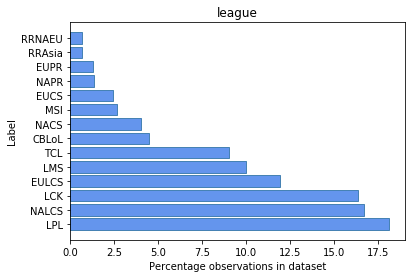

---------------------------------------------------------------------------------------------------- 
Overview of variable:  game 
 ----------------------------------------------------------------------------------------------------
Total categories: 25 

The 10 with the highest percentage data available:

2 : 39.2736 %
1 : 39.036 %
3 : 15.9538 %
4 : 2.9192 %
5 : 1.4257 %
6 : 0.3055 %
T : 0.1018 %
2.6 : 0.0679 %
2.5 : 0.0679 %
2.4 : 0.0679 %

The 10 with the lowest percentage data available:

1.3 : 0.0679 %
1.2 : 0.0679 %
1.1 : 0.0679 %
2.1 : 0.0339 %
3.6 : 0.0339 %
3.5 : 0.0339 %
3.4 : 0.0339 %
3.3 : 0.0339 %
3.2 : 0.0339 %
3.1 : 0.0339 %
---------------------------------------------------------------------------------------------------- 
Overview of variable:  side 
 ----------------------------------------------------------------------------------------------------
Total categories: 2 



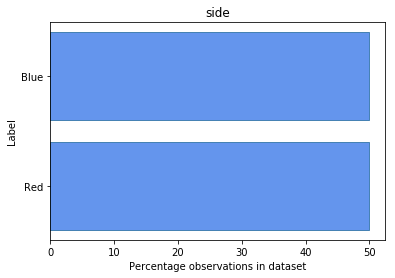

---------------------------------------------------------------------------------------------------- 
Overview of variable:  ban1 
 ----------------------------------------------------------------------------------------------------
Total categories: 87 

The 10 with the highest percentage data available:

LeBlanc : 9.3347 %
Zac : 9.0801 %
Camille : 5.5329 %
Malzahar : 4.294 %
Jayce : 4.243 %
Elise : 4.1242 %
Caitlyn : 3.9206 %
Shen : 3.8018 %
Rengar : 3.5472 %
Syndra : 3.4114 %

The 10 with the lowest percentage data available:

Mordekaiser : 0.0339 %
Sivir : 0.0339 %
Gangplank : 0.0339 %
Ahri : 0.0339 %
Irelia : 0.017 %
Nami : 0.017 %
Vi : 0.017 %
Taric : 0.017 %
Morgana : 0.017 %
Janna : 0.017 %
---------------------------------------------------------------------------------------------------- 
Overview of variable:  ban2 
 ----------------------------------------------------------------------------------------------------
Total categories: 94 

The 10 with the highest percentage d

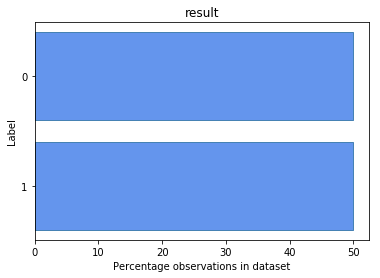

---------------------------------------------------------------------------------------------------- 
Overview of variable:  fb 
 ----------------------------------------------------------------------------------------------------
Total categories: 2 



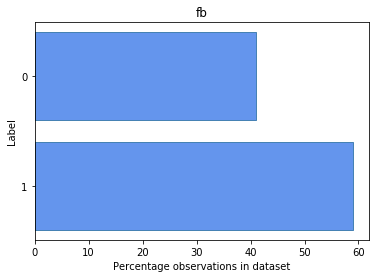

---------------------------------------------------------------------------------------------------- 
Overview of variable:  fbassist 
 ----------------------------------------------------------------------------------------------------
Total categories: 2 



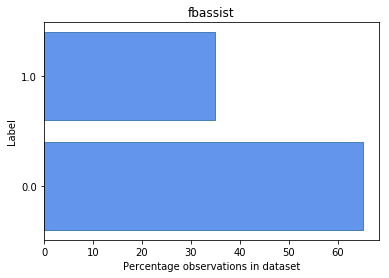

---------------------------------------------------------------------------------------------------- 
Overview of variable:  fbvictim 
 ----------------------------------------------------------------------------------------------------
Total categories: 2 



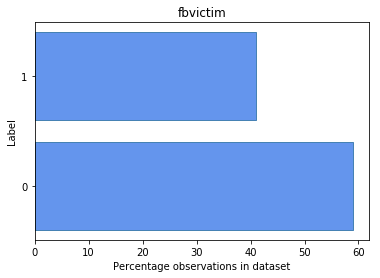

---------------------------------------------------------------------------------------------------- 
Overview of variable:  fd 
 ----------------------------------------------------------------------------------------------------
Total categories: 2 



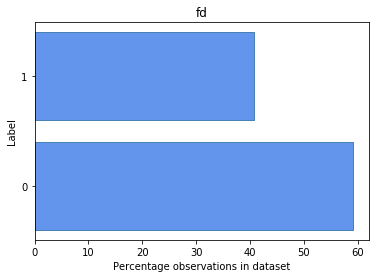

---------------------------------------------------------------------------------------------------- 
Overview of variable:  ft 
 ----------------------------------------------------------------------------------------------------
Total categories: 2 



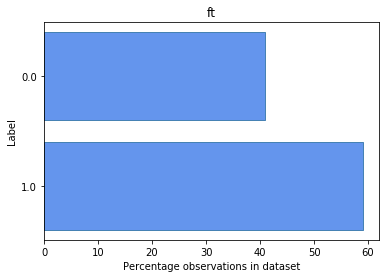

---------------------------------------------------------------------------------------------------- 
Overview of variable:  firstmidouter 
 ----------------------------------------------------------------------------------------------------
Total categories: 2 



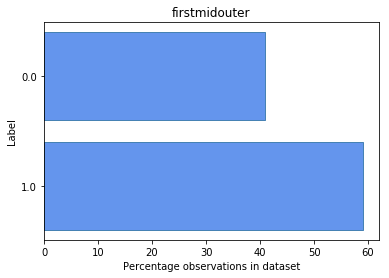

---------------------------------------------------------------------------------------------------- 
Overview of variable:  firsttothreetowers 
 ----------------------------------------------------------------------------------------------------
Total categories: 2 



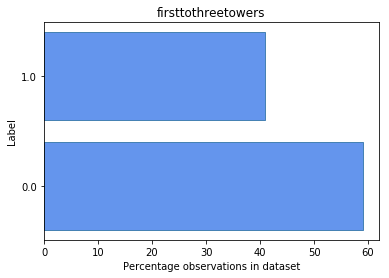

---------------------------------------------------------------------------------------------------- 
Overview of variable:  fbaron 
 ----------------------------------------------------------------------------------------------------
Total categories: 2 



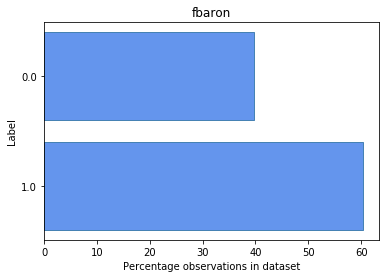

---------------------------------------------------------------------------------------------------- 
Overview of variable:  Year 
 ----------------------------------------------------------------------------------------------------
Total categories: 1 



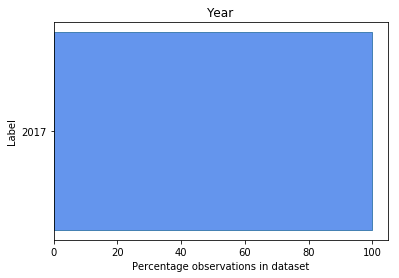

---------------------------------------------------------------------------------------------------- 
Overview of variable:  team 
 ----------------------------------------------------------------------------------------------------
Total categories: 101 

The 10 with the highest percentage data available:

counter logic gaming : 2.2064 %
team solomid : 2.1894 %
team we : 2.0536 %
sk telecom t1 : 2.0027 %
fnatic : 1.9348 %
phoenix1 : 1.8839 %
dignitas : 1.8839 %
kt rolster : 1.85 %
team liquid : 1.833 %
cloud9 : 1.816 %

The 10 with the lowest percentage data available:

kinguin : 0.1527 %
cj entus : 0.1527 %
17 academy : 0.1527 %
isurus gaming : 0.1018 %
lyon gaming : 0.1018 %
virtus.pro : 0.1018 %
rampage : 0.1018 %
dire wolves : 0.1018 %
oyunhizmetleri : 0.0679 %
besiktas : 0.0509 %
---------------------------------------------------------------------------------------------------- 
Overview of variable:  culture 
 --------------------------------------------------------------------

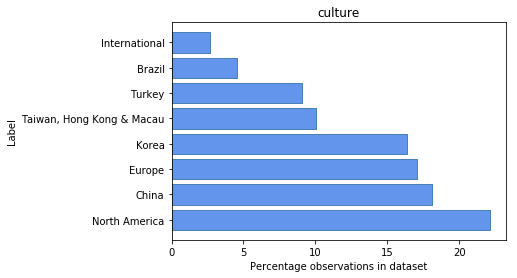

<Figure size 432x288 with 0 Axes>

In [14]:
# Loop through all categorical variables and visualize data
for cat_variable in categorical_variables:
    SummaryCategoricalVar(preprocessed_data[cat_variable], cat_variable)

In [15]:
# Most banned champion
most_banned = list(itertools.chain(preprocessed_data['ban1'], preprocessed_data['ban2'], preprocessed_data['ban3'],
                                   preprocessed_data['ban4'], preprocessed_data['ban5']))
SummaryCategoricalVar(most_banned, "Total times banned as champion")

---------------------------------------------------------------------------------------------------- 
Overview of variable:  Total times banned as champion 
 ----------------------------------------------------------------------------------------------------
Total categories: 120 

The 10 with the highest percentage data available:

LeBlanc : 5.6144 %
Camille : 4.0801 %
Syndra : 3.8425 %
Elise : 3.8119 %
Zac : 3.761 %
Caitlyn : 3.2621 %
Shen : 3.2519 %
Jayce : 3.1466 %
Rengar : 2.9294 %
Thresh : 2.7563 %

The 10 with the lowest percentage data available:

Xerath : 0.0068 %
Urgot : 0.0068 %
Quinn : 0.0068 %
Skarner : 0.0068 %
Hecarim : 0.0068 %
Amumu : 0.0034 %
Kindred : 0.0034 %
Garen : 0.0034 %
Yorick : 0.0034 %
Fiddlesticks : 0.0034 %


##### Encoding

In [16]:
# Encode categorical features in numeric ones
for col in categorical_variables:
    try:
        preprocessed_data['Encoded_' + col] = [int(x) for x in list(preprocessed_data[col])]
    except:
        try: 
            preprocessed_data['Encoded_' + col] = [float(x) for x in list(preprocessed_data[col])]
        except:
            mapping_dict = dict(zip(list(set(preprocessed_data[col])), list(range(len(set(preprocessed_data[col]))))))
            preprocessed_data['Encoded_' + col] = [mapping_dict[x] for x in preprocessed_data[col]]

##### Remove irrelevant features for further analysis

In [17]:
# Drop irrelevant features
catvar_before_encoding = [col[len('Encoded_'):] for col in preprocessed_data.columns if 'Encoded_' in col]
catvar_before_encoding.remove('team')
preprocessed_data = preprocessed_data.drop(labels=catvar_before_encoding, axis=1)
preprocessed_data = preprocessed_data.drop(labels = ['Encoded_gameid', 'Encoded_team'], axis=1)

In [18]:
# Add one-hot-encoded features to numerical feature list
for cat in catvar_before_encoding:
    numerical_variables.append('Encoded_' + cat)
numerical_variables.remove('Encoded_gameid')

### 2.2 Analysis of numerical variables
The following aspects will be analysed here:
* Visualisation data (boxplot, histogram)
* Minimal and maximal values 
* Outliers
* Transformation/ normalization of the data
* Near zero variance indicator (before and after removal outliers)
* Skewness: A measure of lack of symmetry. The skewness for a normal distribution is zero and any symmertric data should have a skewness near zero. Negative values for skewness indicate the data to be skewed left while, positive values imply the data to be skewed right. In case the data is multi-modal, the sign of the skewness metric might be affected.
* Kurtosis: A measure indicating whether the data are heavy-tailed or light-tailed relative to a normal distribution. In case the kurtosis is high the data is distributed with heavy tails (many outliers), while data with low kurtosis tends to have light tails. The kurtosis for a standard normal distribution is three. The scipy package used to calculate the kurtosis here uses the formula for "excess kurtosis" in which the deviation from the normal condition is considered (kurtosis - 3).

##### Exploration characteristics numerical features

Overview of variable:  split 


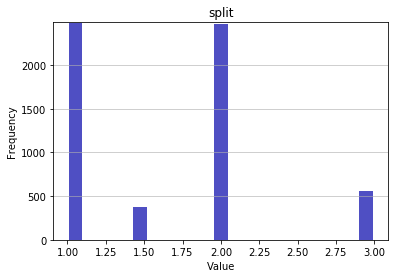

-------------------- 
Summary statistics:
 --------------------
Minimum value: 1.0
Mean: 1.6431
Standard deviation: 0.6365
Median: 2.0
Maximal value: 3.0


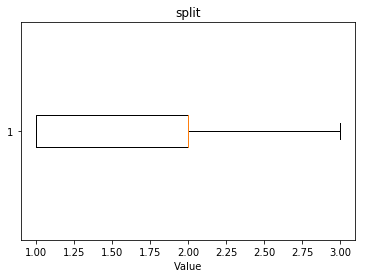

-------------------- 
Outlier detection:
 --------------------
List of outliers: set()


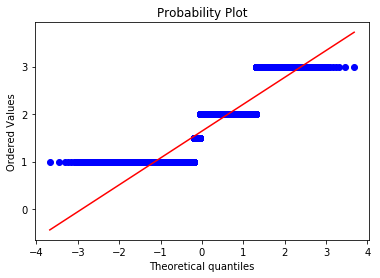

-------------------- 
Check for normal distribution:
 --------------------
Skewedness: 0.5667
Kurtosis: -0.5423
Overview of variable:  patchno 


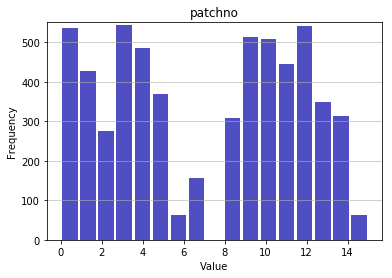

-------------------- 
Summary statistics:
 --------------------
Minimum value: 0
Mean: 6.9997
Standard deviation: 4.5607
Median: 8.0
Maximal value: 15


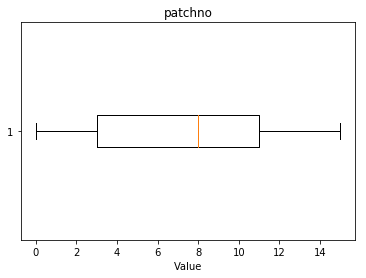

-------------------- 
Outlier detection:
 --------------------
List of outliers: set()


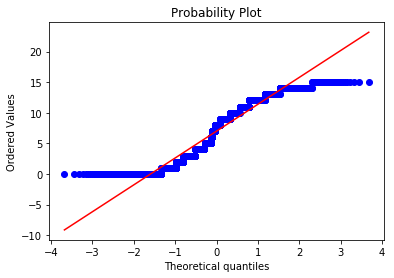

-------------------- 
Check for normal distribution:
 --------------------
Skewedness: -0.0582
Kurtosis: -1.3692
Overview of variable:  gamelength 


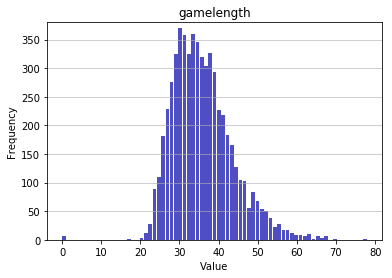

-------------------- 
Summary statistics:
 --------------------
Minimum value: 0.0
Mean: 35.9447
Standard deviation: 7.7923
Median: 34.875
Maximal value: 77.95


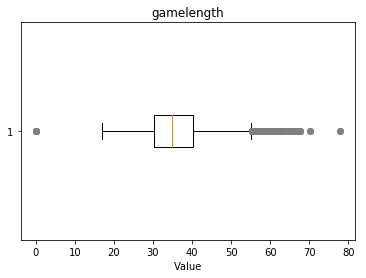

-------------------- 
Outlier detection:
 --------------------
List of outliers: {0.0, 59.9, 60.63, 60.13, 60.95, 63.25, 61.57, 61.12, 62.07, 59.82, 60.65, 63.2, 62.23, 63.35, 63.52, 65.7, 65.9, 67.65, 67.58, 65.82, 65.38, 70.25, 64.72, 63.13, 66.83, 66.98, 77.95}


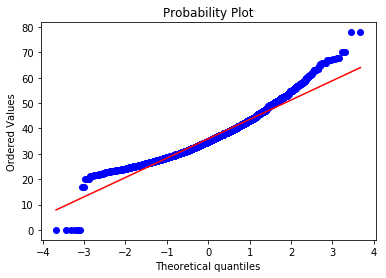

-------------------- 
Check for normal distribution:
 --------------------
Skewedness: 0.7765
Kurtosis: 1.4458
Overview of variable:  k 


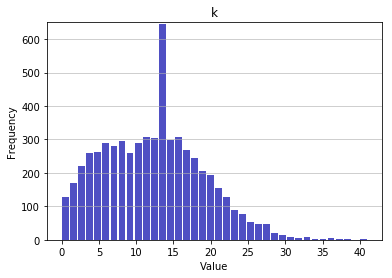

-------------------- 
Summary statistics:
 --------------------
Minimum value: 0.0
Mean: 12.3383
Standard deviation: 6.6325
Median: 12.0
Maximal value: 41.0


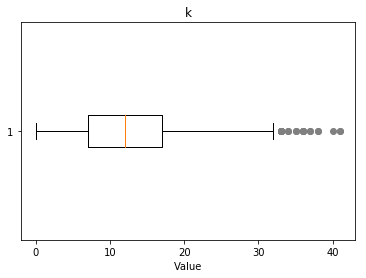

-------------------- 
Outlier detection:
 --------------------
List of outliers: {33.0, 34.0, 35.0, 36.0, 37.0, 38.0, 40.0, 41.0}


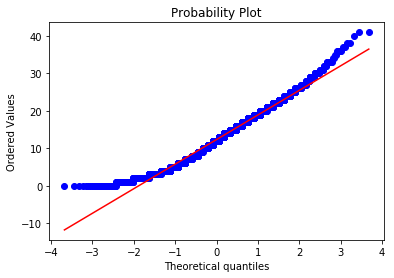

-------------------- 
Check for normal distribution:
 --------------------
Skewedness: 0.396
Kurtosis: -0.1345
Overview of variable:  d 


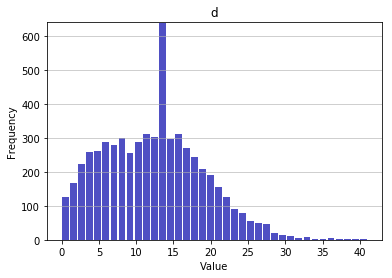

-------------------- 
Summary statistics:
 --------------------
Minimum value: 0.0
Mean: 12.3598
Standard deviation: 6.6407
Median: 12.0
Maximal value: 41.0


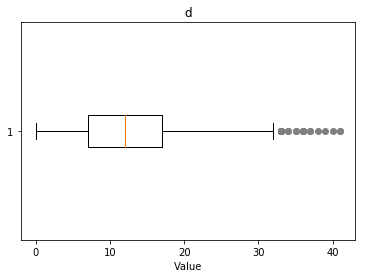

-------------------- 
Outlier detection:
 --------------------
List of outliers: {33.0, 34.0, 35.0, 36.0, 37.0, 38.0, 39.0, 40.0, 41.0}


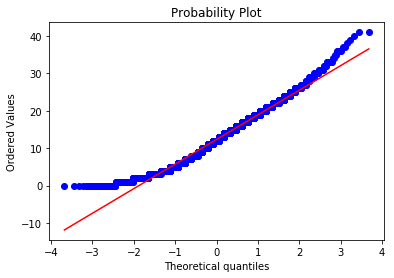

-------------------- 
Check for normal distribution:
 --------------------
Skewedness: 0.3964
Kurtosis: -0.1331
Overview of variable:  a 


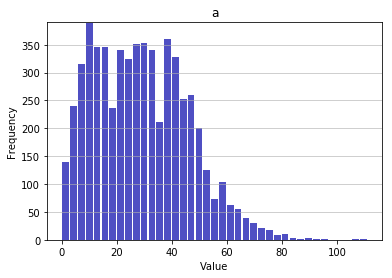

-------------------- 
Summary statistics:
 --------------------
Minimum value: 0.0
Mean: 28.8445
Standard deviation: 17.0001
Median: 28.0
Maximal value: 111.0


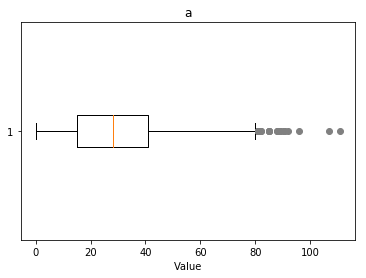

-------------------- 
Outlier detection:
 --------------------
List of outliers: {96.0, 107.0, 111.0, 80.0, 81.0, 82.0, 85.0, 88.0, 89.0, 90.0, 91.0, 92.0}


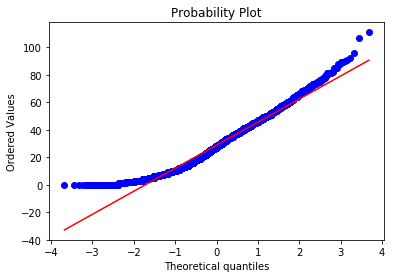

-------------------- 
Check for normal distribution:
 --------------------
Skewedness: 0.4776
Kurtosis: -0.1336
Overview of variable:  teamkills 


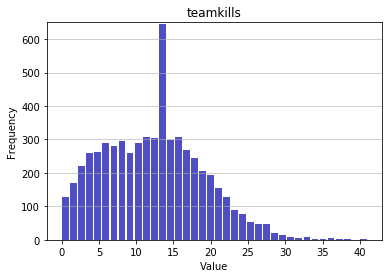

-------------------- 
Summary statistics:
 --------------------
Minimum value: 0.0
Mean: 12.3383
Standard deviation: 6.6325
Median: 12.0
Maximal value: 41.0


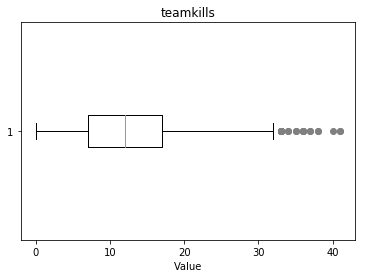

-------------------- 
Outlier detection:
 --------------------
List of outliers: {33.0, 34.0, 35.0, 36.0, 37.0, 38.0, 40.0, 41.0}


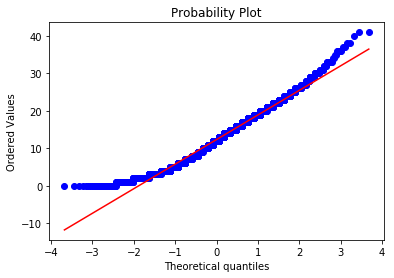

-------------------- 
Check for normal distribution:
 --------------------
Skewedness: 0.396
Kurtosis: -0.1345
Overview of variable:  fbtime 


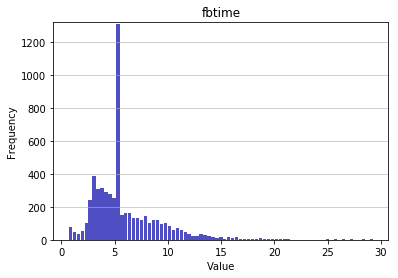

-------------------- 
Summary statistics:
 --------------------
Minimum value: 0.6477833333333333
Mean: 5.9518
Standard deviation: 3.2254
Median: 5.1493
Maximal value: 29.299416666666666


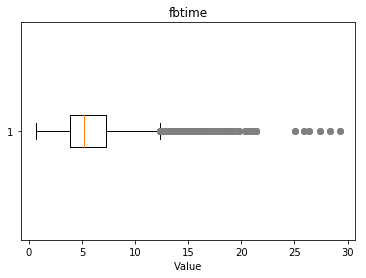

-------------------- 
Outlier detection:
 --------------------
List of outliers: {15.76, 16.01, 16.33, 18.45, 19.58, 19.18, 20.64, 18.63, 18.47, 16.2, 16.3, 17.89, 19.02, 27.42, 29.3, 21.35, 26.35, 28.37, 25.04, 25.86, 15.79, 15.87, 15.95, 15.89, 16.84, 16.56, 16.13, 16.98, 16.43, 16.34, 17.03, 17.57, 17.23, 17.6, 16.39, 18.51, 18.72, 18.13, 18.69, 18.62, 19.75, 20.32, 20.93, 20.99, 21.33, 16.36}


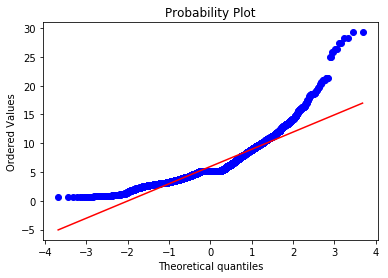

-------------------- 
Check for normal distribution:
 --------------------
Skewedness: 1.8026
Kurtosis: 5.6179
Overview of variable:  kpm 


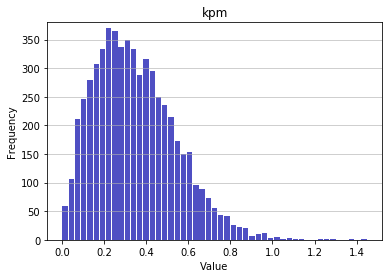

-------------------- 
Summary statistics:
 --------------------
Minimum value: 0.0
Mean: 0.348
Standard deviation: 0.1942
Median: 0.3245
Maximal value: 1.4504716981132075


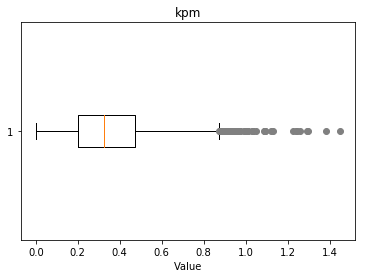

-------------------- 
Outlier detection:
 --------------------
List of outliers: {0.99, 1.12, 0.94, 1.25, 1.04, 0.95, 1.01, 0.96, 1.03, 1.09, 1.26, 1.0, 0.93, 1.45, 1.13, 1.38, 1.29, 0.97, 1.05, 1.3, 1.23, 1.24}


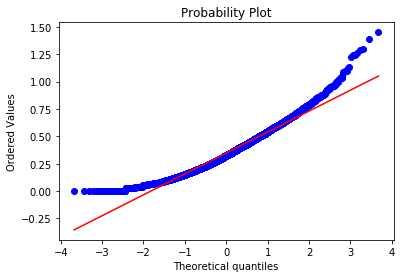

-------------------- 
Check for normal distribution:
 --------------------
Skewedness: 0.7329
Kurtosis: 0.7551
Overview of variable:  ckpm 


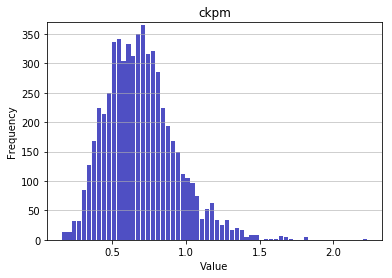

-------------------- 
Summary statistics:
 --------------------
Minimum value: 0.16216216216216214
Mean: 0.6961
Standard deviation: 0.2366
Median: 0.6768
Maximal value: 2.2287735849056602


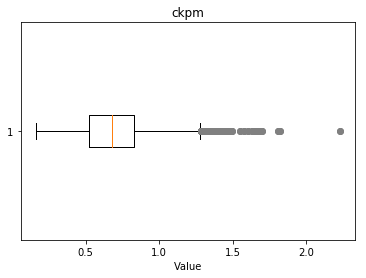

-------------------- 
Outlier detection:
 --------------------
List of outliers: {1.41, 1.57, 1.47, 1.55, 1.66, 1.68, 1.43, 1.45, 1.49, 1.6, 1.48, 1.81, 1.44, 2.23, 1.63, 1.82, 1.64, 1.7, 1.67}


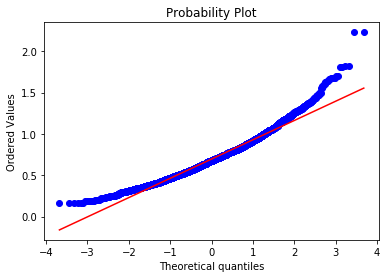

-------------------- 
Check for normal distribution:
 --------------------
Skewedness: 0.7879
Kurtosis: 1.417
Overview of variable:  fdtime 


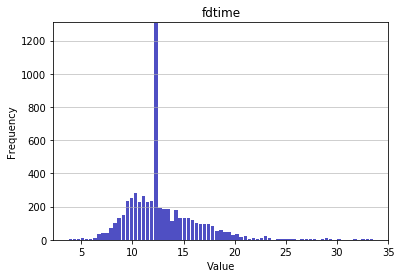

-------------------- 
Summary statistics:
 --------------------
Minimum value: 3.7404500000000005
Mean: 12.8065
Standard deviation: 3.3822
Median: 12.2196
Maximal value: 33.554633333333335


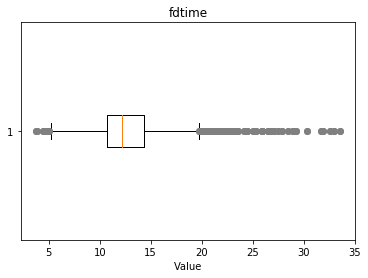

-------------------- 
Outlier detection:
 --------------------
List of outliers: {26.95, 26.51, 27.5, 27.9, 27.12, 28.91, 29.06, 23.09, 24.46, 25.86, 26.76, 25.24, 28.46, 29.24, 23.22, 31.71, 32.99, 24.44, 25.15, 26.48, 28.96, 29.08, 25.27, 30.34, 33.55, 32.57, 31.9, 25.25, 24.12, 23.44, 23.02, 23.42, 23.03, 23.04, 23.53, 23.24, 23.16, 23.28, 23.11, 25.07, 25.94}


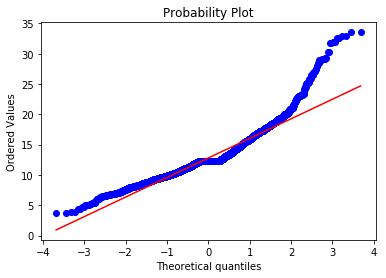

-------------------- 
Check for normal distribution:
 --------------------
Skewedness: 1.39
Kurtosis: 4.0096
Overview of variable:  teamdragkills 


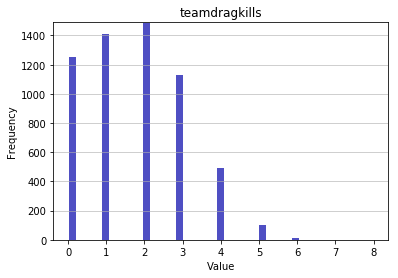

-------------------- 
Summary statistics:
 --------------------
Minimum value: 0.0
Mean: 1.757
Standard deviation: 1.3275
Median: 2.0
Maximal value: 8.0


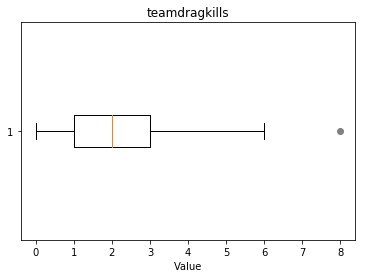

-------------------- 
Outlier detection:
 --------------------
List of outliers: {8.0, 6.0}


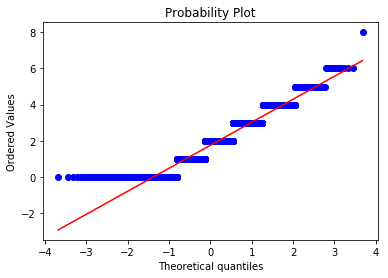

-------------------- 
Check for normal distribution:
 --------------------
Skewedness: 0.3792
Kurtosis: -0.5209
Overview of variable:  elementals 


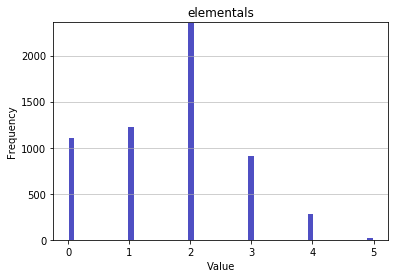

-------------------- 
Summary statistics:
 --------------------
Minimum value: 0.0
Mean: 1.6726
Standard deviation: 1.103
Median: 2.0
Maximal value: 5.0


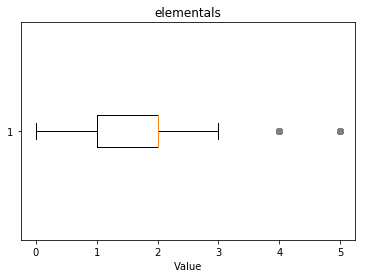

-------------------- 
Outlier detection:
 --------------------
List of outliers: {5.0}


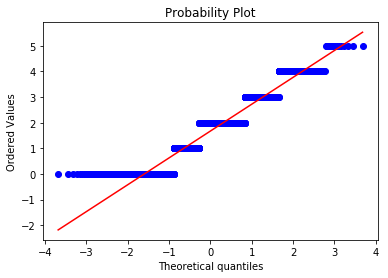

-------------------- 
Check for normal distribution:
 --------------------
Skewedness: 0.092
Kurtosis: -0.5026
Overview of variable:  firedrakes 


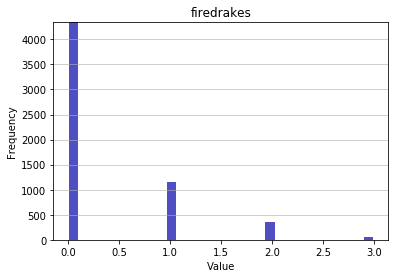

-------------------- 
Summary statistics:
 --------------------
Minimum value: 0.0
Mean: 0.342
Standard deviation: 0.6332
Median: 0.0
Maximal value: 3.0


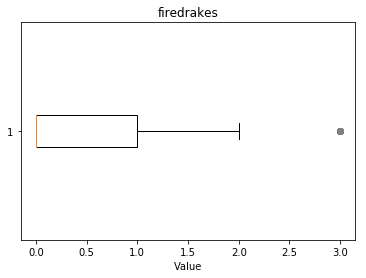

-------------------- 
Outlier detection:
 --------------------
List of outliers: {3.0}


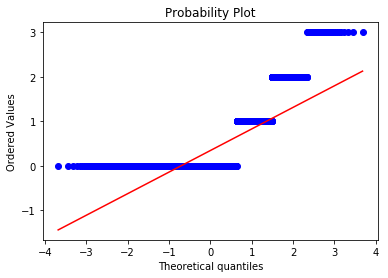

-------------------- 
Check for normal distribution:
 --------------------
Skewedness: 1.8725
Kurtosis: 3.0357
Overview of variable:  waterdrakes 


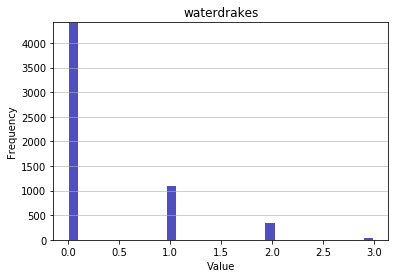

-------------------- 
Summary statistics:
 --------------------
Minimum value: 0.0
Mean: 0.324
Standard deviation: 0.6153
Median: 0.0
Maximal value: 3.0


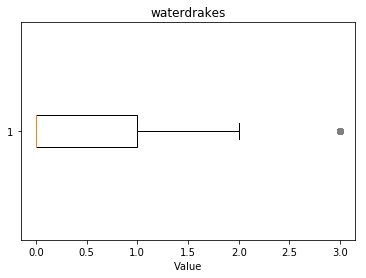

-------------------- 
Outlier detection:
 --------------------
List of outliers: {3.0}


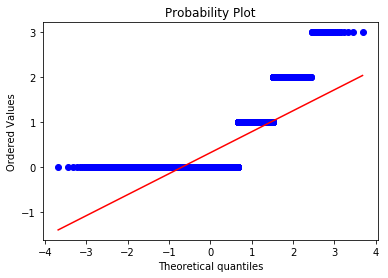

-------------------- 
Check for normal distribution:
 --------------------
Skewedness: 1.9081
Kurtosis: 3.127
Overview of variable:  earthdrakes 


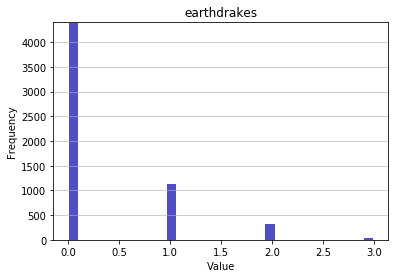

-------------------- 
Summary statistics:
 --------------------
Minimum value: 0.0
Mean: 0.3232
Standard deviation: 0.6109
Median: 0.0
Maximal value: 3.0


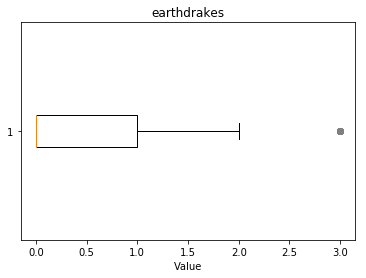

-------------------- 
Outlier detection:
 --------------------
List of outliers: {3.0}


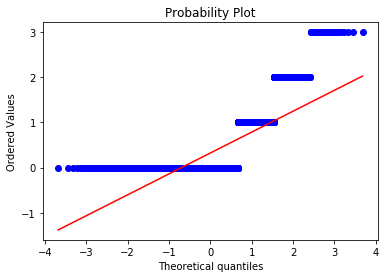

-------------------- 
Check for normal distribution:
 --------------------
Skewedness: 1.9206
Kurtosis: 3.2812
Overview of variable:  airdrakes 


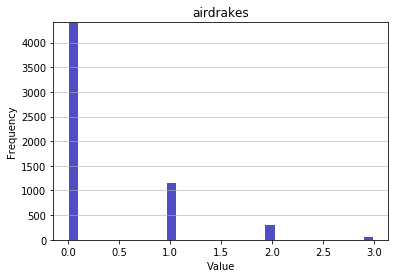

-------------------- 
Summary statistics:
 --------------------
Minimum value: 0.0
Mean: 0.3209
Standard deviation: 0.6083
Median: 0.0
Maximal value: 3.0


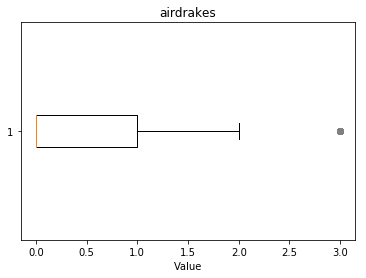

-------------------- 
Outlier detection:
 --------------------
List of outliers: {3.0}


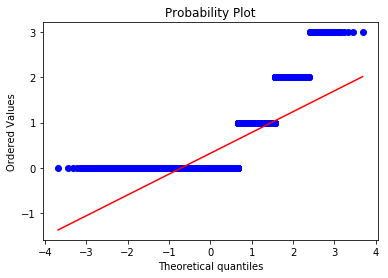

-------------------- 
Check for normal distribution:
 --------------------
Skewedness: 1.9449
Kurtosis: 3.4539
Overview of variable:  elders 


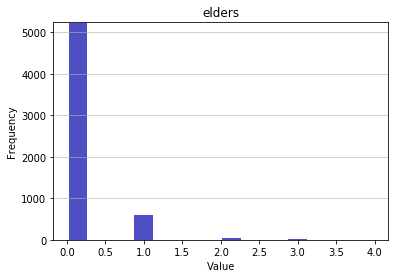

-------------------- 
Summary statistics:
 --------------------
Minimum value: 0.0
Mean: 0.1227
Standard deviation: 0.3663
Median: 0.0
Maximal value: 4.0


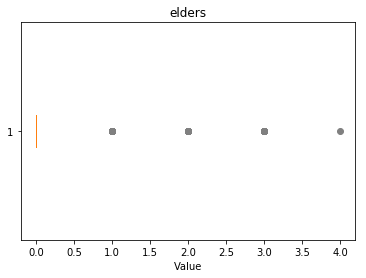

-------------------- 
Outlier detection:
 --------------------
List of outliers: {2.0, 3.0, 4.0}


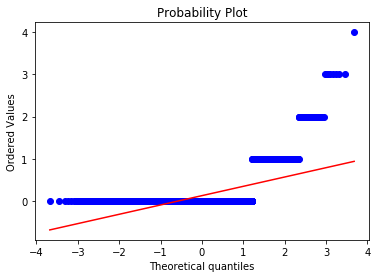

-------------------- 
Check for normal distribution:
 --------------------
Skewedness: 3.321
Kurtosis: 13.2877
Overview of variable:  fttime 


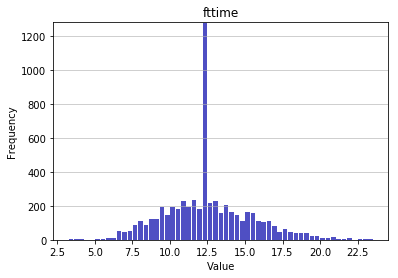

-------------------- 
Summary statistics:
 --------------------
Minimum value: 3.2423333333333333
Mean: 12.5231
Standard deviation: 2.8633
Median: 12.3595
Maximal value: 23.549933333333332


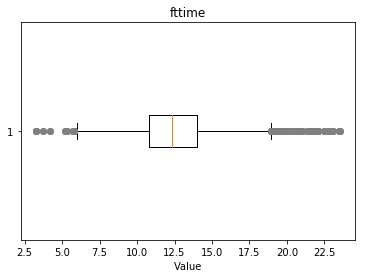

-------------------- 
Outlier detection:
 --------------------
List of outliers: {3.24, 3.27, 3.73, 23.46, 23.55, 23.07, 21.99, 21.61, 21.32, 21.6, 22.5, 21.87, 21.96, 22.07, 22.1, 22.77, 22.86}


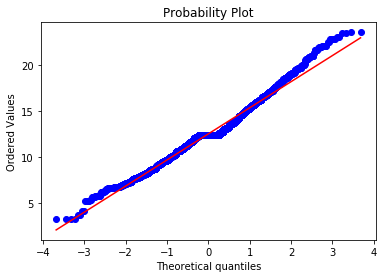

-------------------- 
Check for normal distribution:
 --------------------
Skewedness: 0.4011
Kurtosis: 0.5776
Overview of variable:  teamtowerkills 


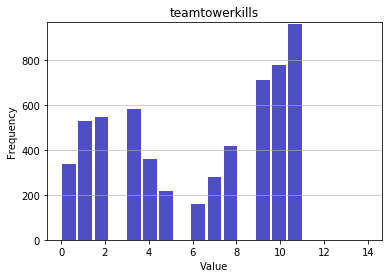

-------------------- 
Summary statistics:
 --------------------
Minimum value: 0.0
Mean: 6.2738
Standard deviation: 3.8148
Median: 7.0
Maximal value: 14.0


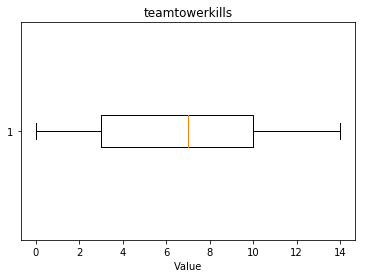

-------------------- 
Outlier detection:
 --------------------
List of outliers: set()


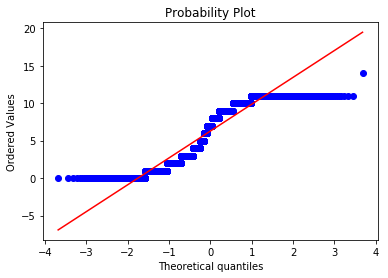

-------------------- 
Check for normal distribution:
 --------------------
Skewedness: -0.2168
Kurtosis: -1.4966
Overview of variable:  fbarontime 


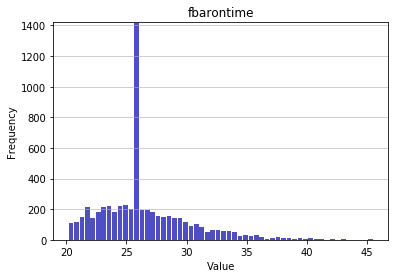

-------------------- 
Summary statistics:
 --------------------
Minimum value: 20.161783333333332
Mean: 26.4903
Standard deviation: 3.7309
Median: 25.988
Maximal value: 45.549933333333335


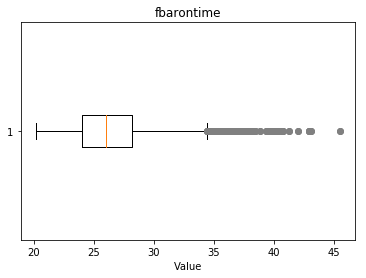

-------------------- 
Outlier detection:
 --------------------
List of outliers: {37.95, 38.36, 38.44, 38.26, 37.91, 39.69, 40.18, 40.37, 40.77, 39.86, 39.49, 40.32, 42.95, 41.25, 42.93, 45.55, 37.88, 37.79, 37.93, 37.92, 38.83, 38.47, 38.28, 38.38, 38.34, 39.61, 39.43, 39.4, 39.51, 39.95, 40.09, 40.27, 40.67, 40.41, 42.01, 43.08}


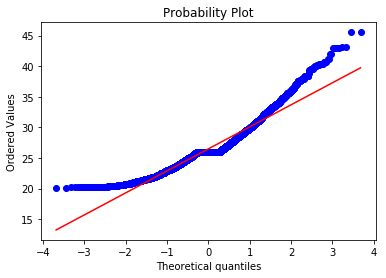

-------------------- 
Check for normal distribution:
 --------------------
Skewedness: 1.0402
Kurtosis: 1.6322
Overview of variable:  teambaronkills 


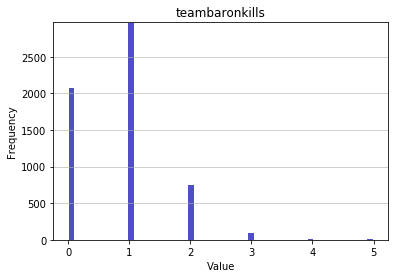

-------------------- 
Summary statistics:
 --------------------
Minimum value: 0.0
Mean: 0.8153
Standard deviation: 0.7335
Median: 1.0
Maximal value: 5.0


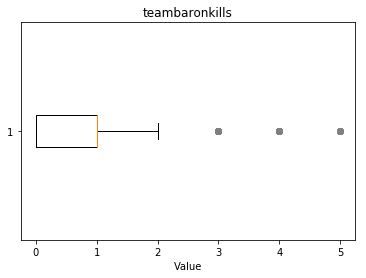

-------------------- 
Outlier detection:
 --------------------
List of outliers: {4.0, 5.0}


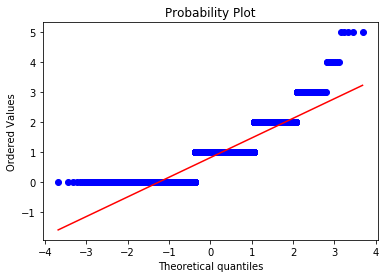

-------------------- 
Check for normal distribution:
 --------------------
Skewedness: 0.7808
Kurtosis: 1.1742
Overview of variable:  dmgtochamps 


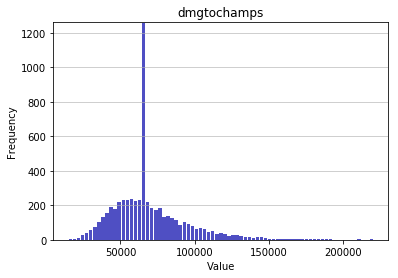

-------------------- 
Summary statistics:
 --------------------
Minimum value: 14879.0
Mean: 69328.2206
Standard deviation: 25548.1326
Median: 65040.5
Maximal value: 220344.0


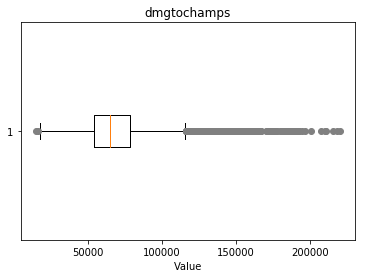

-------------------- 
Outlier detection:
 --------------------
List of outliers: {148498.0, 186899.0, 215570.0, 146450.0, 173088.0, 165924.0, 190000.0, 209973.0, 155189.0, 171575.0, 189528.0, 181337.0, 153694.0, 147554.0, 207464.0, 149100.0, 172656.0, 173685.0, 147063.0, 177282.0, 174216.0, 191113.0, 188040.0, 163465.0, 148632.0, 196761.0, 173209.0, 170649.0, 155293.0, 179872.0, 192673.0, 159916.0, 174257.0, 220344.0, 165057.0, 154308.0, 164552.0, 157905.0, 180441.0, 155866.0, 170208.0, 160993.0, 146144.0, 166642.0, 183541.0, 218360.0, 166657.0, 148229.0, 187150.0, 185103.0, 192270.0, 156949.0, 200471.0, 147738.0, 147230.0, 151328.0, 148258.0, 148270.0, 146735.0, 160046.0, 162608.0, 188231.0, 184142.0, 194385.0, 171881.0, 150898.0, 150904.0, 210814.0, 177025.0, 166280.0, 182666.0, 147340.0, 191376.0, 158613.0, 164757.0, 160664.0, 172953.0, 177580.0, 161709.0, 150449.0, 175028.0, 155070.0, 160190.0, 152020.0, 176606.0, 184302.0, 155640.0}


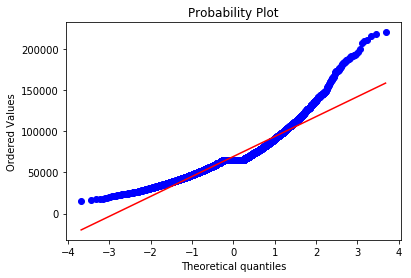

-------------------- 
Check for normal distribution:
 --------------------
Skewedness: 1.4539
Kurtosis: 3.6654
Overview of variable:  dmgtochampsperminute 


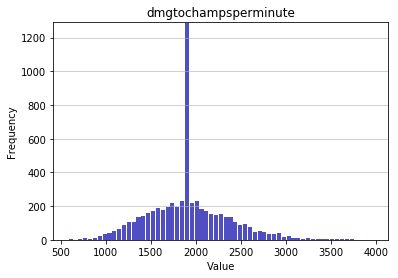

-------------------- 
Summary statistics:
 --------------------
Minimum value: 583.3471933471933
Mean: 1909.8049
Standard deviation: 439.8542
Median: 1887.9615
Maximal value: 3971.8669899549704


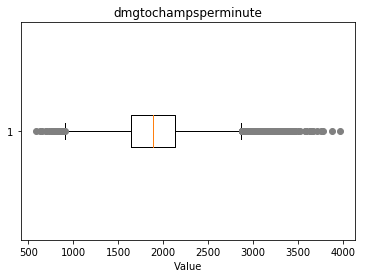

-------------------- 
Outlier detection:
 --------------------
List of outliers: {3587.16, 3971.87, 3589.58, 3459.12, 3718.88, 3334.33, 3338.36, 3467.36, 3338.76, 3474.22, 3359.71, 3232.61, 3232.9, 3231.74, 3363.57, 3876.62, 3753.4, 3242.43, 3372.45, 3375.87, 3631.59, 3505.39, 3250.37, 3636.02, 3252.61, 3383.64, 3392.57, 3266.84, 3780.57, 3269.03, 583.35, 3400.26, 3530.3, 3662.97, 3279.15, 3414.21, 3674.42, 3293.82, 3453.76, 3434.71, 3308.04, 3437.18, 3577.89, 3323.51, 3325.61}


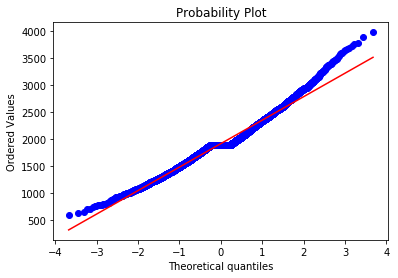

-------------------- 
Check for normal distribution:
 --------------------
Skewedness: 0.4627
Kurtosis: 0.9218
Overview of variable:  wards 


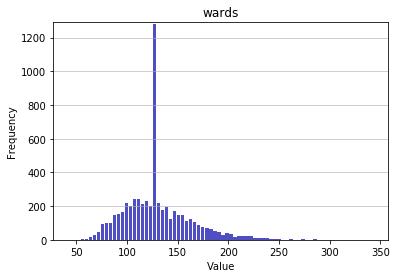

-------------------- 
Summary statistics:
 --------------------
Minimum value: 42.0
Mean: 129.3634
Standard deviation: 32.6602
Median: 126.0
Maximal value: 343.0


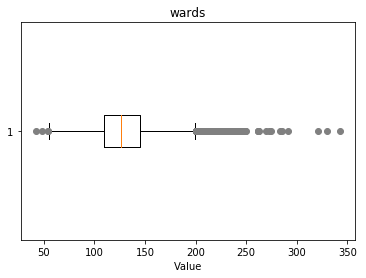

-------------------- 
Outlier detection:
 --------------------
List of outliers: {262.0, 263.0, 270.0, 273.0, 275.0, 284.0, 285.0, 291.0, 321.0, 330.0, 343.0, 228.0, 229.0, 230.0, 231.0, 232.0, 233.0, 234.0, 235.0, 236.0, 237.0, 238.0, 239.0, 240.0, 241.0, 242.0, 243.0, 245.0, 246.0, 247.0, 248.0, 249.0, 250.0}


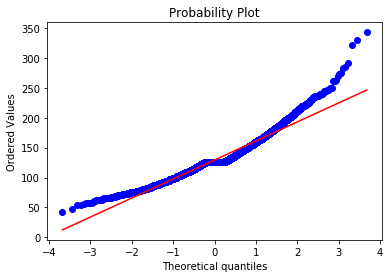

-------------------- 
Check for normal distribution:
 --------------------
Skewedness: 0.9397
Kurtosis: 1.9388
Overview of variable:  wpm 


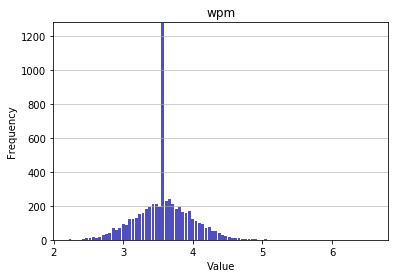

-------------------- 
Summary statistics:
 --------------------
Minimum value: 2.213740458015267
Mean: 3.5849
Standard deviation: 0.3877
Median: 3.588
Maximal value: 6.593075765178123


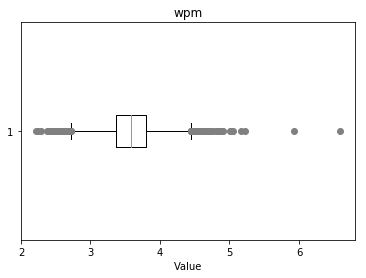

-------------------- 
Outlier detection:
 --------------------
List of outliers: {2.41, 2.29, 4.82, 5.93, 4.83, 4.76, 6.59, 4.84, 5.01, 4.8, 5.22, 5.02, 5.06, 2.42, 2.25, 4.85, 4.75, 4.91, 5.16, 2.38, 2.21, 4.89, 4.87}


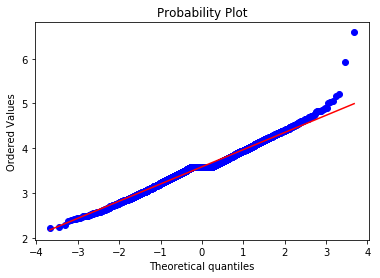

-------------------- 
Check for normal distribution:
 --------------------
Skewedness: 0.1625
Kurtosis: 1.352
Overview of variable:  wardshare 


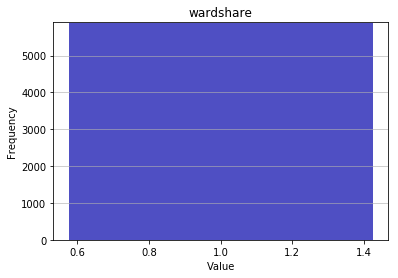

-------------------- 
Summary statistics:
 --------------------
Minimum value: 1.0
Mean: 1.0
Standard deviation: 0.0
Median: 1.0
Maximal value: 1.0


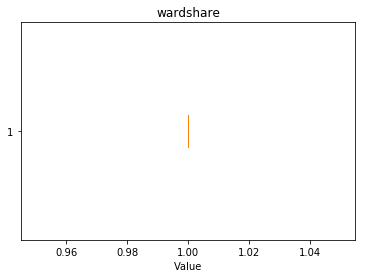

-------------------- 
Outlier detection:
 --------------------
List of outliers: set()


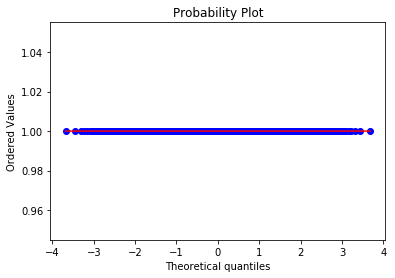

-------------------- 
Check for normal distribution:
 --------------------
Skewedness: 0.0
Kurtosis: -3.0
Overview of variable:  wardkills 


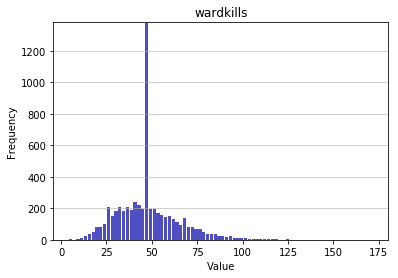

-------------------- 
Summary statistics:
 --------------------
Minimum value: 4.0
Mean: 47.7293
Standard deviation: 17.1532
Median: 46.0
Maximal value: 172.0


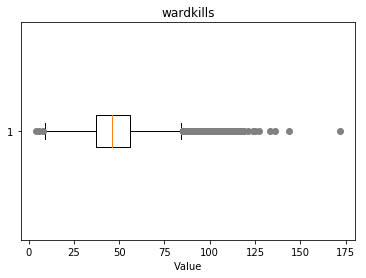

-------------------- 
Outlier detection:
 --------------------
List of outliers: {133.0, 136.0, 144.0, 172.0, 100.0, 101.0, 102.0, 103.0, 104.0, 105.0, 106.0, 107.0, 108.0, 109.0, 110.0, 111.0, 113.0, 114.0, 115.0, 116.0, 117.0, 118.0, 119.0, 121.0, 124.0, 125.0, 127.0}


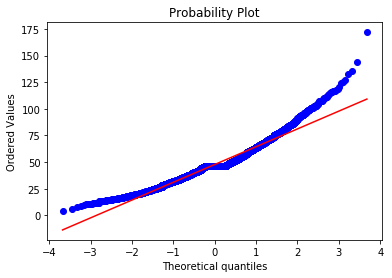

-------------------- 
Check for normal distribution:
 --------------------
Skewedness: 0.9234
Kurtosis: 1.971
Overview of variable:  wcpm 


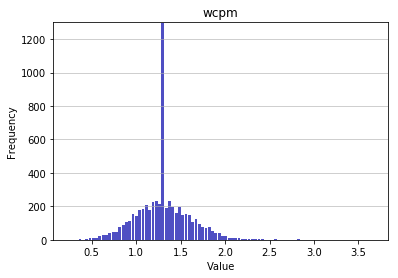

-------------------- 
Summary statistics:
 --------------------
Minimum value: 0.23715415019762845
Mean: 1.3021
Standard deviation: 0.3001
Median: 1.2896
Maximal value: 3.6673773987206824


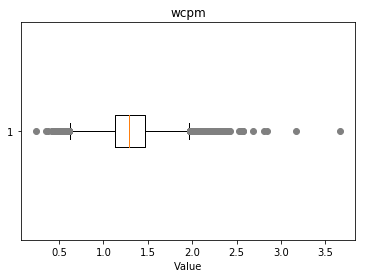

-------------------- 
Outlier detection:
 --------------------
List of outliers: {0.36, 0.24, 2.25, 2.2, 2.4, 2.35, 2.32, 2.36, 2.26, 2.57, 2.22, 2.28, 2.41, 2.34, 2.33, 2.24, 3.67, 3.17, 2.69, 2.85, 2.53, 2.43, 0.37, 2.55, 2.29, 2.3, 2.37, 2.23, 2.81, 2.31, 2.39}


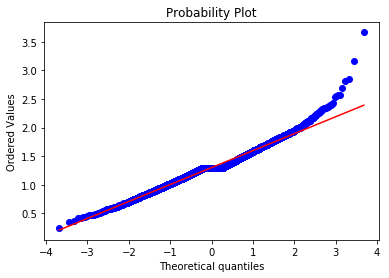

-------------------- 
Check for normal distribution:
 --------------------
Skewedness: 0.4405
Kurtosis: 1.7894
Overview of variable:  visionwards 


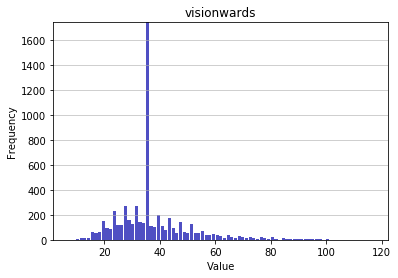

-------------------- 
Summary statistics:
 --------------------
Minimum value: 7.0
Mean: 37.4143
Standard deviation: 13.7539
Median: 35.0
Maximal value: 117.0


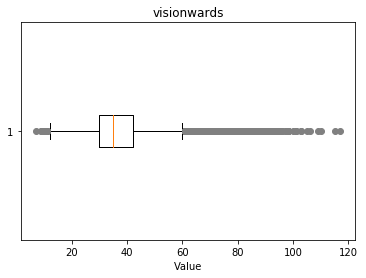

-------------------- 
Outlier detection:
 --------------------
List of outliers: {79.0, 80.0, 81.0, 82.0, 83.0, 84.0, 85.0, 86.0, 87.0, 88.0, 89.0, 90.0, 91.0, 92.0, 93.0, 94.0, 95.0, 96.0, 97.0, 98.0, 100.0, 101.0, 103.0, 105.0, 106.0, 109.0, 110.0, 115.0, 117.0}


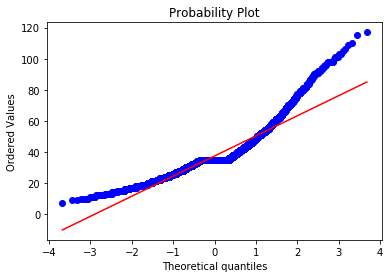

-------------------- 
Check for normal distribution:
 --------------------
Skewedness: 1.4801
Kurtosis: 3.4613
Overview of variable:  visionwardbuys 


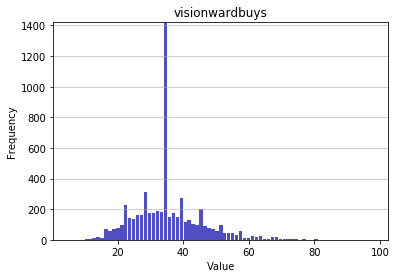

-------------------- 
Summary statistics:
 --------------------
Minimum value: 5.0
Mean: 35.2985
Standard deviation: 10.3739
Median: 34.0
Maximal value: 98.0


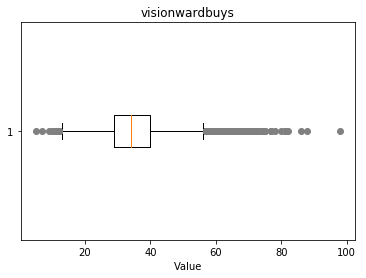

-------------------- 
Outlier detection:
 --------------------
List of outliers: {98.0, 67.0, 68.0, 69.0, 70.0, 71.0, 72.0, 73.0, 74.0, 75.0, 77.0, 78.0, 80.0, 81.0, 82.0, 86.0, 88.0}


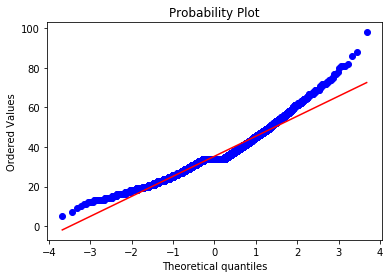

-------------------- 
Check for normal distribution:
 --------------------
Skewedness: 0.8511
Kurtosis: 1.5373
Overview of variable:  visiblewardclearrate 


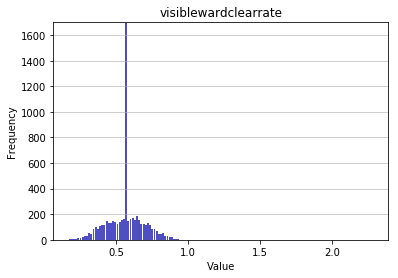

-------------------- 
Summary statistics:
 --------------------
Minimum value: 0.17142857142857143
Mean: 0.5693
Standard deviation: 0.1309
Median: 0.5714
Maximal value: 2.282051282051282


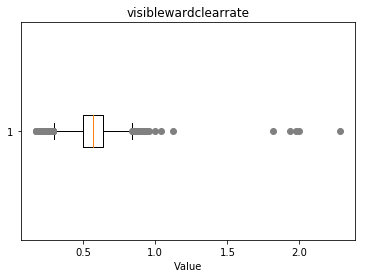

-------------------- 
Outlier detection:
 --------------------
List of outliers: {0.17, 1.0, 1.81, 1.98, 1.12, 1.04, 2.28, 2.0, 1.93}


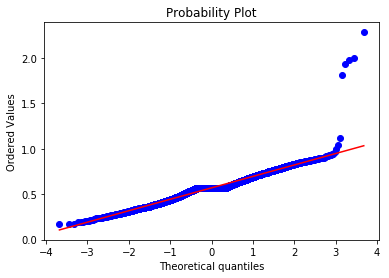

-------------------- 
Check for normal distribution:
 --------------------
Skewedness: 1.1064
Kurtosis: 12.6763
Overview of variable:  invisiblewardclearrate 


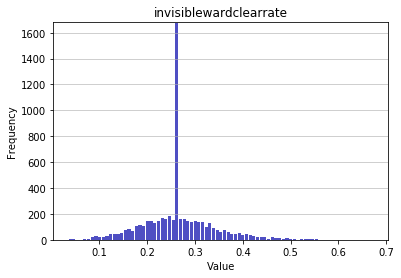

-------------------- 
Summary statistics:
 --------------------
Minimum value: 0.03508771929824561
Mean: 0.2652
Standard deviation: 0.0749
Median: 0.2603
Maximal value: 0.6730769230769231


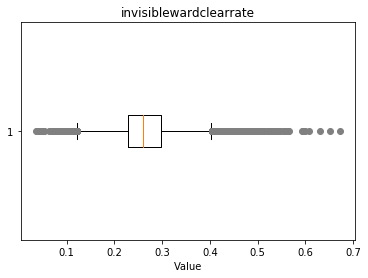

-------------------- 
Outlier detection:
 --------------------
List of outliers: {0.5, 0.51, 0.55, 0.49, 0.6, 0.54, 0.67, 0.52, 0.59, 0.53, 0.56, 0.63, 0.61, 0.65, 0.57, 0.04}


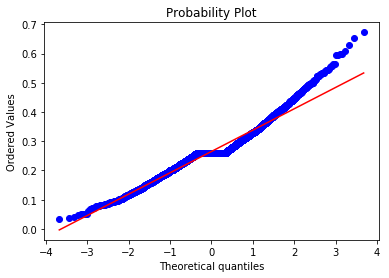

-------------------- 
Check for normal distribution:
 --------------------
Skewedness: 0.6062
Kurtosis: 1.7491
Overview of variable:  totalgold 


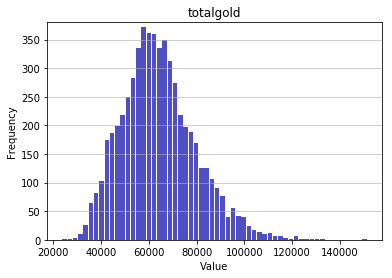

-------------------- 
Summary statistics:
 --------------------
Minimum value: 23774.0
Mean: 64239.0745
Standard deviation: 15473.3536
Median: 62895.5
Maximal value: 151354.0


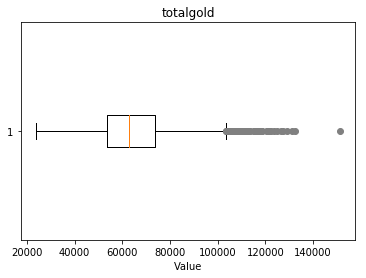

-------------------- 
Outlier detection:
 --------------------
List of outliers: {115202.0, 122500.0, 131205.0, 115719.0, 120590.0, 121487.0, 118800.0, 113680.0, 120851.0, 113300.0, 115091.0, 115616.0, 112162.0, 117800.0, 116908.0, 121146.0, 151354.0, 115908.0, 123595.0, 111821.0, 121300.0, 132564.0, 127447.0, 115418.0, 116700.0, 120800.0, 129121.0, 111200.0, 124900.0, 111206.0, 118761.0, 110700.0, 126447.0, 111606.0, 113271.0, 117238.0, 112246.0, 112509.0}


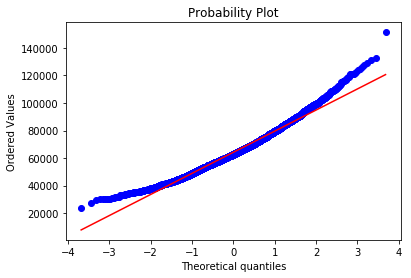

-------------------- 
Check for normal distribution:
 --------------------
Skewedness: 0.5977
Kurtosis: 0.6061
Overview of variable:  earnedgpm 


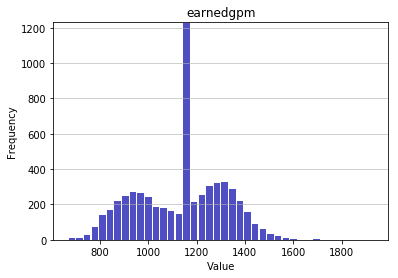

-------------------- 
Summary statistics:
 --------------------
Minimum value: 669.4931801866476
Mean: 1137.941
Standard deviation: 180.2674
Median: 1156.53
Maximal value: 1931.5423983943804


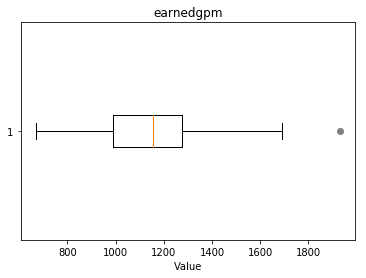

-------------------- 
Outlier detection:
 --------------------
List of outliers: {1684.0, 1931.54, 1691.99}


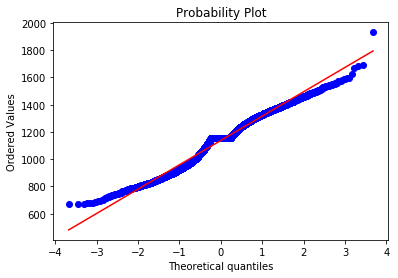

-------------------- 
Check for normal distribution:
 --------------------
Skewedness: -0.139
Kurtosis: -0.6315
Overview of variable:  goldspent 


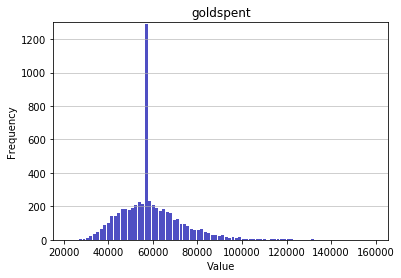

-------------------- 
Summary statistics:
 --------------------
Minimum value: 22035.0
Mean: 59009.9752
Standard deviation: 13551.5883
Median: 57680.0
Maximal value: 158958.0


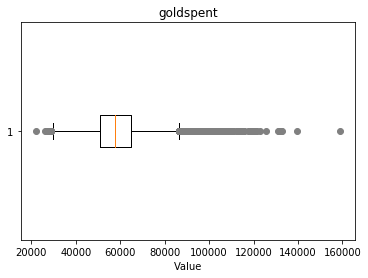

-------------------- 
Outlier detection:
 --------------------
List of outliers: {105985.0, 103300.0, 109575.0, 119690.0, 103185.0, 112401.0, 115858.0, 119320.0, 121625.0, 101913.0, 120603.0, 111260.0, 108445.0, 117275.0, 108580.0, 106283.0, 104368.0, 118450.0, 101043.0, 107060.0, 104626.0, 107830.0, 125690.0, 107709.0, 101440.0, 120260.0, 115270.0, 109563.0, 132680.0, 105545.0, 115020.0, 115533.0, 132430.0, 107860.0, 100435.0, 131667.0, 115285.0, 131028.0, 119383.0, 106963.0, 107993.0, 103258.0, 109525.0, 109660.0, 101213.0, 104283.0, 112863.0, 101215.0, 107872.0, 110435.0, 122985.0, 113770.0, 102890.0, 106217.0, 109678.0, 158958.0, 104558.0, 114673.0, 112759.0, 139513.0, 106490.0, 102395.0, 103420.0, 103295.0}


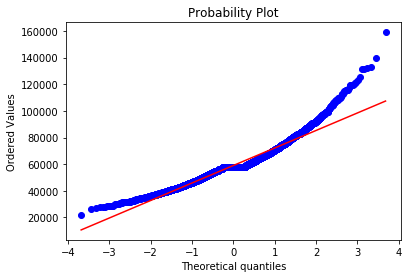

-------------------- 
Check for normal distribution:
 --------------------
Skewedness: 1.0504
Kurtosis: 2.8003
Overview of variable:  gspd 


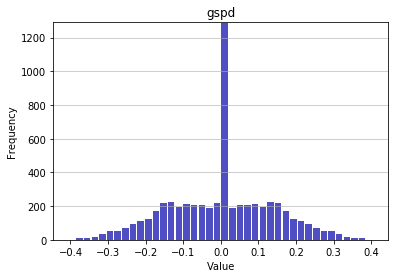

-------------------- 
Summary statistics:
 --------------------
Minimum value: -0.40627580511973577
Mean: 0.0
Standard deviation: 0.1367
Median: 0.0
Maximal value: 0.40627580511973577


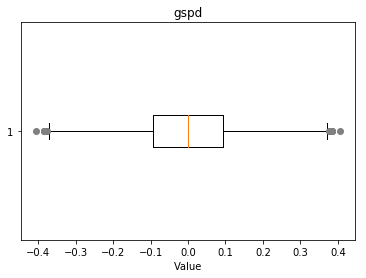

-------------------- 
Outlier detection:
 --------------------
List of outliers: set()


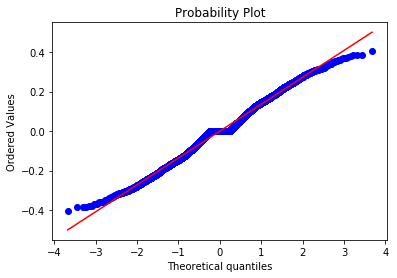

-------------------- 
Check for normal distribution:
 --------------------
Skewedness: 0.0
Kurtosis: -0.192
Overview of variable:  minionkills 


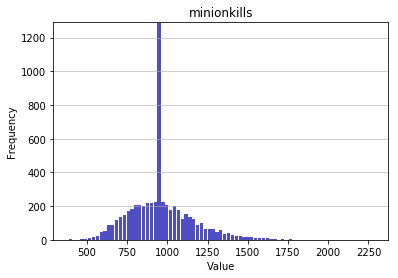

-------------------- 
Summary statistics:
 --------------------
Minimum value: 385.0
Mean: 961.1207
Standard deviation: 198.0223
Median: 944.0
Maximal value: 2280.0


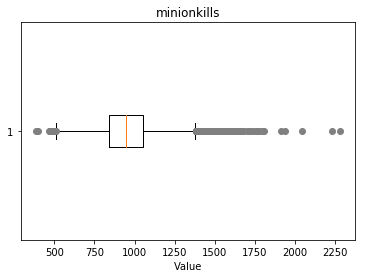

-------------------- 
Outlier detection:
 --------------------
List of outliers: {1793.0, 1666.0, 1804.0, 1678.0, 1682.0, 1938.0, 1558.0, 1560.0, 1561.0, 1568.0, 1570.0, 1573.0, 1576.0, 1705.0, 1708.0, 1709.0, 1710.0, 1711.0, 1584.0, 1586.0, 1588.0, 2230.0, 1591.0, 1719.0, 1594.0, 1597.0, 1599.0, 1601.0, 1603.0, 1735.0, 1608.0, 1611.0, 1612.0, 1615.0, 1617.0, 1618.0, 1619.0, 1621.0, 1623.0, 1754.0, 1627.0, 1628.0, 1631.0, 1760.0, 1633.0, 1632.0, 1763.0, 2280.0, 1643.0, 1775.0, 1649.0, 1650.0, 1910.0, 1655.0, 2042.0}


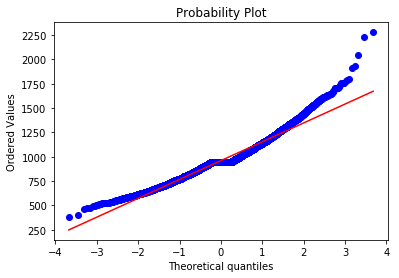

-------------------- 
Check for normal distribution:
 --------------------
Skewedness: 0.8219
Kurtosis: 1.8633
Overview of variable:  monsterkills 


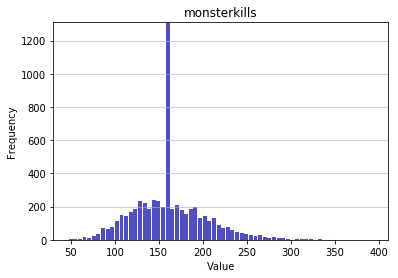

-------------------- 
Summary statistics:
 --------------------
Minimum value: 47.0
Mean: 161.4791
Standard deviation: 40.9241
Median: 158.0
Maximal value: 394.0


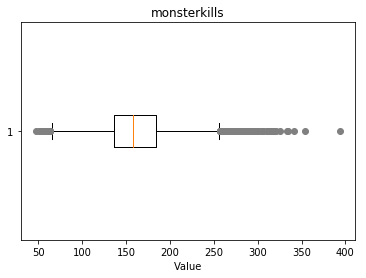

-------------------- 
Outlier detection:
 --------------------
List of outliers: {394.0, 285.0, 287.0, 288.0, 289.0, 290.0, 291.0, 292.0, 293.0, 294.0, 295.0, 298.0, 299.0, 301.0, 305.0, 306.0, 311.0, 314.0, 315.0, 317.0, 318.0, 319.0, 321.0, 325.0, 333.0, 335.0, 341.0, 354.0}


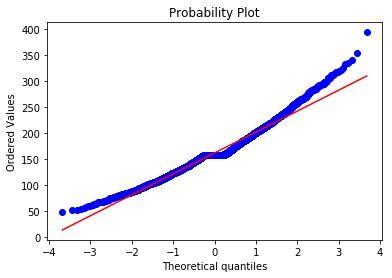

-------------------- 
Check for normal distribution:
 --------------------
Skewedness: 0.6065
Kurtosis: 1.0171
Overview of variable:  monsterkillsownjungle 


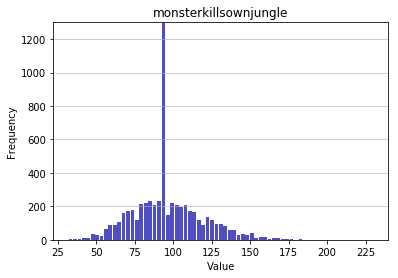

-------------------- 
Summary statistics:
 --------------------
Minimum value: 32.0
Mean: 96.788
Standard deviation: 22.5359
Median: 95.0
Maximal value: 230.0


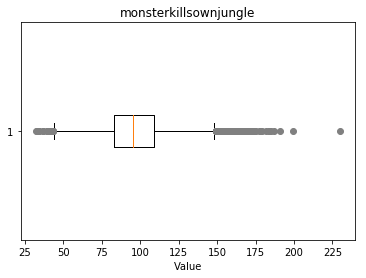

-------------------- 
Outlier detection:
 --------------------
List of outliers: {165.0, 166.0, 167.0, 199.0, 168.0, 170.0, 230.0, 172.0, 173.0, 174.0, 175.0, 171.0, 178.0, 179.0, 182.0, 184.0, 185.0, 187.0, 191.0}


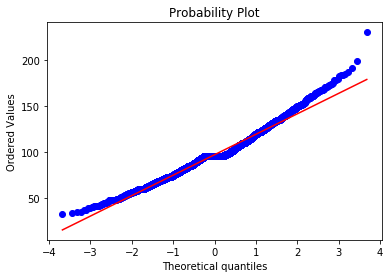

-------------------- 
Check for normal distribution:
 --------------------
Skewedness: 0.5229
Kurtosis: 0.8523
Overview of variable:  monsterkillsenemyjungle 


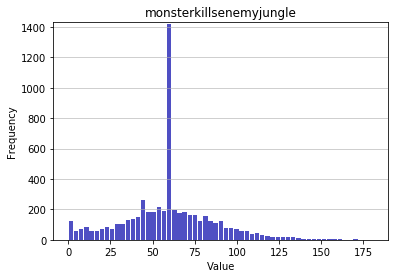

-------------------- 
Summary statistics:
 --------------------
Minimum value: 0.0
Mean: 59.5277
Standard deviation: 26.9901
Median: 59.0
Maximal value: 181.0


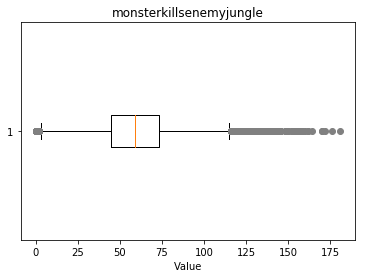

-------------------- 
Outlier detection:
 --------------------
List of outliers: {141.0, 142.0, 143.0, 144.0, 145.0, 146.0, 148.0, 149.0, 150.0, 152.0, 153.0, 154.0, 155.0, 156.0, 157.0, 158.0, 159.0, 160.0, 162.0, 164.0, 170.0, 172.0, 176.0, 181.0}


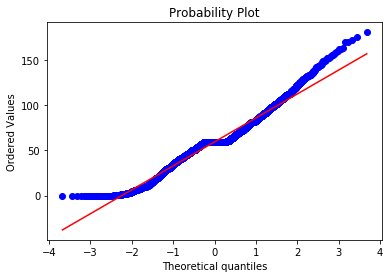

-------------------- 
Check for normal distribution:
 --------------------
Skewedness: 0.3601
Kurtosis: 0.9605
Overview of variable:  cspm 


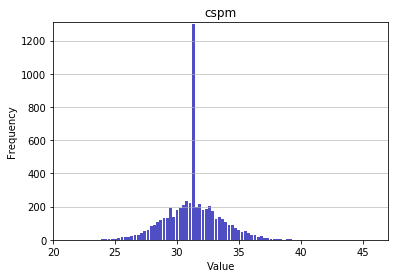

-------------------- 
Summary statistics:
 --------------------
Minimum value: 21.239288068556363
Mean: 31.2924
Standard deviation: 2.1609
Median: 31.265
Maximal value: 45.850476668339184


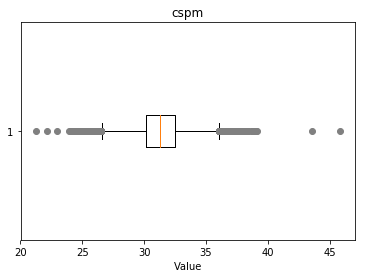

-------------------- 
Outlier detection:
 --------------------
List of outliers: {21.24, 22.98, 23.9, 24.76, 24.73, 24.37, 24.56, 24.22, 24.64, 24.68, 24.72, 24.06, 24.14, 37.87, 38.85, 38.29, 38.6, 38.06, 38.18, 38.24, 38.84, 43.56, 38.11, 45.85, 39.06, 37.84, 37.82, 38.19, 38.41, 38.23, 38.37, 39.09, 22.15}


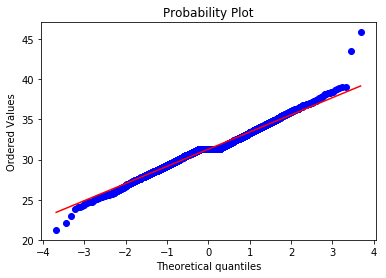

-------------------- 
Check for normal distribution:
 --------------------
Skewedness: 0.1016
Kurtosis: 1.1896
Overview of variable:  goldat10 


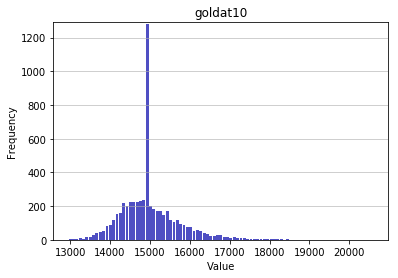

-------------------- 
Summary statistics:
 --------------------
Minimum value: 12957.0
Mean: 14997.3196
Standard deviation: 747.1763
Median: 14896.5
Maximal value: 20599.0


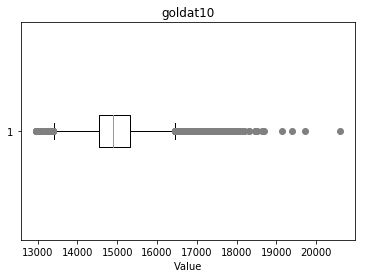

-------------------- 
Outlier detection:
 --------------------
List of outliers: {19716.0, 17669.0, 18182.0, 17287.0, 18696.0, 17540.0, 17422.0, 17423.0, 17296.0, 17679.0, 17555.0, 17301.0, 18453.0, 17430.0, 17305.0, 17310.0, 17570.0, 18086.0, 17704.0, 17579.0, 17709.0, 17326.0, 17711.0, 17327.0, 17587.0, 17460.0, 17845.0, 17846.0, 19381.0, 19129.0, 17338.0, 17978.0, 17465.0, 17977.0, 17598.0, 18497.0, 18498.0, 17349.0, 17991.0, 17735.0, 17607.0, 17481.0, 17356.0, 17868.0, 17741.0, 17489.0, 17873.0, 18515.0, 18644.0, 17363.0, 17365.0, 17753.0, 17627.0, 17628.0, 17499.0, 17246.0, 17375.0, 17889.0, 18018.0, 17379.0, 17381.0, 17255.0, 17767.0, 18155.0, 17517.0, 17390.0, 17394.0, 17272.0, 18038.0, 20599.0, 17528.0, 18298.0, 18299.0, 17790.0}


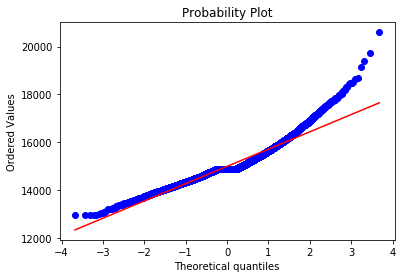

-------------------- 
Check for normal distribution:
 --------------------
Skewedness: 1.1184
Kurtosis: 2.9962
Overview of variable:  gdat10 


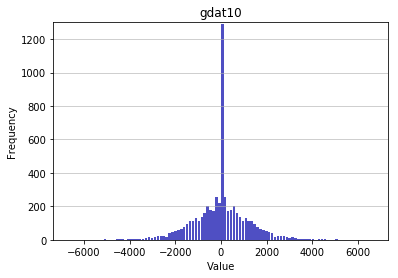

-------------------- 
Summary statistics:
 --------------------
Minimum value: -6674.0
Mean: 0.0
Standard deviation: 1180.8824
Median: 0.0
Maximal value: 6674.0


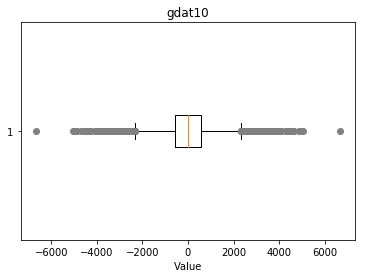

-------------------- 
Outlier detection:
 --------------------
List of outliers: {4096.0, -4096.0, 4866.0, 3842.0, -3839.0, -3706.0, -3959.0, -3955.0, 3599.0, -3568.0, 3856.0, 6674.0, 3860.0, 5012.0, 4246.0, -3561.0, -3944.0, 4503.0, -4324.0, -3810.0, -3938.0, -3548.0, 3877.0, 5033.0, -3543.0, -4562.0, -4432.0, 3635.0, -3789.0, 4533.0, -3782.0, 4412.0, 4030.0, 4671.0, 3776.0, -4671.0, -3776.0, -4030.0, 4034.0, -4034.0, 3782.0, -4412.0, -4533.0, -3635.0, 3789.0, 4432.0, 4562.0, -5033.0, 3543.0, -3877.0, 3548.0, 3810.0, 3938.0, 4324.0, 3944.0, 3561.0, -4246.0, -4503.0, -3860.0, -5012.0, -6674.0, 3568.0, -3599.0, -3856.0, 3955.0, -3842.0, 3959.0, 3706.0, -4866.0, 3839.0}


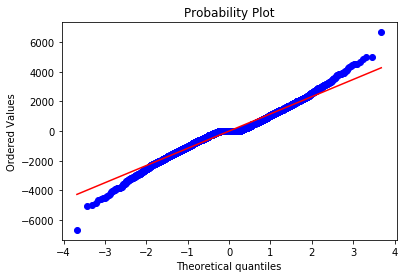

-------------------- 
Check for normal distribution:
 --------------------
Skewedness: 0.0
Kurtosis: 1.7643
Overview of variable:  goldat15 


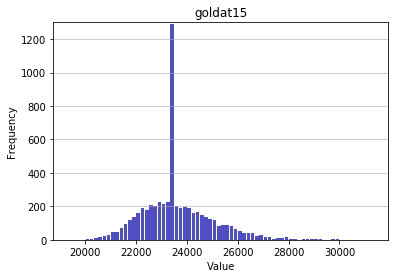

-------------------- 
Summary statistics:
 --------------------
Minimum value: 19336.0
Mean: 23617.3834
Standard deviation: 1376.2956
Median: 23477.0
Maximal value: 31333.0


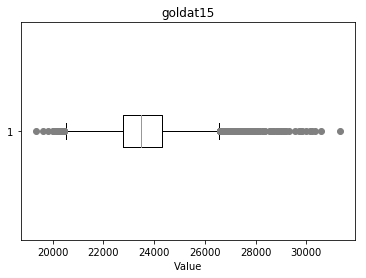

-------------------- 
Outlier detection:
 --------------------
List of outliers: {29312.0, 27776.0, 28930.0, 28034.0, 28291.0, 28679.0, 19336.0, 28680.0, 28298.0, 29067.0, 30344.0, 29838.0, 28560.0, 28049.0, 28817.0, 28563.0, 29716.0, 28178.0, 30228.0, 28316.0, 28573.0, 27933.0, 29215.0, 28834.0, 27942.0, 29991.0, 27819.0, 27948.0, 27825.0, 27827.0, 27959.0, 27961.0, 27835.0, 27841.0, 28103.0, 28873.0, 27979.0, 29772.0, 30162.0, 27858.0, 29010.0, 28640.0, 27873.0, 28004.0, 31333.0, 30566.0, 28390.0, 29545.0, 27884.0, 28013.0, 27887.0, 28016.0, 29168.0, 28018.0, 27892.0, 27766.0}


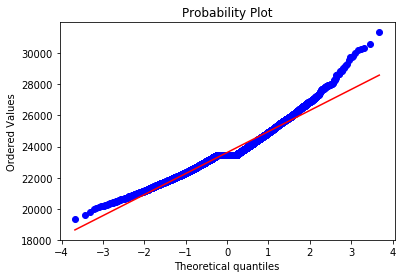

-------------------- 
Check for normal distribution:
 --------------------
Skewedness: 0.746
Kurtosis: 1.5085
Overview of variable:  gdat15 


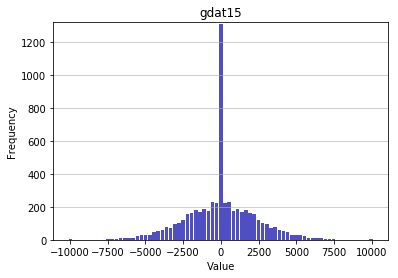

-------------------- 
Summary statistics:
 --------------------
Minimum value: -10097.0
Mean: 0.0
Standard deviation: 2308.2534
Median: 0.0
Maximal value: 10097.0


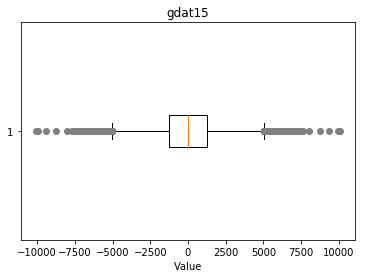

-------------------- 
Outlier detection:
 --------------------
List of outliers: {-7292.0, -9976.0, -7415.0, -7154.0, -10097.0, -7662.0, 7064.0, -7015.0, 7449.0, 6940.0, -8035.0, 8741.0, -7380.0, 9388.0, -7507.0, 7343.0, 7344.0, 7217.0, -6984.0, 6984.0, -7217.0, -7344.0, -7343.0, 7507.0, 7380.0, -9388.0, -8741.0, 8035.0, -6940.0, 7015.0, -7064.0, -7449.0, 7662.0, 10097.0, 7154.0, 7415.0, 9976.0, 7292.0}


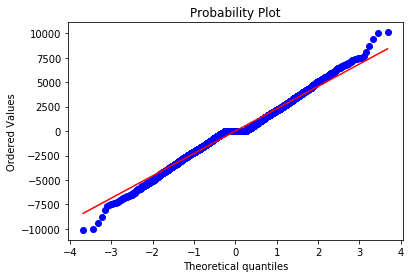

-------------------- 
Check for normal distribution:
 --------------------
Skewedness: 0.0
Kurtosis: 0.9653
Overview of variable:  xpat10 


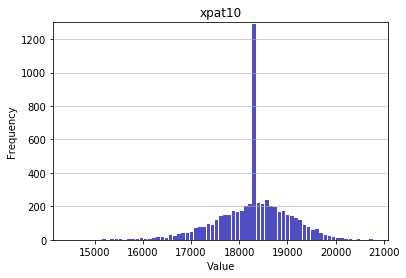

-------------------- 
Summary statistics:
 --------------------
Minimum value: 14456.0
Mean: 18305.889
Standard deviation: 723.7931
Median: 18348.0
Maximal value: 20784.0


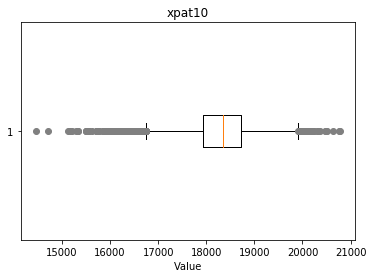

-------------------- 
Outlier detection:
 --------------------
List of outliers: {15745.0, 15873.0, 16004.0, 15495.0, 16008.0, 15880.0, 15626.0, 15496.0, 15501.0, 15758.0, 16016.0, 20496.0, 15890.0, 15128.0, 20634.0, 16029.0, 15774.0, 20767.0, 15519.0, 20518.0, 15915.0, 15918.0, 20784.0, 16050.0, 16051.0, 15924.0, 15286.0, 15169.0, 15939.0, 15559.0, 15824.0, 15568.0, 15957.0, 15960.0, 15962.0, 15715.0, 16100.0, 15973.0, 15208.0, 15976.0, 15339.0, 15724.0, 15982.0, 15727.0, 15999.0, 14704.0, 15730.0, 15343.0, 16116.0, 14456.0, 15737.0, 15743.0}


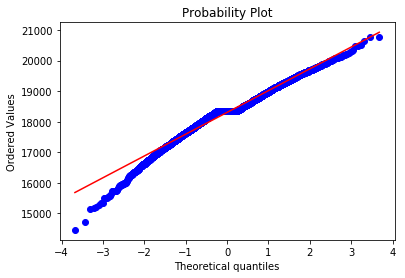

-------------------- 
Check for normal distribution:
 --------------------
Skewedness: -0.5071
Kurtosis: 1.2506
Overview of variable:  xpdat10 


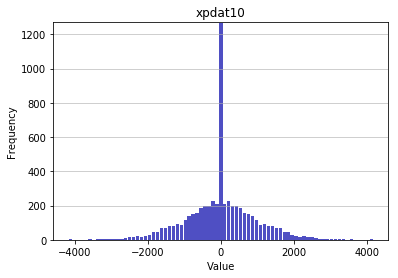

-------------------- 
Summary statistics:
 --------------------
Minimum value: -4168.0
Mean: 0.0
Standard deviation: 953.0096
Median: 0.0
Maximal value: 4168.0


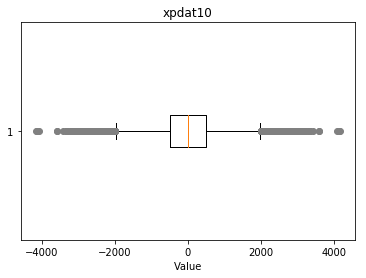

-------------------- 
Outlier detection:
 --------------------
List of outliers: {-3584.0, 3584.0, 3586.0, -4088.0, -2935.0, 3341.0, 3344.0, -2927.0, -2926.0, 2963.0, 2960.0, -3044.0, -3040.0, -3165.0, -3415.0, -3030.0, 3115.0, 3244.0, -3155.0, -3026.0, -3153.0, 2861.0, 4145.0, 2995.0, -3275.0, -4168.0, -2887.0, 3131.0, -3131.0, 2887.0, 4168.0, 3275.0, -2995.0, -4145.0, 3153.0, 3026.0, 3155.0, -3244.0, -3115.0, 3030.0, 3415.0, -2861.0, 3165.0, 3040.0, 3044.0, -2963.0, 2926.0, 2927.0, -3344.0, -2960.0, -3341.0, 2935.0, 4088.0, -3586.0}


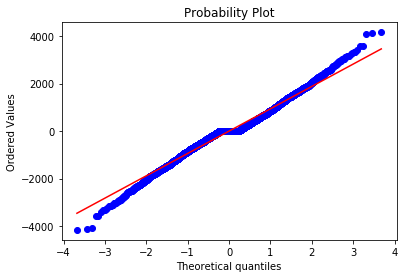

-------------------- 
Check for normal distribution:
 --------------------
Skewedness: 0.0
Kurtosis: 1.1753
Overview of variable:  csat10 


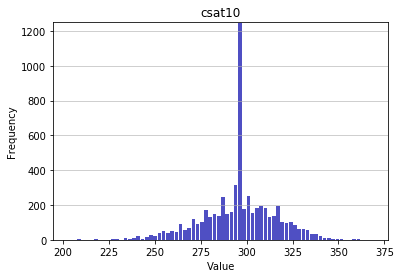

-------------------- 
Summary statistics:
 --------------------
Minimum value: 203.0
Mean: 295.7811
Standard deviation: 19.7354
Median: 296.0
Maximal value: 369.0


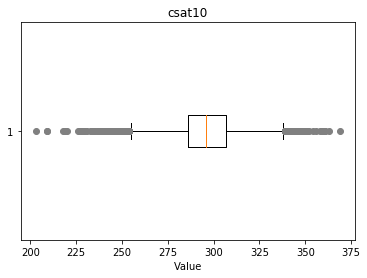

-------------------- 
Outlier detection:
 --------------------
List of outliers: {226.0, 227.0, 228.0, 356.0, 358.0, 231.0, 230.0, 233.0, 361.0, 235.0, 229.0, 363.0, 359.0, 234.0, 203.0, 209.0, 369.0, 218.0, 219.0, 220.0}


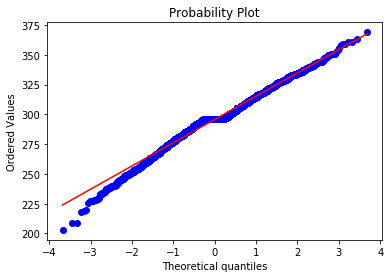

-------------------- 
Check for normal distribution:
 --------------------
Skewedness: -0.2864
Kurtosis: 0.7802
Overview of variable:  csdat10 


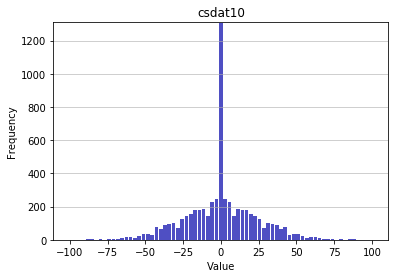

-------------------- 
Summary statistics:
 --------------------
Minimum value: -101.0
Mean: 0.0
Standard deviation: 23.4774
Median: 0.0
Maximal value: 101.0


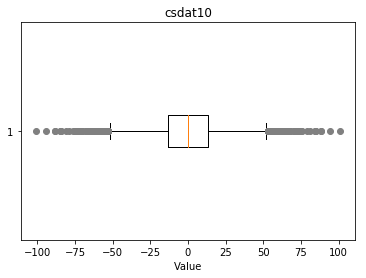

-------------------- 
Outlier detection:
 --------------------
List of outliers: {-101.0, -94.0, -88.0, -85.0, -84.0, -81.0, -79.0, -76.0, -75.0, -74.0, -73.0, -72.0, -71.0, 71.0, 72.0, 73.0, 74.0, 75.0, 76.0, 79.0, 81.0, 84.0, 85.0, 88.0, 94.0, 101.0}


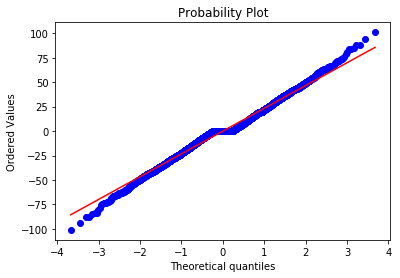

-------------------- 
Check for normal distribution:
 --------------------
Skewedness: 0.0
Kurtosis: 0.8075
Overview of variable:  csat15 


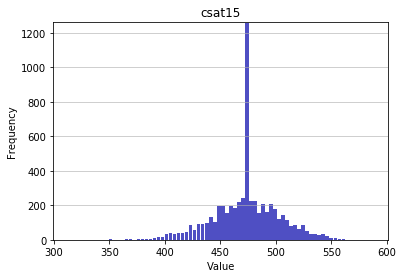

-------------------- 
Summary statistics:
 --------------------
Minimum value: 313.0
Mean: 472.8119
Standard deviation: 29.7553
Median: 473.0
Maximal value: 588.0


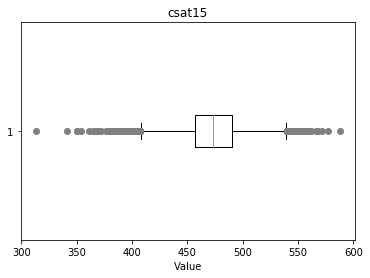

-------------------- 
Outlier detection:
 --------------------
List of outliers: {566.0, 568.0, 313.0, 572.0, 577.0, 588.0, 341.0, 350.0, 354.0, 361.0, 365.0, 366.0, 367.0, 368.0, 369.0, 372.0, 376.0, 378.0, 379.0, 380.0, 381.0, 383.0}


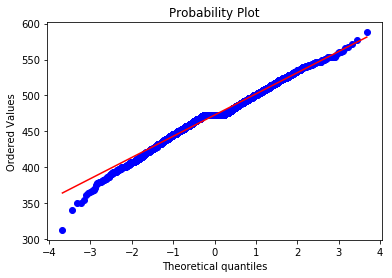

-------------------- 
Check for normal distribution:
 --------------------
Skewedness: -0.2043
Kurtosis: 0.8164
Overview of variable:  csdat15 


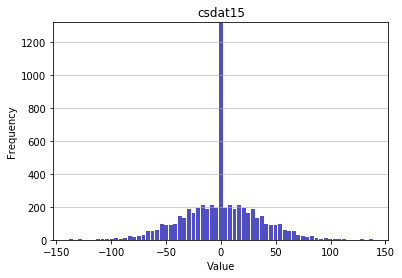

-------------------- 
Summary statistics:
 --------------------
Minimum value: -139.0
Mean: 0.0
Standard deviation: 33.2284
Median: 0.0
Maximal value: 139.0


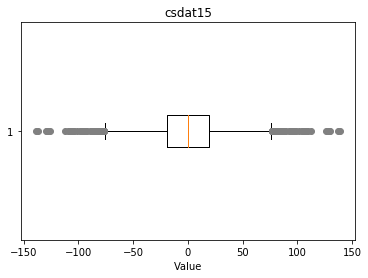

-------------------- 
Outlier detection:
 --------------------
List of outliers: {128.0, -128.0, 130.0, 129.0, -126.0, 137.0, 139.0, -112.0, -110.0, -108.0, -107.0, -106.0, -105.0, -104.0, -101.0, 101.0, 104.0, 105.0, 106.0, 107.0, 108.0, 110.0, 112.0, -139.0, -137.0, 126.0, -130.0, -129.0}


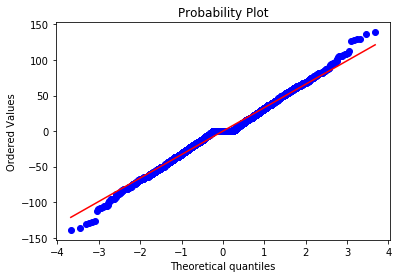

-------------------- 
Check for normal distribution:
 --------------------
Skewedness: 0.0
Kurtosis: 0.712
Overview of variable:  datediff 


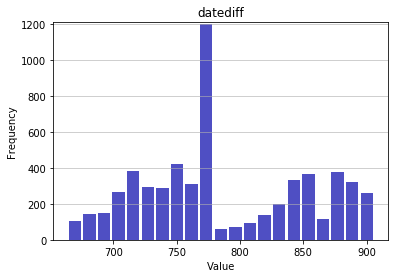

-------------------- 
Summary statistics:
 --------------------
Minimum value: 664.0
Mean: 786.4491
Standard deviation: 64.6034
Median: 768.0
Maximal value: 906.0


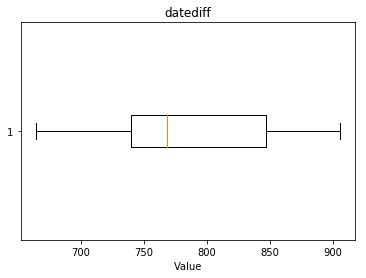

-------------------- 
Outlier detection:
 --------------------
List of outliers: set()


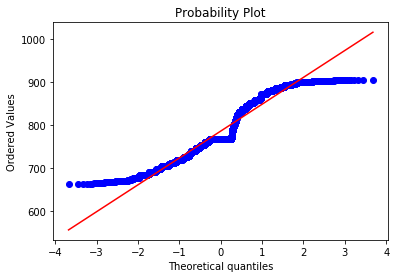

-------------------- 
Check for normal distribution:
 --------------------
Skewedness: 0.2576
Kurtosis: -1.0904
Overview of variable:  Encoded_league 


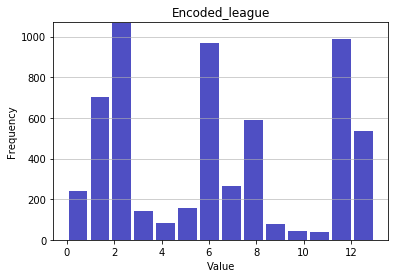

-------------------- 
Summary statistics:
 --------------------
Minimum value: 0
Mean: 6.2926
Standard deviation: 4.3442
Median: 6.0
Maximal value: 13


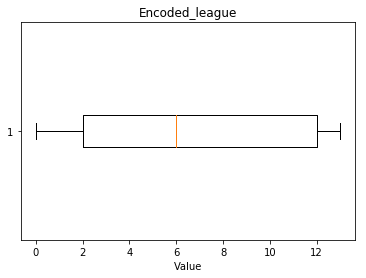

-------------------- 
Outlier detection:
 --------------------
List of outliers: set()


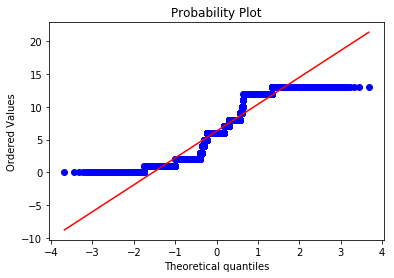

-------------------- 
Check for normal distribution:
 --------------------
Skewedness: 0.2085
Kurtosis: -1.3451
Overview of variable:  Encoded_game 


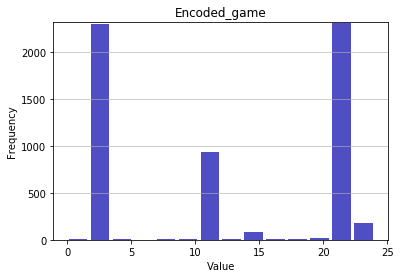

-------------------- 
Summary statistics:
 --------------------
Minimum value: 0
Mean: 11.8629
Standard deviation: 8.7166
Median: 11.0
Maximal value: 24


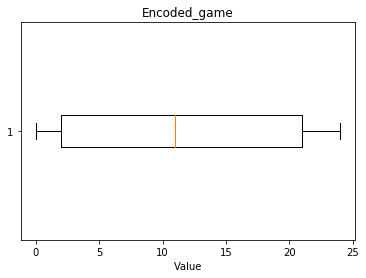

-------------------- 
Outlier detection:
 --------------------
List of outliers: set()


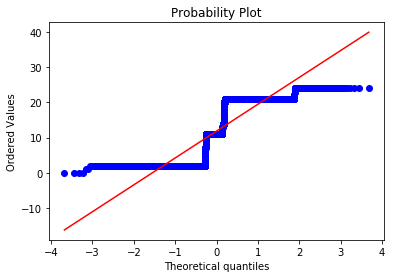

-------------------- 
Check for normal distribution:
 --------------------
Skewedness: -0.0329
Kurtosis: -1.7653
Overview of variable:  Encoded_side 


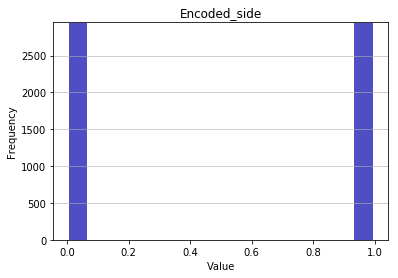

-------------------- 
Summary statistics:
 --------------------
Minimum value: 0
Mean: 0.5
Standard deviation: 0.5
Median: 0.5
Maximal value: 1


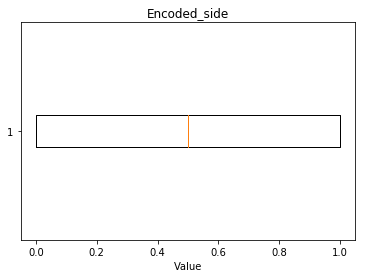

-------------------- 
Outlier detection:
 --------------------
List of outliers: set()


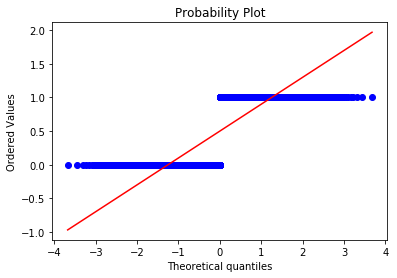

-------------------- 
Check for normal distribution:
 --------------------
Skewedness: 0.0
Kurtosis: -2.0
Overview of variable:  Encoded_ban1 


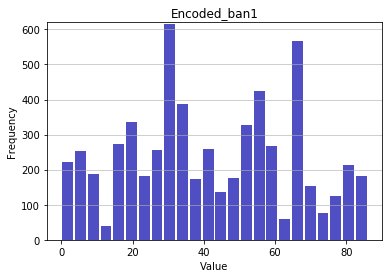

-------------------- 
Summary statistics:
 --------------------
Minimum value: 0
Mean: 41.6264
Standard deviation: 22.6198
Median: 40.0
Maximal value: 86


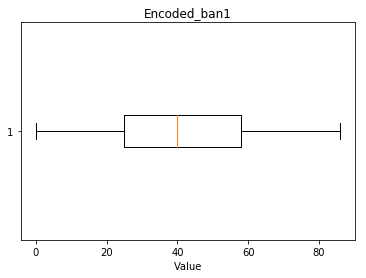

-------------------- 
Outlier detection:
 --------------------
List of outliers: set()


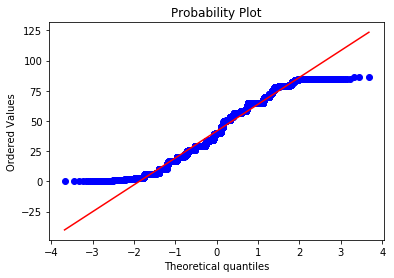

-------------------- 
Check for normal distribution:
 --------------------
Skewedness: 0.083
Kurtosis: -1.0008
Overview of variable:  Encoded_ban2 


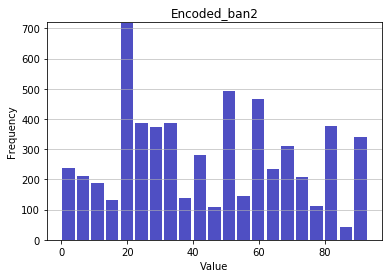

-------------------- 
Summary statistics:
 --------------------
Minimum value: 0
Mean: 44.6288
Standard deviation: 25.7642
Median: 41.0
Maximal value: 93


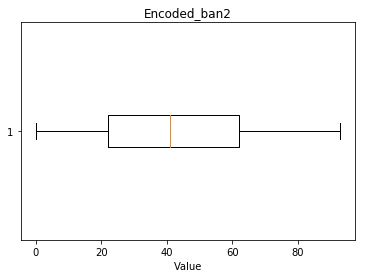

-------------------- 
Outlier detection:
 --------------------
List of outliers: set()


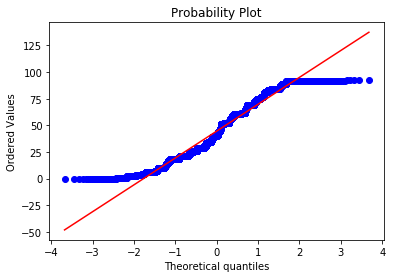

-------------------- 
Check for normal distribution:
 --------------------
Skewedness: 0.1841
Kurtosis: -1.0745
Overview of variable:  Encoded_ban3 


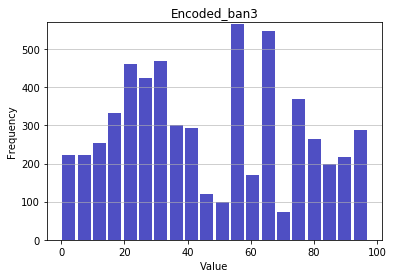

-------------------- 
Summary statistics:
 --------------------
Minimum value: 0
Mean: 46.8462
Standard deviation: 26.7843
Median: 43.0
Maximal value: 97


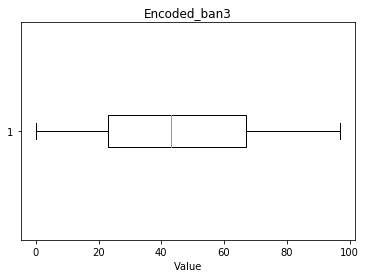

-------------------- 
Outlier detection:
 --------------------
List of outliers: set()


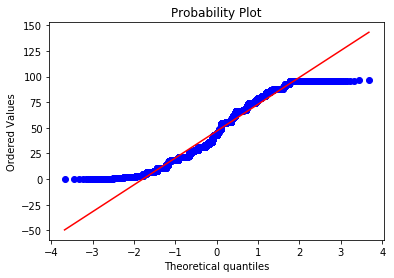

-------------------- 
Check for normal distribution:
 --------------------
Skewedness: 0.1505
Kurtosis: -1.1257
Overview of variable:  Encoded_ban4 


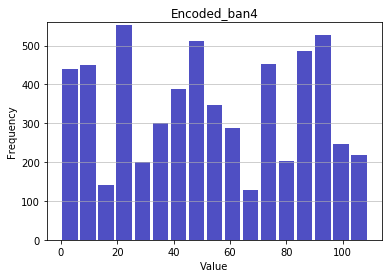

-------------------- 
Summary statistics:
 --------------------
Minimum value: 0
Mean: 52.9667
Standard deviation: 31.5768
Median: 50.0
Maximal value: 109


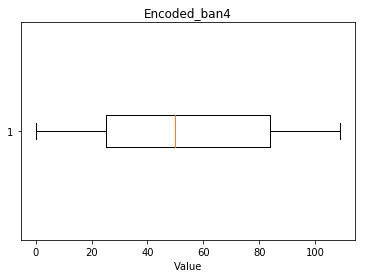

-------------------- 
Outlier detection:
 --------------------
List of outliers: set()


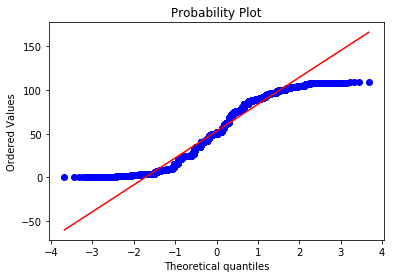

-------------------- 
Check for normal distribution:
 --------------------
Skewedness: -0.0084
Kurtosis: -1.2305
Overview of variable:  Encoded_ban5 


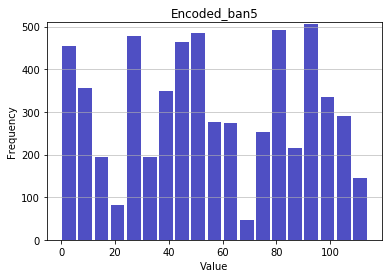

-------------------- 
Summary statistics:
 --------------------
Minimum value: 0
Mean: 55.4771
Standard deviation: 32.4997
Median: 52.0
Maximal value: 114


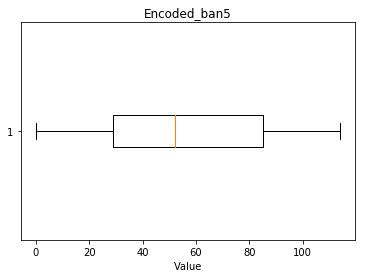

-------------------- 
Outlier detection:
 --------------------
List of outliers: set()


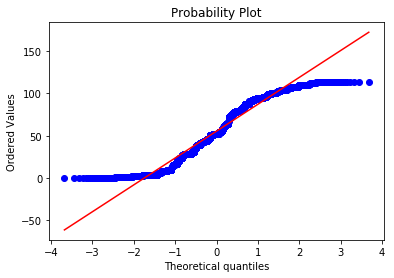

-------------------- 
Check for normal distribution:
 --------------------
Skewedness: -0.0284
Kurtosis: -1.1753
Overview of variable:  Encoded_result 


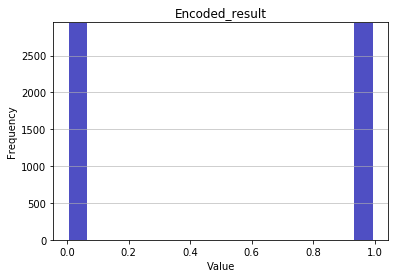

-------------------- 
Summary statistics:
 --------------------
Minimum value: 0
Mean: 0.5
Standard deviation: 0.5
Median: 0.5
Maximal value: 1


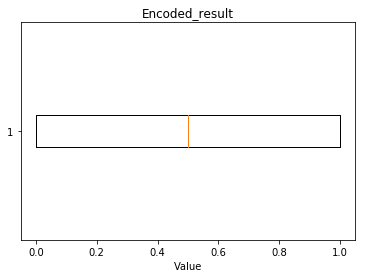

-------------------- 
Outlier detection:
 --------------------
List of outliers: set()


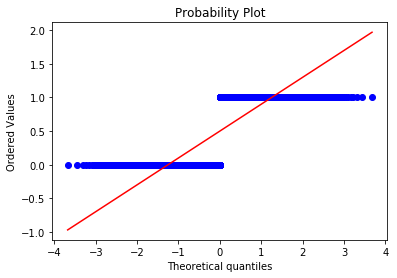

-------------------- 
Check for normal distribution:
 --------------------
Skewedness: 0.0
Kurtosis: -2.0
Overview of variable:  Encoded_fb 


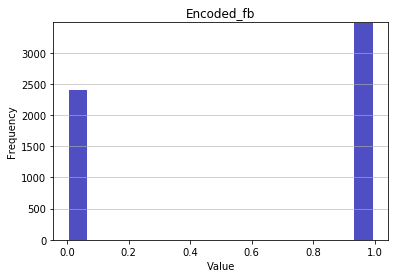

-------------------- 
Summary statistics:
 --------------------
Minimum value: 0
Mean: 0.5906
Standard deviation: 0.4918
Median: 1.0
Maximal value: 1


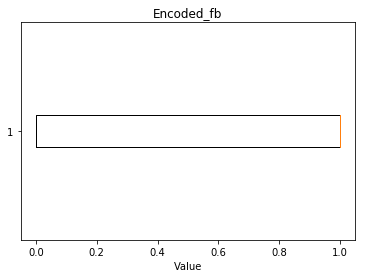

-------------------- 
Outlier detection:
 --------------------
List of outliers: set()


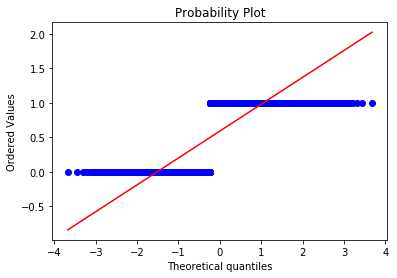

-------------------- 
Check for normal distribution:
 --------------------
Skewedness: -0.3686
Kurtosis: -1.8641
Overview of variable:  Encoded_fbassist 


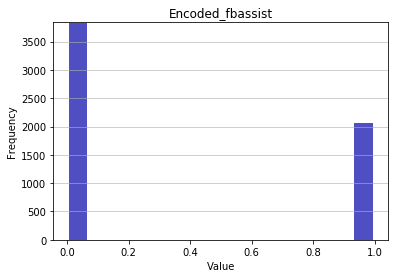

-------------------- 
Summary statistics:
 --------------------
Minimum value: 0.0
Mean: 0.3489
Standard deviation: 0.4767
Median: 0.0
Maximal value: 1.0


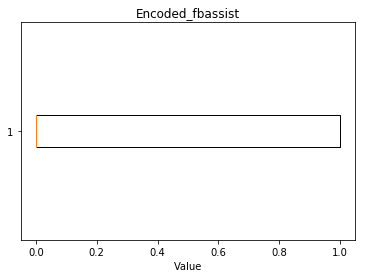

-------------------- 
Outlier detection:
 --------------------
List of outliers: set()


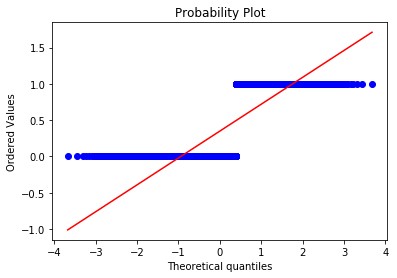

-------------------- 
Check for normal distribution:
 --------------------
Skewedness: 0.6338
Kurtosis: -1.5983
Overview of variable:  Encoded_fbvictim 


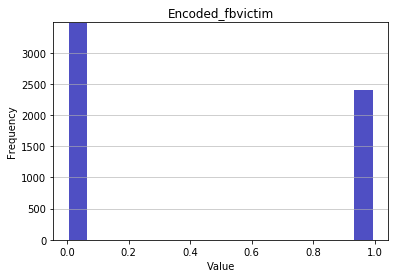

-------------------- 
Summary statistics:
 --------------------
Minimum value: 0
Mean: 0.4094
Standard deviation: 0.4918
Median: 0.0
Maximal value: 1


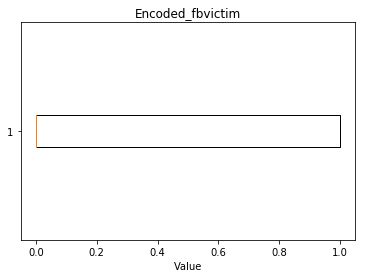

-------------------- 
Outlier detection:
 --------------------
List of outliers: set()


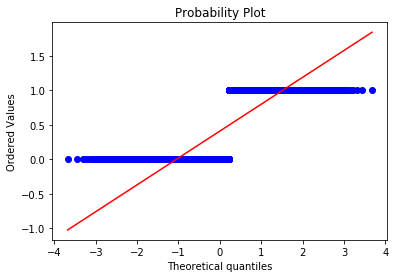

-------------------- 
Check for normal distribution:
 --------------------
Skewedness: 0.3686
Kurtosis: -1.8641
Overview of variable:  Encoded_fd 


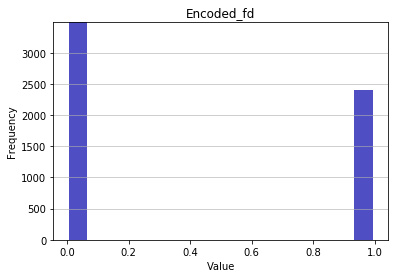

-------------------- 
Summary statistics:
 --------------------
Minimum value: 0
Mean: 0.408
Standard deviation: 0.4915
Median: 0.0
Maximal value: 1


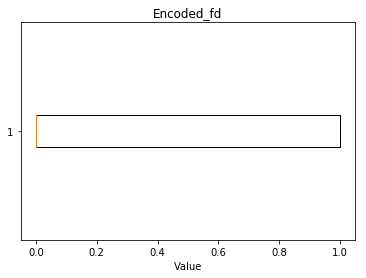

-------------------- 
Outlier detection:
 --------------------
List of outliers: set()


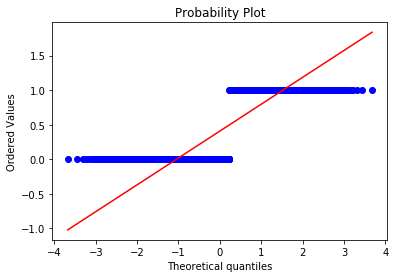

-------------------- 
Check for normal distribution:
 --------------------
Skewedness: 0.3743
Kurtosis: -1.8599
Overview of variable:  Encoded_ft 


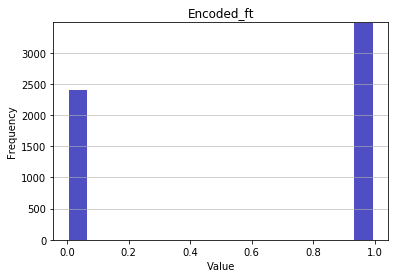

-------------------- 
Summary statistics:
 --------------------
Minimum value: 0.0
Mean: 0.5906
Standard deviation: 0.4918
Median: 1.0
Maximal value: 1.0


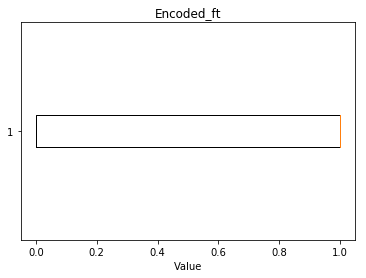

-------------------- 
Outlier detection:
 --------------------
List of outliers: set()


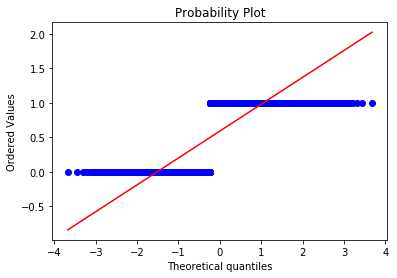

-------------------- 
Check for normal distribution:
 --------------------
Skewedness: -0.3686
Kurtosis: -1.8641
Overview of variable:  Encoded_firstmidouter 


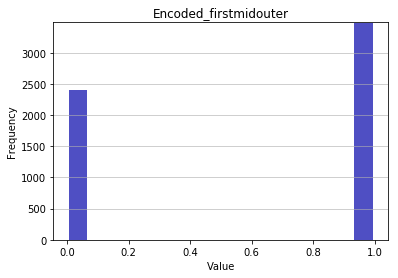

-------------------- 
Summary statistics:
 --------------------
Minimum value: 0.0
Mean: 0.5906
Standard deviation: 0.4918
Median: 1.0
Maximal value: 1.0


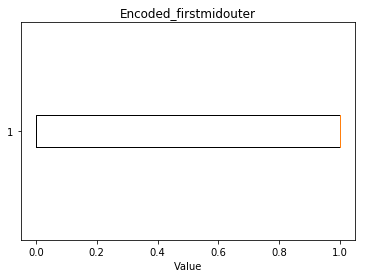

-------------------- 
Outlier detection:
 --------------------
List of outliers: set()


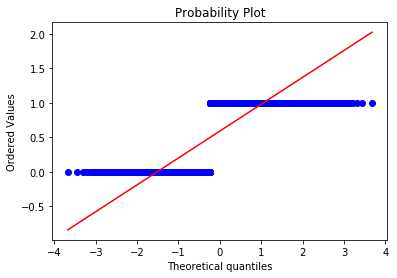

-------------------- 
Check for normal distribution:
 --------------------
Skewedness: -0.3686
Kurtosis: -1.8641
Overview of variable:  Encoded_firsttothreetowers 


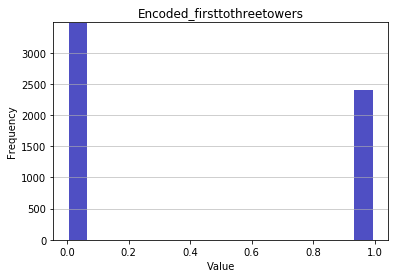

-------------------- 
Summary statistics:
 --------------------
Minimum value: 0.0
Mean: 0.4094
Standard deviation: 0.4918
Median: 0.0
Maximal value: 1.0


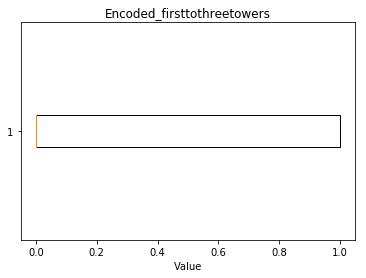

-------------------- 
Outlier detection:
 --------------------
List of outliers: set()


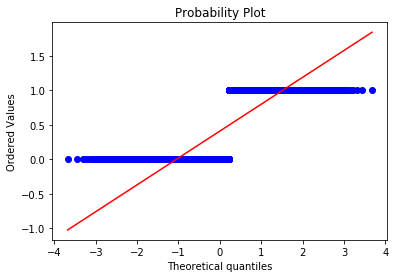

-------------------- 
Check for normal distribution:
 --------------------
Skewedness: 0.3686
Kurtosis: -1.8641
Overview of variable:  Encoded_fbaron 


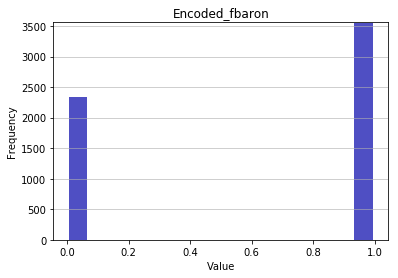

-------------------- 
Summary statistics:
 --------------------
Minimum value: 0.0
Mean: 0.6034
Standard deviation: 0.4892
Median: 1.0
Maximal value: 1.0


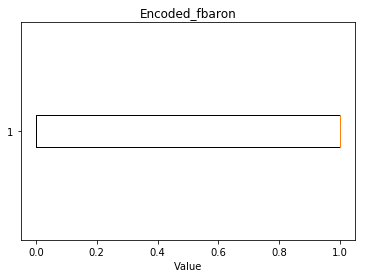

-------------------- 
Outlier detection:
 --------------------
List of outliers: set()


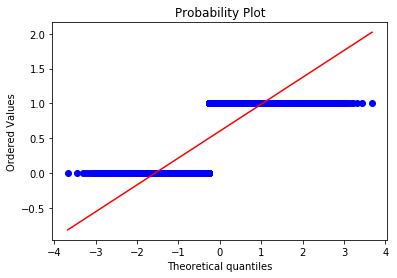

-------------------- 
Check for normal distribution:
 --------------------
Skewedness: -0.4226
Kurtosis: -1.8214
Overview of variable:  Encoded_Year 


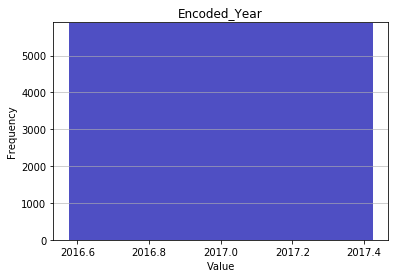

-------------------- 
Summary statistics:
 --------------------
Minimum value: 2017
Mean: 2017
Standard deviation: 0.0
Median: 2017.0
Maximal value: 2017


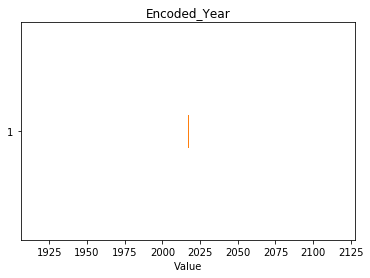

-------------------- 
Outlier detection:
 --------------------
List of outliers: set()


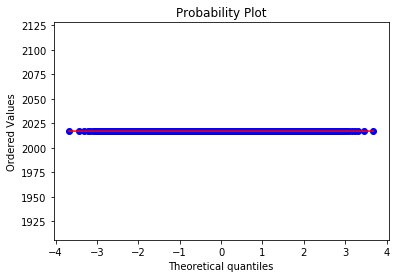

-------------------- 
Check for normal distribution:
 --------------------
Skewedness: 0.0
Kurtosis: -3.0
Overview of variable:  Encoded_culture 


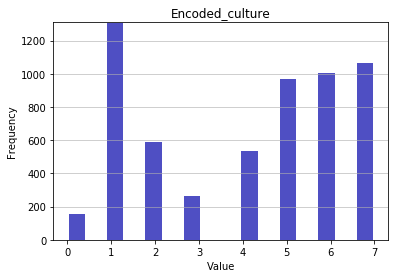

-------------------- 
Summary statistics:
 --------------------
Minimum value: 0
Mean: 4.0329
Standard deviation: 2.3113
Median: 5.0
Maximal value: 7


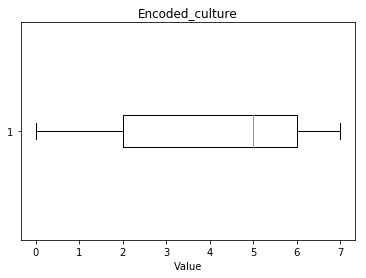

-------------------- 
Outlier detection:
 --------------------
List of outliers: set()


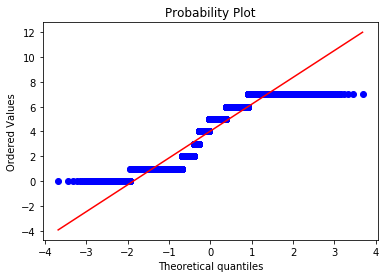

-------------------- 
Check for normal distribution:
 --------------------
Skewedness: -0.213
Kurtosis: -1.4484


<Figure size 432x288 with 0 Axes>

In [19]:
# Loop through all numerical variables and visualize data
for num_variable in numerical_variables:
    SummaryNumericVar(preprocessed_data[num_variable].dropna(), num_variable)

##### Remove irrelevant features for further analysis
* Impossible column values are removed (gamelength of zero).
* Features with zero variance were removed (because of their redundancy in further analysis).
* Extreme outliers

In [20]:
# Remove redundant features
preprocessed_data = preprocessed_data.drop(['wardshare'], axis = 1)
preprocessed_data = preprocessed_data[preprocessed_data.gamelength > 0]
preprocessed_data = preprocessed_data[preprocessed_data.datediff != 17973.0]

In [21]:
# Remove dropped features from numerical feature list
numerical_variables.remove('wardshare')

##### Reduce the influence of outliers by applying a box-cox transformation on the data
Because ridge and lasso regression are both sensitive to outlying observations, it was decided to reduce the influence of the latter by applying a box-cox transformation on the numerical features, hence transforming them in a normal shape. We refrained from removing outliers because these could capture relevant information and transformation is assumed to reduce their influence. Different lambda values underlying the exponential transformation of the data are explored [-5, 5] and the optimal value, resulting in the best approximation of the normal curve, is selected.

Feature:  split
The optimal value for lambda:  -0.2193838690396688
Feature:  gamelength
The optimal value for lambda:  -0.48545249473918706
Feature:  fbtime
The optimal value for lambda:  0.17105288945805405
Feature:  ckpm
The optimal value for lambda:  0.3151320427845525
Feature:  fdtime
The optimal value for lambda:  -0.16403796949875737
Feature:  fttime
The optimal value for lambda:  0.5479477514571383
Feature:  fbarontime
The optimal value for lambda:  -1.3872460544143768
Feature:  dmgtochamps
The optimal value for lambda:  0.008791625396460624
Feature:  dmgtochampsperminute
The optimal value for lambda:  0.5148580997698544
Feature:  wards
The optimal value for lambda:  0.0049022842049329775
Feature:  wpm
The optimal value for lambda:  0.7321962149064352
Feature:  wardkills
The optimal value for lambda:  0.36884805221877176
Feature:  wcpm
The optimal value for lambda:  0.6566277640561665
Feature:  visionwards
The optimal value for lambda:  -0.005668105030868784
Feature:  visionward

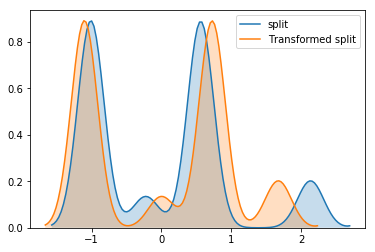

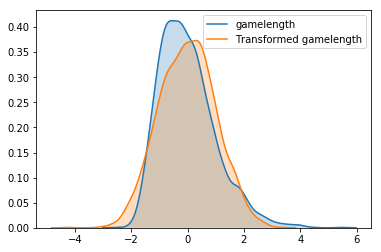

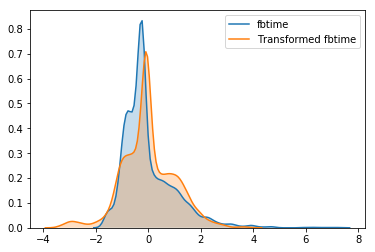

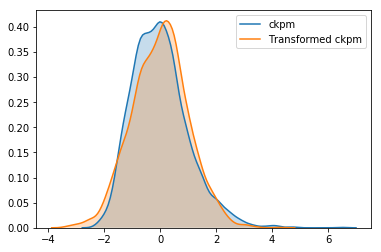

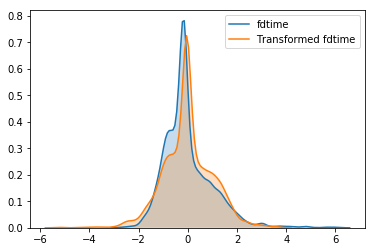

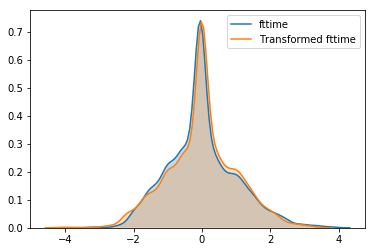

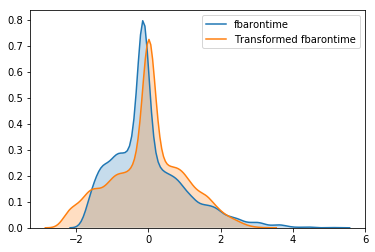

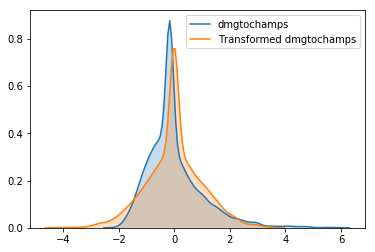

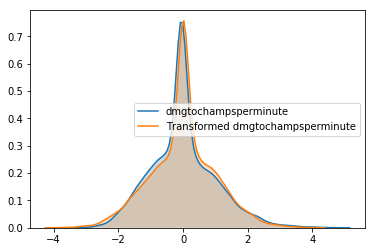

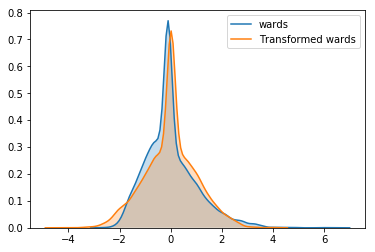

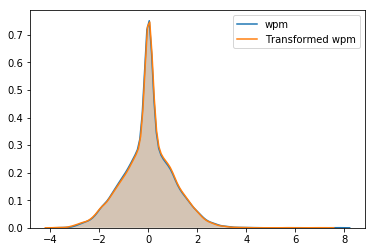

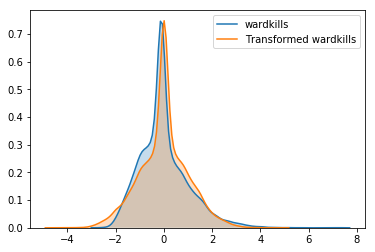

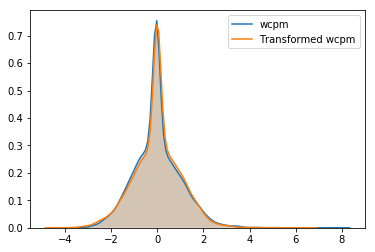

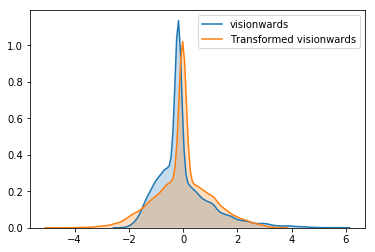

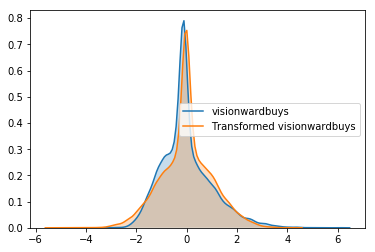

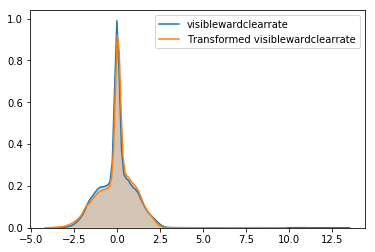

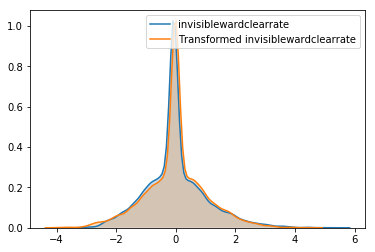

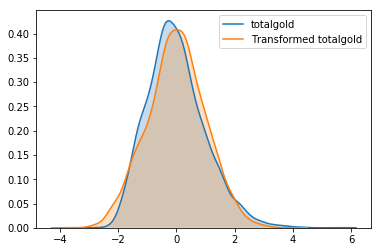

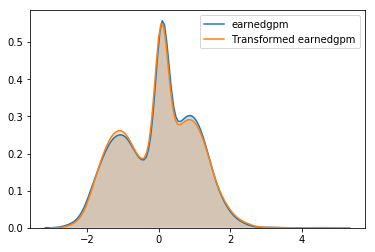

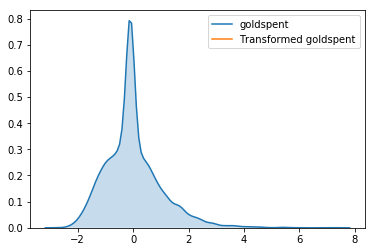

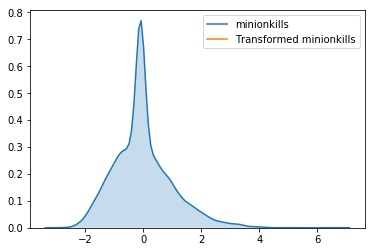

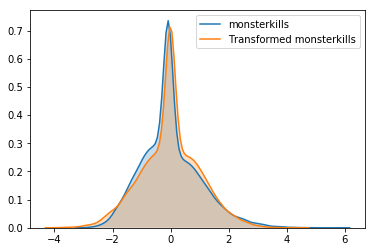

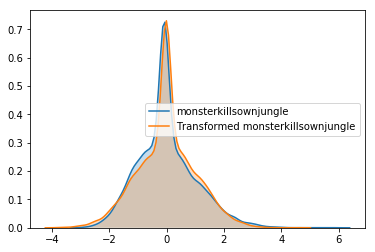

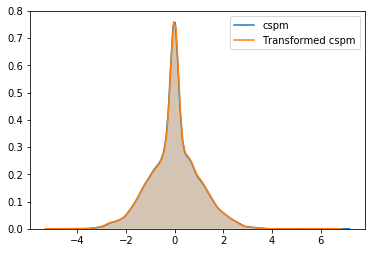

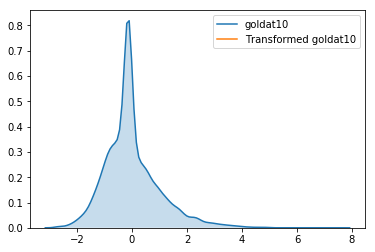

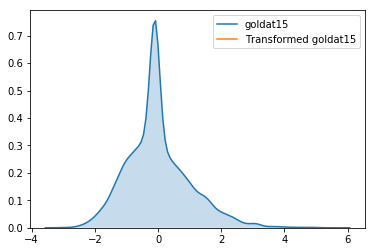

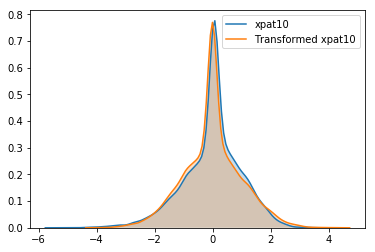

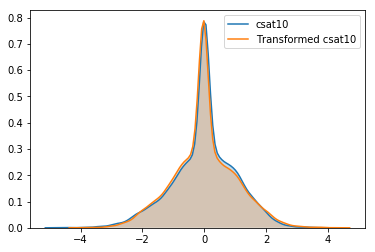

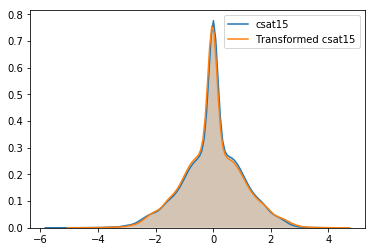

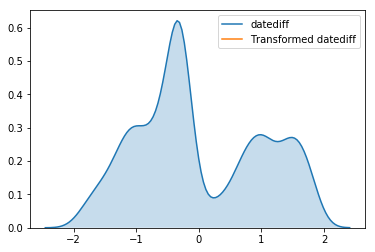

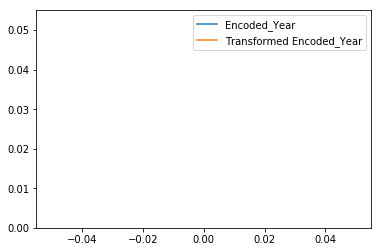

In [22]:
# Initialization
transformed_data_df, optimiser_dict = pd.DataFrame(), dict()

# Loop through the data and apply box cox transformation
for num_variable in numerical_variables:
    if all(preprocessed_data[num_variable] > 0):
        transformed_feature, optimiser = feature_transformer(preprocessed_data[num_variable], num_variable)
        if -5 <= optimiser <= 5:
            transformed_data_df[num_variable] = transformed_feature
            optimiser_dict[num_variable] = optimiser
        else:
            transformed_data_df[num_variable] = preprocessing.scale(preprocessed_data[num_variable])
            optimiser_dict[num_variable] = np.nan
    else:
        transformed_data_df[num_variable] = preprocessing.scale(preprocessed_data[num_variable])
    #transformed_data_df[num_variable], optimiser_dict[num_variable] = transformed_feature, optimiser if -5 <= optimiser <= 5 else preprocessing.scale(preprocessed_data[num_variable]), np.nan
    #if all(preprocessed_data[num_variable] > 0):
    #    transformed_data_df[num_variable], optimiser = feature_transformer(preprocessed_data[num_variable], num_variable)
    #    optimiser_dict[num_variable] = optimiser
    #else:
    #    transformed_data_df[num_variable] = preprocessing.scale(preprocessed_data[num_variable])
        
# Add team feature
transformed_data_df['team'] = list(preprocessed_data['team'])

Overview of variable:  split 


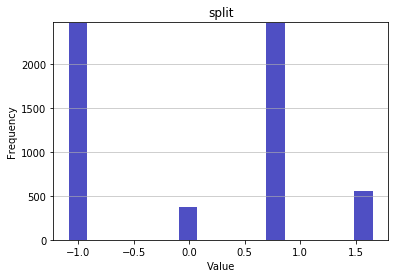

-------------------- 
Summary statistics:
 --------------------
Minimum value: -1.102808498220239
Mean: 0.0
Standard deviation: 1.0001
Median: 0.7252
Maximal value: 1.6725486923240938


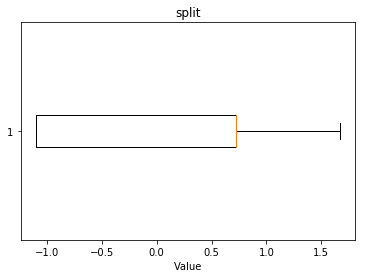

-------------------- 
Outlier detection:
 --------------------
List of outliers: set()


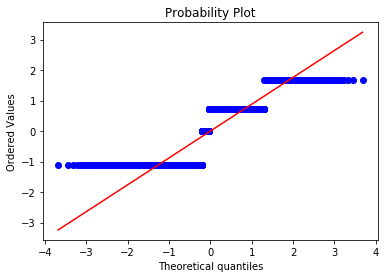

-------------------- 
Check for normal distribution:
 --------------------
Skewedness: 0.0423
Kurtosis: -1.5139
Overview of variable:  patchno 


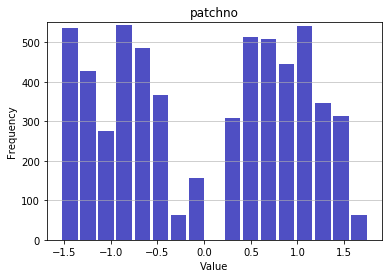

-------------------- 
Summary statistics:
 --------------------
Minimum value: -1.534414375607176
Mean: 0.0
Standard deviation: 1.0001
Median: 0.2202
Maximal value: 1.7555328103260306


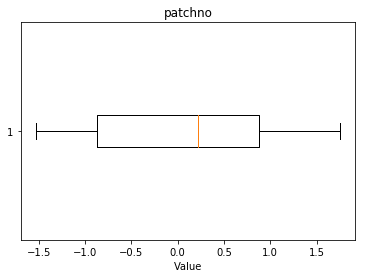

-------------------- 
Outlier detection:
 --------------------
List of outliers: set()


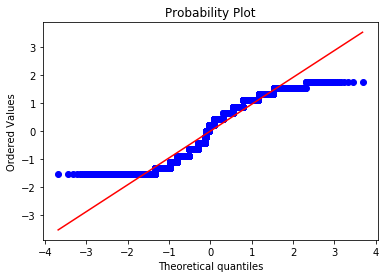

-------------------- 
Check for normal distribution:
 --------------------
Skewedness: -0.0578
Kurtosis: -1.3692
Overview of variable:  gamelength 


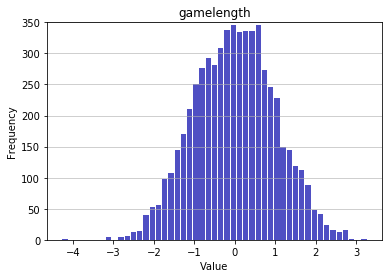

-------------------- 
Summary statistics:
 --------------------
Minimum value: -4.267262926459805
Mean: 0.0
Standard deviation: 1.0001
Median: 0.0069
Maximal value: 3.268248999281851


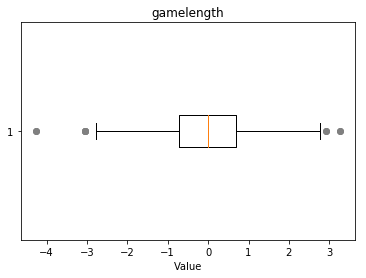

-------------------- 
Outlier detection:
 --------------------
List of outliers: {3.27, -4.27, -3.05}


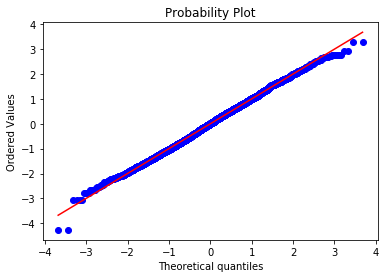

-------------------- 
Check for normal distribution:
 --------------------
Skewedness: 0.0073
Kurtosis: -0.2069
Overview of variable:  k 


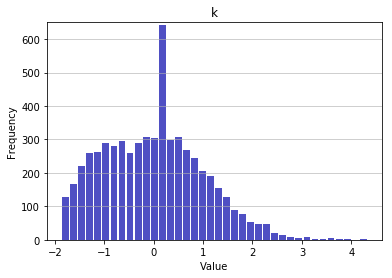

-------------------- 
Summary statistics:
 --------------------
Minimum value: -1.8603027906833105
Mean: 0.0
Standard deviation: 1.0001
Median: -0.0508
Maximal value: 4.322073424812457


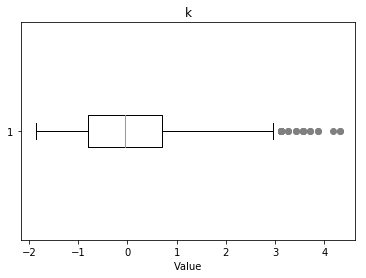

-------------------- 
Outlier detection:
 --------------------
List of outliers: {3.12, 3.27, 3.57, 3.72, 3.87, 4.32, 3.42, 4.17}


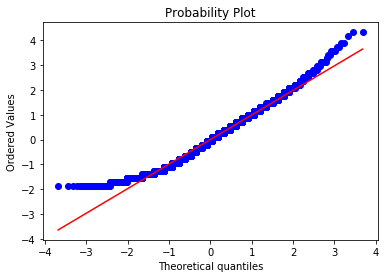

-------------------- 
Check for normal distribution:
 --------------------
Skewedness: 0.3967
Kurtosis: -0.1334
Overview of variable:  d 


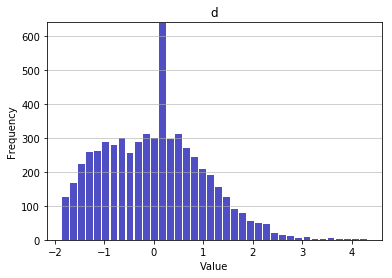

-------------------- 
Summary statistics:
 --------------------
Minimum value: -1.8612761495264256
Mean: 0.0
Standard deviation: 1.0001
Median: -0.054
Maximal value: 4.313535558275207


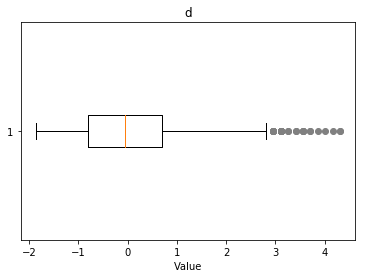

-------------------- 
Outlier detection:
 --------------------
List of outliers: {3.11, 3.56, 4.01, 3.26, 3.71, 4.31, 3.86, 3.41, 4.16}


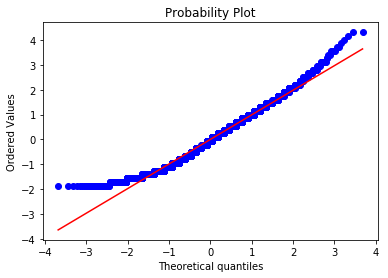

-------------------- 
Check for normal distribution:
 --------------------
Skewedness: 0.397
Kurtosis: -0.132
Overview of variable:  a 


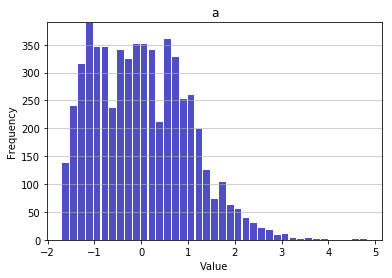

-------------------- 
Summary statistics:
 --------------------
Minimum value: -1.6967595880126718
Mean: 0.0
Standard deviation: 1.0001
Median: -0.0497
Maximal value: 4.832735165694954


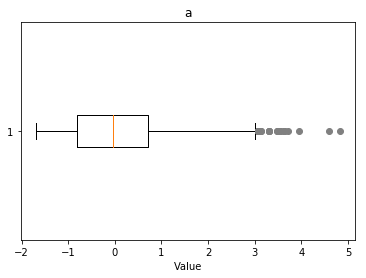

-------------------- 
Outlier detection:
 --------------------
List of outliers: {3.07, 3.66, 3.48, 3.72, 3.01, 3.54, 3.3, 3.13, 4.6, 3.95, 4.83, 3.6}


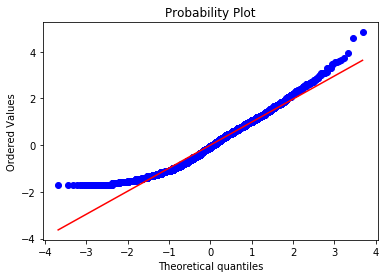

-------------------- 
Check for normal distribution:
 --------------------
Skewedness: 0.4783
Kurtosis: -0.1331
Overview of variable:  teamkills 


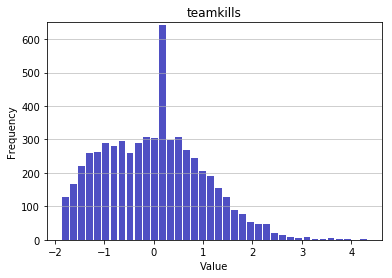

-------------------- 
Summary statistics:
 --------------------
Minimum value: -1.8603027906833105
Mean: 0.0
Standard deviation: 1.0001
Median: -0.0508
Maximal value: 4.322073424812457


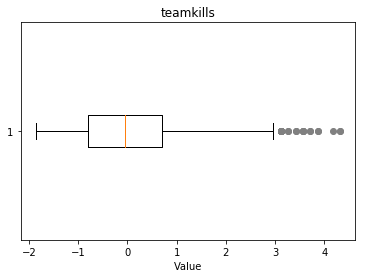

-------------------- 
Outlier detection:
 --------------------
List of outliers: {3.12, 3.27, 3.57, 3.72, 3.87, 4.32, 3.42, 4.17}


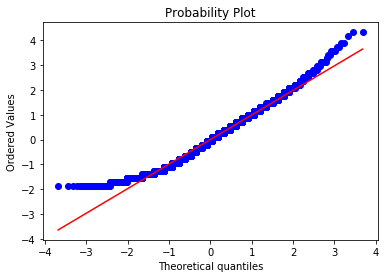

-------------------- 
Check for normal distribution:
 --------------------
Skewedness: 0.3967
Kurtosis: -0.1334
Overview of variable:  fbtime 


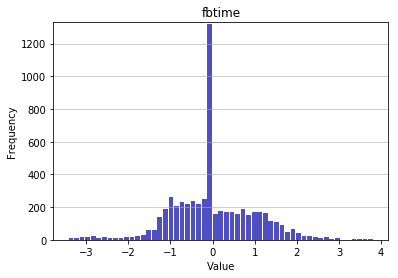

-------------------- 
Summary statistics:
 --------------------
Minimum value: -3.422308647215324
Mean: 0.0
Standard deviation: 1.0001
Median: -0.0705
Maximal value: 3.818188952716082


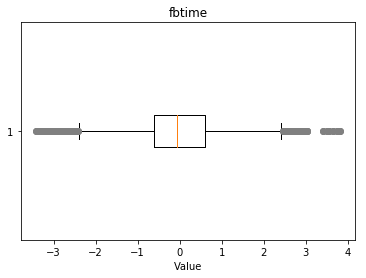

-------------------- 
Outlier detection:
 --------------------
List of outliers: {3.65, 3.82, 3.02, 3.55, 3.73, 3.42, 3.5, -3.04, -3.05, -3.13, -3.3, -3.38, -3.18, -3.28, -3.1, -3.02, -3.03, -3.19, -3.42, -3.08, -3.33, -3.24, -3.26}


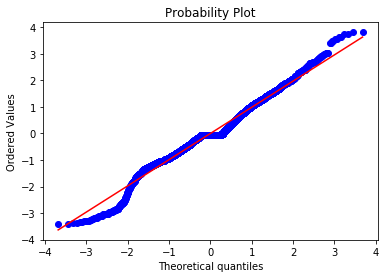

-------------------- 
Check for normal distribution:
 --------------------
Skewedness: 0.0295
Kurtosis: 0.9421
Overview of variable:  kpm 


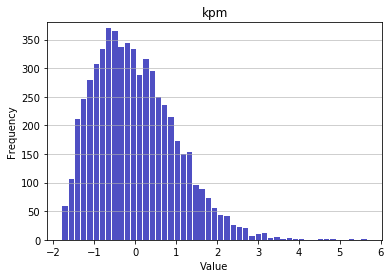

-------------------- 
Summary statistics:
 --------------------
Minimum value: -1.7914089917777158
Mean: -0.0
Standard deviation: 1.0001
Median: -0.1212
Maximal value: 5.673801372582923


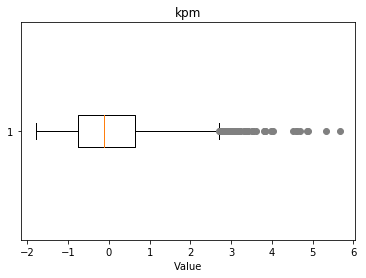

-------------------- 
Outlier detection:
 --------------------
List of outliers: {3.32, 3.54, 3.98, 4.62, 3.05, 3.1, 3.42, 3.08, 3.16, 3.14, 4.7, 5.33, 3.09, 3.83, 3.17, 3.84, 3.5, 4.6, 4.52, 3.33, 4.85, 5.67, 3.53, 3.61, 3.02, 3.35, 3.8, 4.03, 4.88, 3.23, 3.15, 3.22}


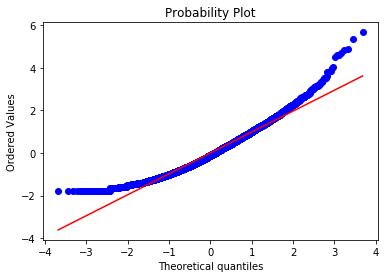

-------------------- 
Check for normal distribution:
 --------------------
Skewedness: 0.7322
Kurtosis: 0.751
Overview of variable:  ckpm 


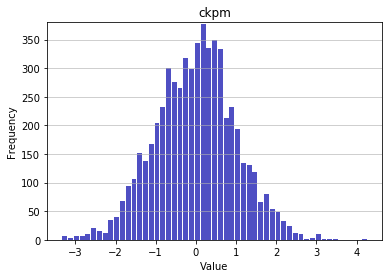

-------------------- 
Summary statistics:
 --------------------
Minimum value: -3.3322333962583603
Mean: 0.0
Standard deviation: 1.0001
Median: 0.0333
Maximal value: 4.264879017460386


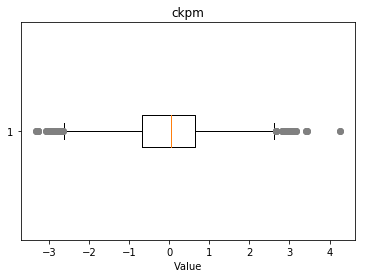

-------------------- 
Outlier detection:
 --------------------
List of outliers: {3.11, 3.07, 3.4, 3.43, 4.26, 3.03, 3.1, 3.15, -3.33, -3.28, -3.01, -3.06, -3.29, -3.08}


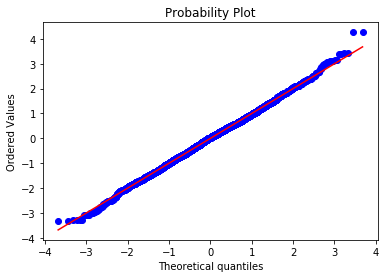

-------------------- 
Check for normal distribution:
 --------------------
Skewedness: 0.0052
Kurtosis: 0.1628
Overview of variable:  fdtime 


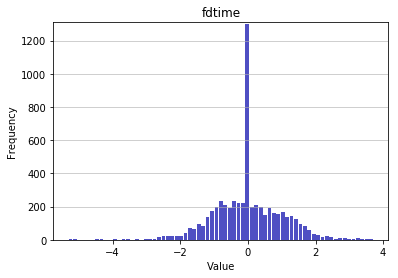

-------------------- 
Summary statistics:
 --------------------
Minimum value: -5.305631662235837
Mean: 0.0
Standard deviation: 1.0001
Median: -0.0409
Maximal value: 3.709986554764172


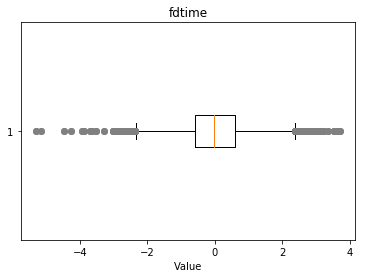

-------------------- 
Outlier detection:
 --------------------
List of outliers: {3.2, 3.65, 3.22, 3.14, 3.52, 3.24, 3.02, 3.36, 3.71, 3.07, -5.31, 3.19, -3.88, -3.63, 3.61, 3.54, -3.94, -3.28, -3.53, -3.69, 3.21, -4.48, -5.15, -4.27, -3.01}


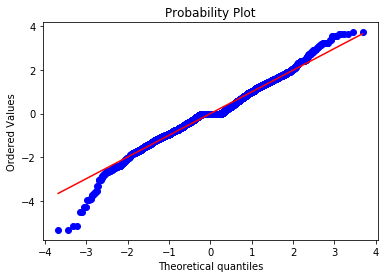

-------------------- 
Check for normal distribution:
 --------------------
Skewedness: -0.0177
Kurtosis: 1.349
Overview of variable:  teamdragkills 


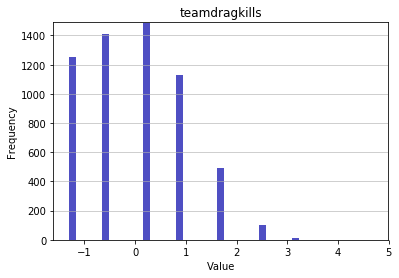

-------------------- 
Summary statistics:
 --------------------
Minimum value: -1.3237763170268593
Mean: 0.0
Standard deviation: 1.0001
Median: 0.1827
Maximal value: 4.702323761874992


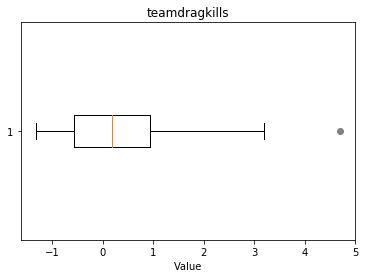

-------------------- 
Outlier detection:
 --------------------
List of outliers: {3.2, 4.7}


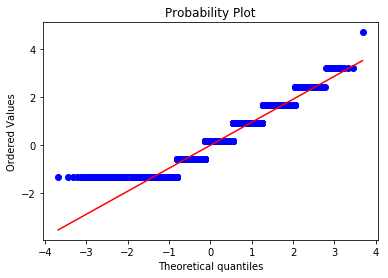

-------------------- 
Check for normal distribution:
 --------------------
Skewedness: 0.3792
Kurtosis: -0.5211
Overview of variable:  elementals 


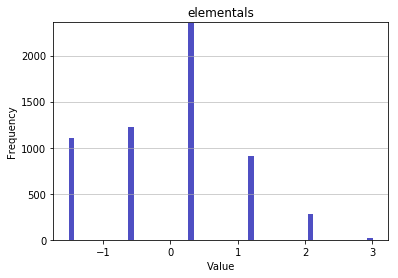

-------------------- 
Summary statistics:
 --------------------
Minimum value: -1.5154941340103696
Mean: 0.0
Standard deviation: 1.0001
Median: 0.297
Maximal value: 3.015745565667084


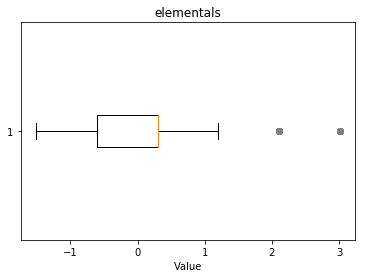

-------------------- 
Outlier detection:
 --------------------
List of outliers: {3.02}


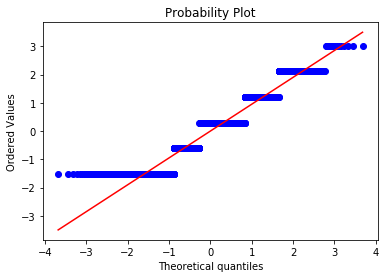

-------------------- 
Check for normal distribution:
 --------------------
Skewedness: 0.0929
Kurtosis: -0.5046
Overview of variable:  firedrakes 


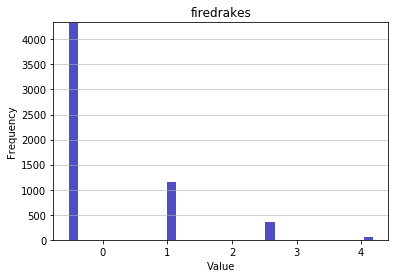

-------------------- 
Summary statistics:
 --------------------
Minimum value: -0.5405047390907252
Mean: -0.0
Standard deviation: 1.0001
Median: -0.5405
Maximal value: 4.196087163075044


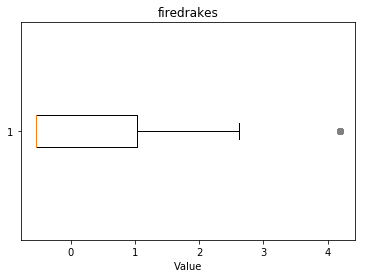

-------------------- 
Outlier detection:
 --------------------
List of outliers: {4.2}


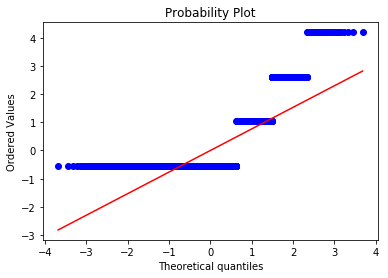

-------------------- 
Check for normal distribution:
 --------------------
Skewedness: 1.8709
Kurtosis: 3.0289
Overview of variable:  waterdrakes 


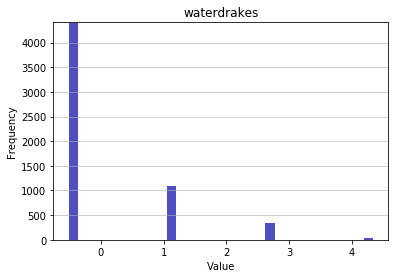

-------------------- 
Summary statistics:
 --------------------
Minimum value: -0.5269354060554317
Mean: 0.0
Standard deviation: 1.0001
Median: -0.5269
Maximal value: 4.347148093225245


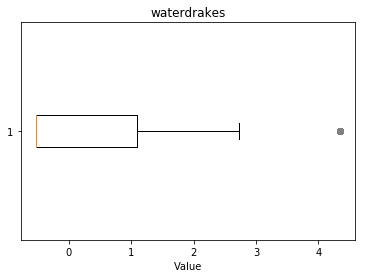

-------------------- 
Outlier detection:
 --------------------
List of outliers: {4.35}


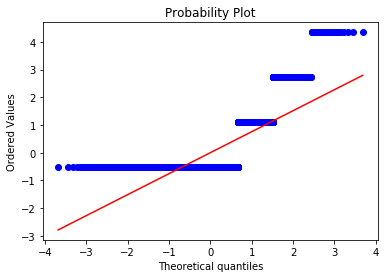

-------------------- 
Check for normal distribution:
 --------------------
Skewedness: 1.9065
Kurtosis: 3.1201
Overview of variable:  earthdrakes 


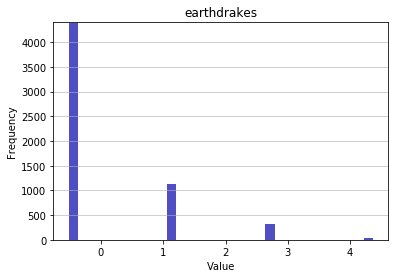

-------------------- 
Summary statistics:
 --------------------
Minimum value: -0.5293386093053396
Mean: -0.0
Standard deviation: 1.0001
Median: -0.5293
Maximal value: 4.379832169640924


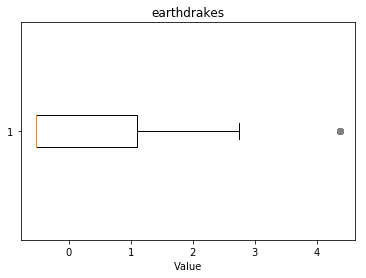

-------------------- 
Outlier detection:
 --------------------
List of outliers: {4.38}


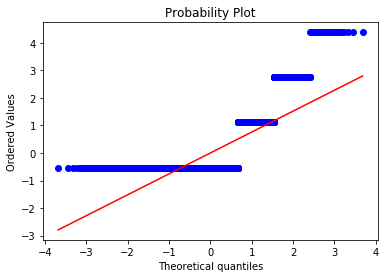

-------------------- 
Check for normal distribution:
 --------------------
Skewedness: 1.919
Kurtosis: 3.2742
Overview of variable:  airdrakes 


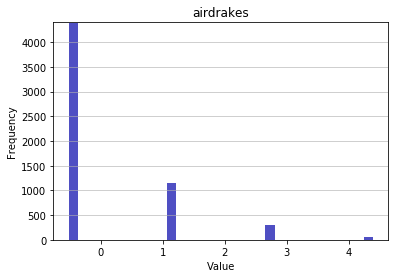

-------------------- 
Summary statistics:
 --------------------
Minimum value: -0.5279651607573426
Mean: 0.0
Standard deviation: 1.0001
Median: -0.528
Maximal value: 4.402129396965109


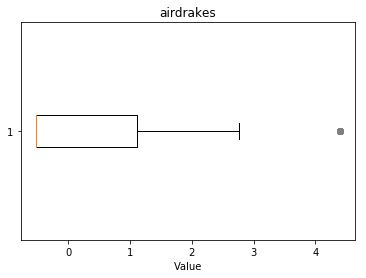

-------------------- 
Outlier detection:
 --------------------
List of outliers: {4.4}


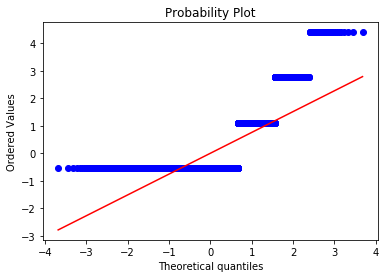

-------------------- 
Check for normal distribution:
 --------------------
Skewedness: 1.9433
Kurtosis: 3.4467
Overview of variable:  elders 


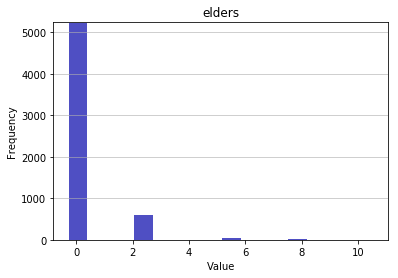

-------------------- 
Summary statistics:
 --------------------
Minimum value: -0.3352448328920001
Mean: -0.0
Standard deviation: 1.0001
Median: -0.3352
Maximal value: 10.58177362576533


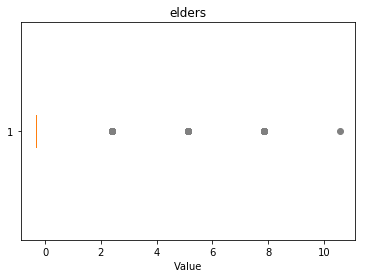

-------------------- 
Outlier detection:
 --------------------
List of outliers: {10.58, 5.12, 7.85}


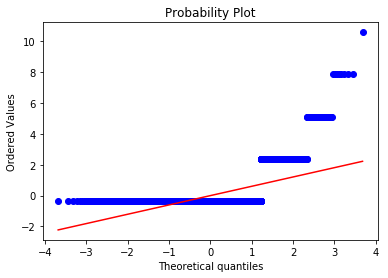

-------------------- 
Check for normal distribution:
 --------------------
Skewedness: 3.3189
Kurtosis: 13.2703
Overview of variable:  fttime 


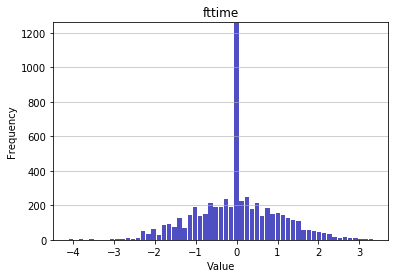

-------------------- 
Summary statistics:
 --------------------
Minimum value: -4.111726468199602
Mean: -0.0
Standard deviation: 1.0001
Median: -0.0051
Maximal value: 3.343280183609213


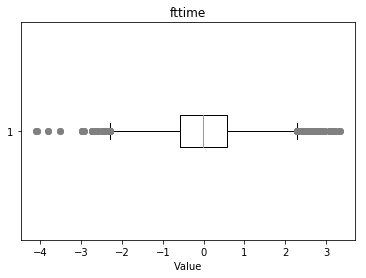

-------------------- 
Outlier detection:
 --------------------
List of outliers: {3.22, 3.14, 3.07, 3.16, 3.32, 3.34, -4.09, -3.81, -4.11, -3.53}


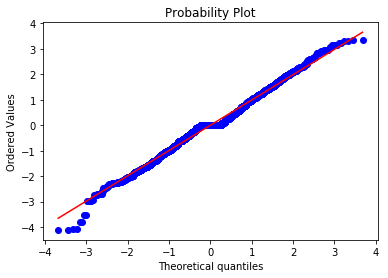

-------------------- 
Check for normal distribution:
 --------------------
Skewedness: 0.0208
Kurtosis: 0.4585
Overview of variable:  teamtowerkills 


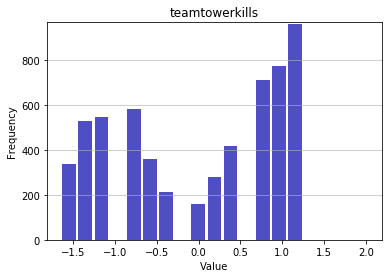

-------------------- 
Summary statistics:
 --------------------
Minimum value: -1.6446369352916141
Mean: 0.0
Standard deviation: 1.0001
Median: 0.1904
Maximal value: 2.025432716068371


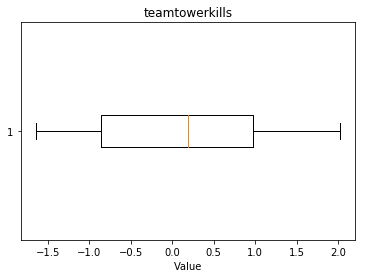

-------------------- 
Outlier detection:
 --------------------
List of outliers: set()


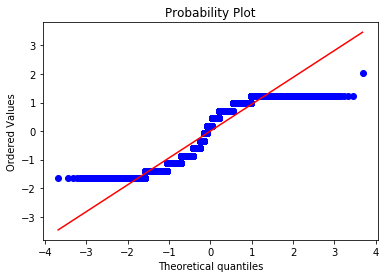

-------------------- 
Check for normal distribution:
 --------------------
Skewedness: -0.2165
Kurtosis: -1.4969
Overview of variable:  fbarontime 


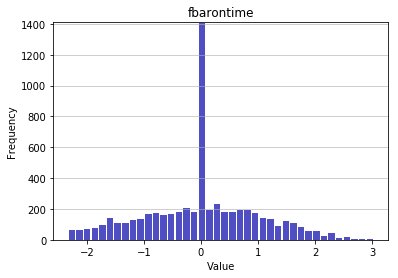

-------------------- 
Summary statistics:
 --------------------
Minimum value: -2.3319809589057368
Mean: 0.0
Standard deviation: 1.0001
Median: 0.0179
Maximal value: 3.0291616688914056


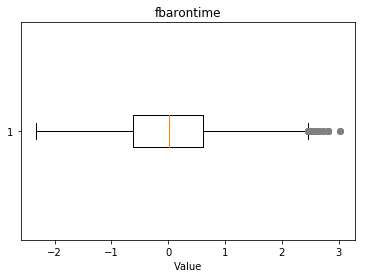

-------------------- 
Outlier detection:
 --------------------
List of outliers: {3.03}


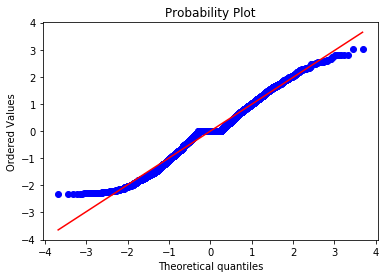

-------------------- 
Check for normal distribution:
 --------------------
Skewedness: 0.0063
Kurtosis: -0.1078
Overview of variable:  teambaronkills 


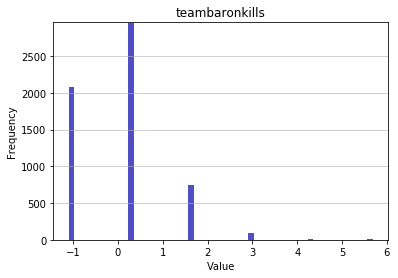

-------------------- 
Summary statistics:
 --------------------
Minimum value: -1.1109554797624726
Mean: -0.0
Standard deviation: 1.0001
Median: 0.2519
Maximal value: 5.703429632661362


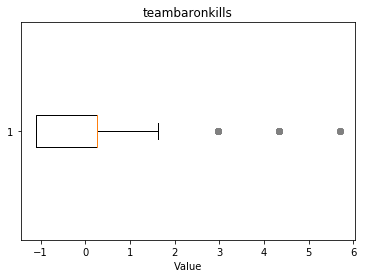

-------------------- 
Outlier detection:
 --------------------
List of outliers: {4.34, 5.7}


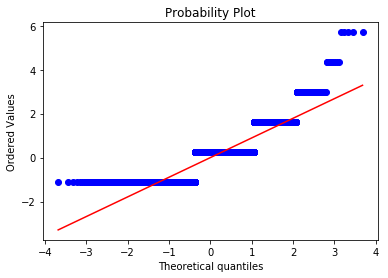

-------------------- 
Check for normal distribution:
 --------------------
Skewedness: 0.7812
Kurtosis: 1.1713
Overview of variable:  dmgtochamps 


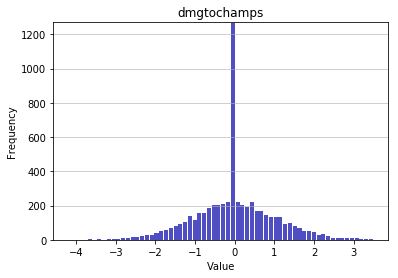

-------------------- 
Summary statistics:
 --------------------
Minimum value: -4.200643654971775
Mean: 0.0
Standard deviation: 1.0001
Median: -0.0085
Maximal value: 3.5006128714097766


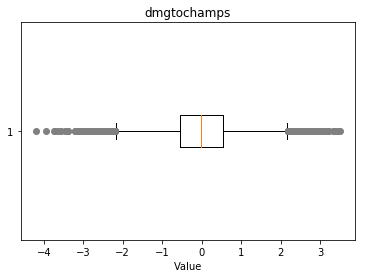

-------------------- 
Outlier detection:
 --------------------
List of outliers: {3.05, 3.09, 3.07, 3.03, 3.36, 3.37, 3.11, 3.47, 3.23, 3.14, 3.5, -3.39, 3.33, 3.17, -3.15, 3.02, -3.71, -3.63, -3.2, -3.55, -3.45, -3.13, 3.44, -3.37, -3.05, 3.04, -3.11, -3.93, -3.0, -3.74, -4.2, -3.21}


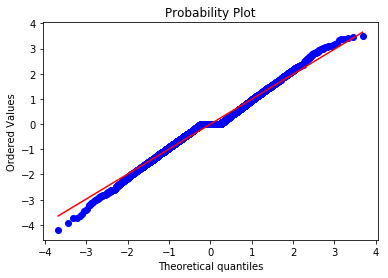

-------------------- 
Check for normal distribution:
 --------------------
Skewedness: 0.0008
Kurtosis: 0.7662
Overview of variable:  dmgtochampsperminute 


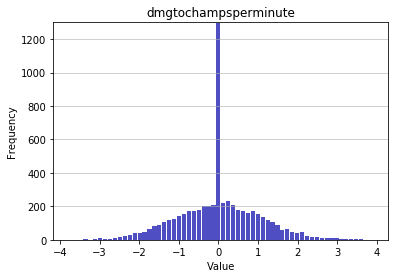

-------------------- 
Summary statistics:
 --------------------
Minimum value: -3.790854380550257
Mean: -0.0
Standard deviation: 1.0001
Median: 0.0064
Maximal value: 3.910856795821339


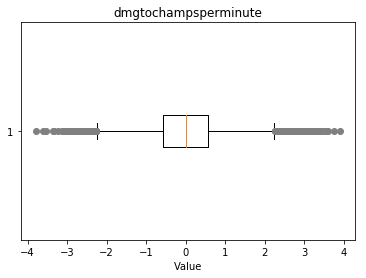

-------------------- 
Outlier detection:
 --------------------
List of outliers: {3.29, 3.28, 3.03, 3.91, 3.15, 3.36, 3.09, 3.43, 3.37, 3.08, 3.41, -3.23, 3.5, -3.07, 3.76, 3.27, -3.12, -3.04, -3.79, 3.6, 3.19, -3.35, -3.11, -3.6, -3.1, -3.53, 3.07, -3.33, -3.09, 3.56, 3.06, -3.06}


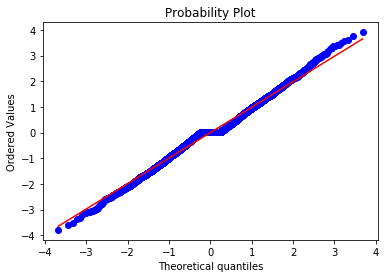

-------------------- 
Check for normal distribution:
 --------------------
Skewedness: 0.0234
Kurtosis: 0.6014
Overview of variable:  wards 


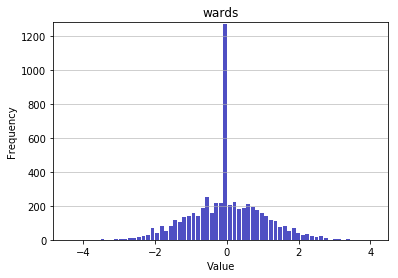

-------------------- 
Summary statistics:
 --------------------
Minimum value: -4.422394592430357
Mean: -0.0
Standard deviation: 1.0001
Median: 0.0162
Maximal value: 4.083190743518694


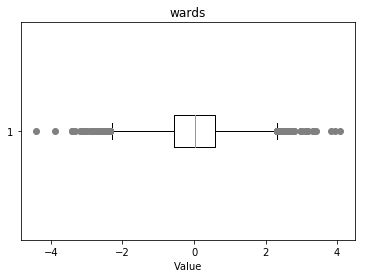

-------------------- 
Outlier detection:
 --------------------
List of outliers: {3.18, 3.93, 4.08, 3.0, 3.11, 3.81, 3.33, 3.41, 3.15, 3.32, -3.41, -3.12, -3.34, -3.19, -3.05, -4.42, -3.88}


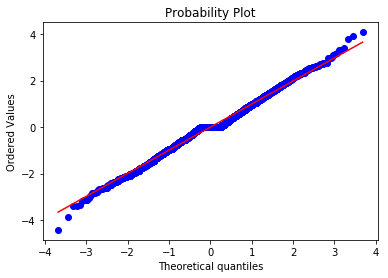

-------------------- 
Check for normal distribution:
 --------------------
Skewedness: 0.0002
Kurtosis: 0.4592
Overview of variable:  wpm 


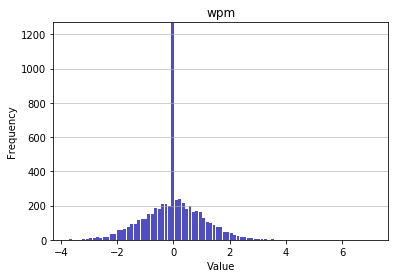

-------------------- 
Summary statistics:
 --------------------
Minimum value: -3.736742176719764
Mean: -0.0
Standard deviation: 1.0001
Median: 0.0225
Maximal value: 7.106667917383174


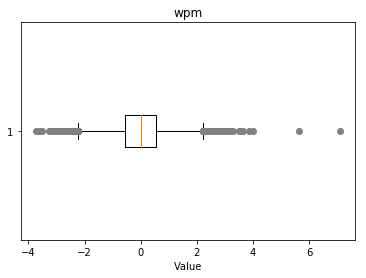

-------------------- 
Outlier detection:
 --------------------
List of outliers: {3.08, 3.09, 3.07, 5.64, 7.11, 3.11, 3.52, 3.02, 4.01, 3.55, 3.24, -3.14, -3.64, 3.1, 3.19, -3.05, -3.13, 3.28, 3.63, 3.87, 3.13, -3.52, -3.1, -3.26, -3.74, -3.08, -3.18}


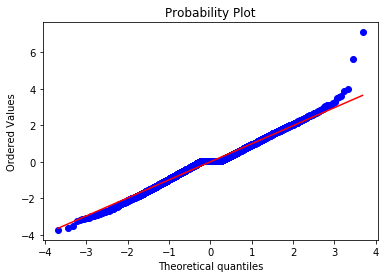

-------------------- 
Check for normal distribution:
 --------------------
Skewedness: 0.0267
Kurtosis: 1.1186
Overview of variable:  wardkills 


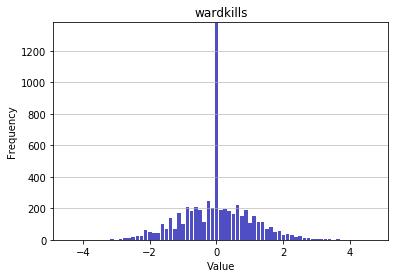

-------------------- 
Summary statistics:
 --------------------
Minimum value: -4.437895588393691
Mean: 0.0
Standard deviation: 1.0001
Median: 0.0101
Maximal value: 4.703552321383255


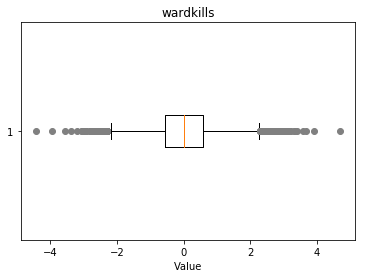

-------------------- 
Outlier detection:
 --------------------
List of outliers: {3.32, 3.41, 3.02, 3.12, 3.09, 3.6, 3.16, 4.7, 3.69, 3.93, 3.06, -3.95, -3.38, -3.55, 3.35, -3.21, 3.22, -4.44, -3.06}


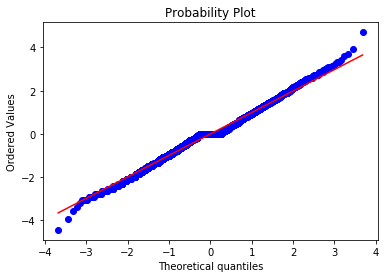

-------------------- 
Check for normal distribution:
 --------------------
Skewedness: 0.0275
Kurtosis: 0.6211
Overview of variable:  wcpm 


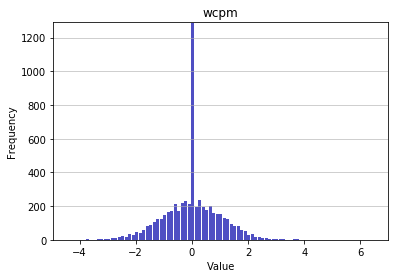

-------------------- 
Summary statistics:
 --------------------
Minimum value: -4.395004172032177
Mean: -0.0
Standard deviation: 1.0001
Median: -0.0017
Maximal value: 6.455404377833699


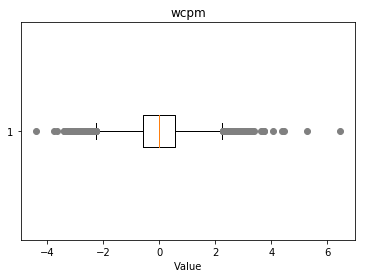

-------------------- 
Outlier detection:
 --------------------
List of outliers: {3.17, 3.3, 3.15, 3.07, 3.16, 3.18, 3.75, 3.33, 3.7, 4.06, 6.46, 5.27, 3.01, -3.15, -3.06, 3.76, -3.39, 3.1, -3.29, -3.04, 3.02, 3.28, 3.13, -3.27, 3.04, -3.19, 3.37, 4.37, 4.46, 3.64, -3.74, -3.0, -3.01, -3.16, -3.66, 3.22, -3.34, -4.4, -3.18}


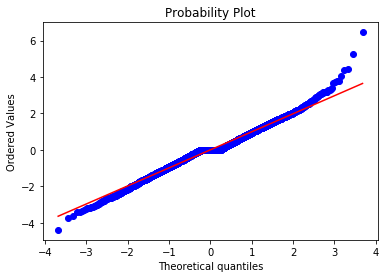

-------------------- 
Check for normal distribution:
 --------------------
Skewedness: 0.0554
Kurtosis: 1.1832
Overview of variable:  visionwards 


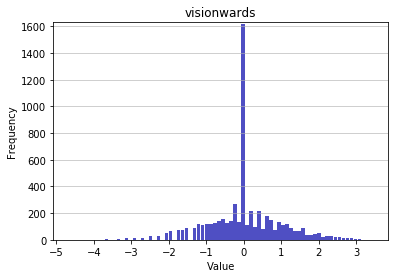

-------------------- 
Summary statistics:
 --------------------
Minimum value: -4.681864145153466
Mean: -0.0
Standard deviation: 1.0001
Median: -0.0167
Maximal value: 3.453612692076401


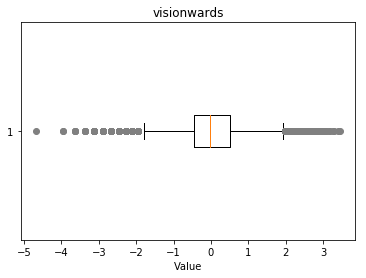

-------------------- 
Outlier detection:
 --------------------
List of outliers: {3.14, 3.03, 3.4, 3.45, 3.28, 3.09, 3.0, 3.25, 3.17, -3.95, -3.37, -3.64, -4.68, -3.11}


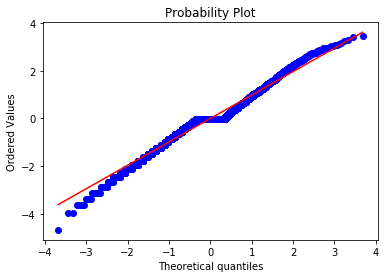

-------------------- 
Check for normal distribution:
 --------------------
Skewedness: -0.0006
Kurtosis: 0.9399
Overview of variable:  visionwardbuys 


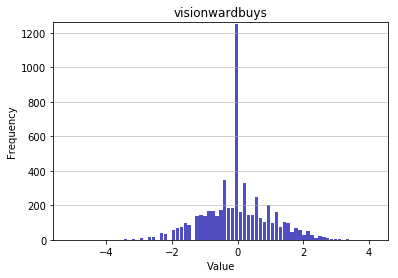

-------------------- 
Summary statistics:
 --------------------
Minimum value: -5.159791108599233
Mean: 0.0
Standard deviation: 1.0001
Median: -0.0211
Maximal value: 4.134306163638285


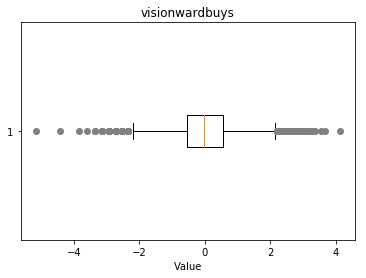

-------------------- 
Outlier detection:
 --------------------
List of outliers: {3.08, 3.66, 3.3, 3.56, 4.13, 3.14, 3.25, 3.35, -3.59, -3.35, -3.85, -5.16, -4.43, -3.13}


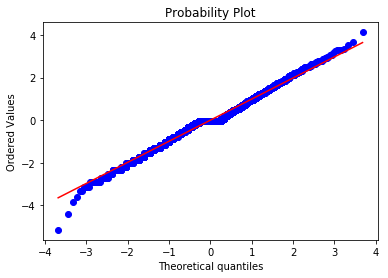

-------------------- 
Check for normal distribution:
 --------------------
Skewedness: 0.0173
Kurtosis: 0.65
Overview of variable:  visiblewardclearrate 


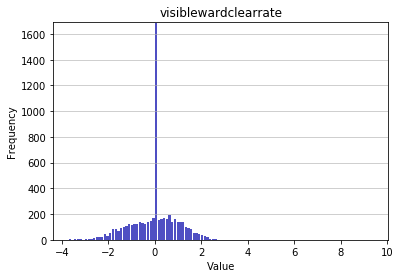

-------------------- 
Summary statistics:
 --------------------
Minimum value: -3.715315254542632
Mean: 0.0
Standard deviation: 1.0001
Median: 0.0639
Maximal value: 9.390311850262865


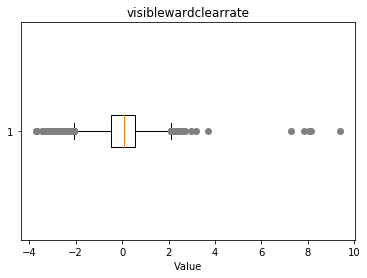

-------------------- 
Outlier detection:
 --------------------
List of outliers: {3.68, 3.19, -3.07, 7.28, 8.03, 9.39, 8.14, 7.83, -3.37, -3.0, -3.68, -3.7, -3.42, -3.2, -3.72, -3.14, -3.27, -3.24, -3.44, -3.06}


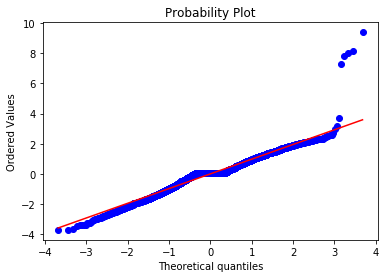

-------------------- 
Check for normal distribution:
 --------------------
Skewedness: 0.126
Kurtosis: 3.9705
Overview of variable:  invisiblewardclearrate 


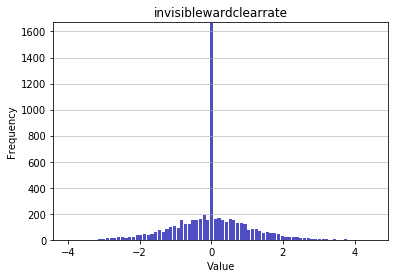

-------------------- 
Summary statistics:
 --------------------
Minimum value: -3.9864962253261895
Mean: 0.0
Standard deviation: 1.0001
Median: -0.0127
Maximal value: 4.5241330405073725


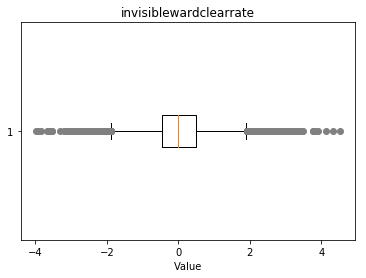

-------------------- 
Outlier detection:
 --------------------
List of outliers: {3.35, 3.82, 3.24, 4.52, 3.26, 3.05, 3.77, 3.79, 3.12, 3.17, 4.12, 3.91, 3.25, 3.16, 3.76, 4.33, 3.02, -3.04, -3.3, 3.11, 3.19, 3.1, -3.2, 3.29, -3.93, -3.1, -3.68, -3.53, 3.13, 3.46, 3.39, -3.59, -3.99, -3.83, 3.06, 3.48, -3.17, -3.13}


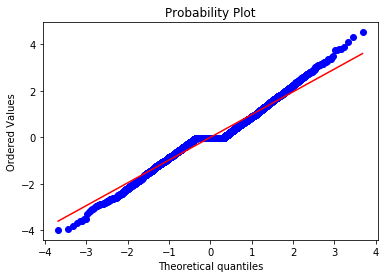

-------------------- 
Check for normal distribution:
 --------------------
Skewedness: 0.0798
Kurtosis: 1.3232
Overview of variable:  totalgold 


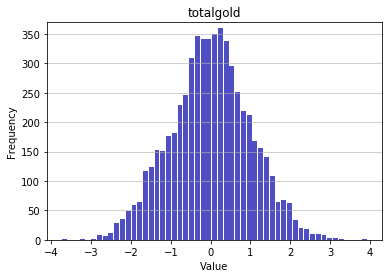

-------------------- 
Summary statistics:
 --------------------
Minimum value: -3.7350710891723526
Mean: 0.0
Standard deviation: 1.0001
Median: 0.012
Maximal value: 3.93622930889301


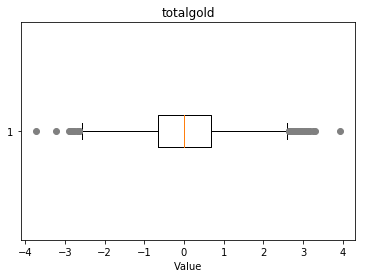

-------------------- 
Outlier detection:
 --------------------
List of outliers: {3.31, 3.18, 3.94, 3.12, 3.26, 3.09, 3.03, -3.74, -3.22}


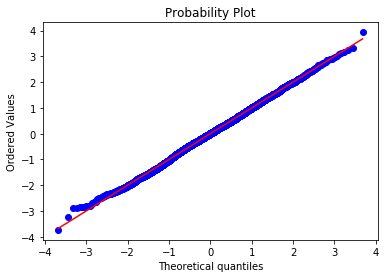

-------------------- 
Check for normal distribution:
 --------------------
Skewedness: -0.001
Kurtosis: -0.0712
Overview of variable:  earnedgpm 


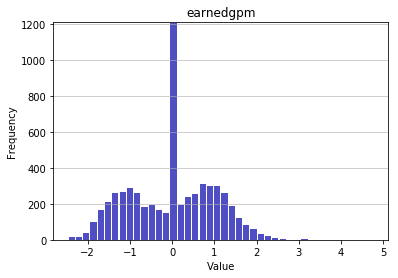

-------------------- 
Summary statistics:
 --------------------
Minimum value: -2.4648970372374963
Mean: -0.0
Standard deviation: 1.0001
Median: 0.0815
Maximal value: 4.771253901235502


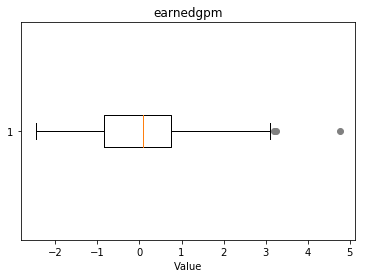

-------------------- 
Outlier detection:
 --------------------
List of outliers: {3.1, 3.2, 3.25, 4.77}


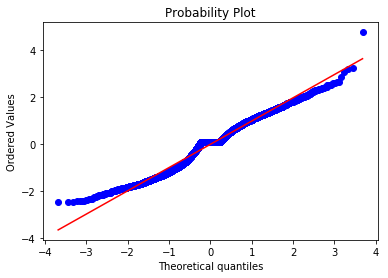

-------------------- 
Check for normal distribution:
 --------------------
Skewedness: -0.0484
Kurtosis: -0.6095
Overview of variable:  goldspent 


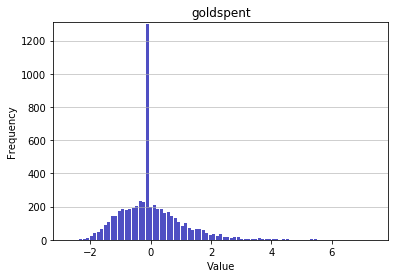

-------------------- 
Summary statistics:
 --------------------
Minimum value: -2.7274158943914983
Mean: -0.0
Standard deviation: 1.0001
Median: -0.0982
Maximal value: 7.372179086089065


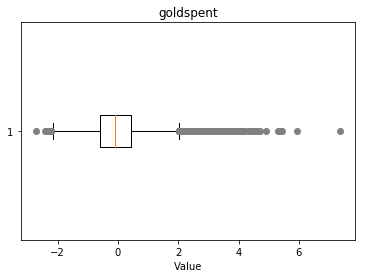

-------------------- 
Outlier detection:
 --------------------
List of outliers: {3.35, 4.48, 3.85, 4.15, 4.62, 3.5, 4.45, 3.2, 3.97, 4.72, 4.54, 5.36, 7.37, 3.49, 3.74, 3.26, 3.16, 3.24, 4.17, 4.52, 4.92, 3.34, 3.59, 5.42, 5.43, 3.66, 3.61, 3.94, 3.27, 3.11, 3.43, 3.1, 3.6, 3.36, 3.28, 3.54, 3.13, 3.79, 3.46, 3.96, 4.13, 4.04, 4.38, 4.11, 4.3, 5.31, 5.94, 4.19, 3.65, 3.06, 3.73, 3.48}


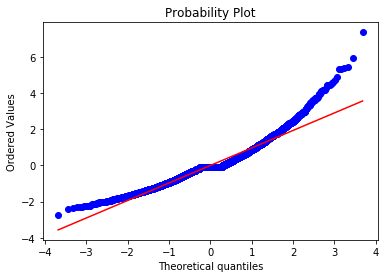

-------------------- 
Check for normal distribution:
 --------------------
Skewedness: 1.0496
Kurtosis: 2.7941
Overview of variable:  gspd 


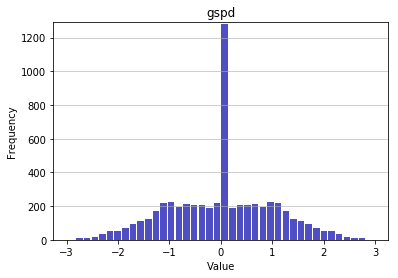

-------------------- 
Summary statistics:
 --------------------
Minimum value: -2.969781368249859
Mean: 0.0
Standard deviation: 1.0001
Median: 0.0
Maximal value: 2.969781368249859


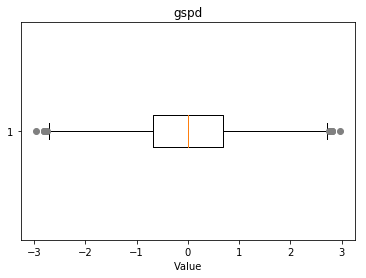

-------------------- 
Outlier detection:
 --------------------
List of outliers: set()


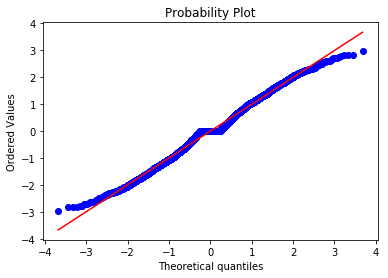

-------------------- 
Check for normal distribution:
 --------------------
Skewedness: 0.0
Kurtosis: -0.1948
Overview of variable:  minionkills 


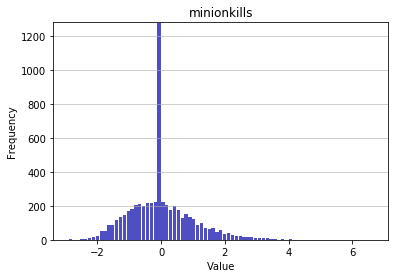

-------------------- 
Summary statistics:
 --------------------
Minimum value: -2.9082367502320485
Mean: -0.0
Standard deviation: 1.0001
Median: -0.0865
Maximal value: 6.657366372776041


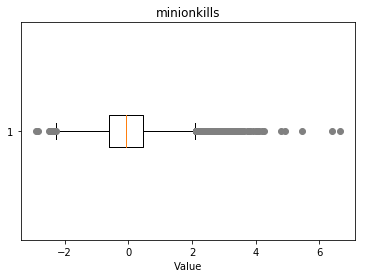

-------------------- 
Outlier detection:
 --------------------
List of outliers: {3.19, 3.75, 3.3, 4.79, 3.03, 3.56, 3.38, 3.29, 3.1, 3.21, 4.03, 6.66, 6.4, 3.16, 3.09, 3.33, 3.34, 3.24, 4.25, 4.93, 4.0, 3.5, 3.91, 3.31, 3.02, 3.18, 3.77, 3.78, 3.27, 3.36, 3.28, 3.44, 3.48, 3.37, 3.62, 3.79, 4.05, 4.11, 4.2, 5.46, 3.01, 3.64, 3.47, 3.15, 3.23, 3.14, 3.06, 3.39, 3.07, 3.22, 3.32, 3.83}


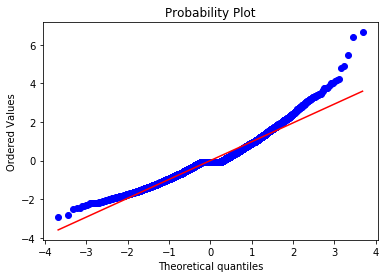

-------------------- 
Check for normal distribution:
 --------------------
Skewedness: 0.8212
Kurtosis: 1.8582
Overview of variable:  monsterkills 


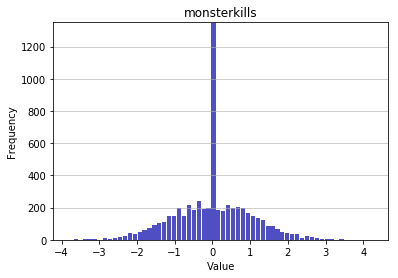

-------------------- 
Summary statistics:
 --------------------
Minimum value: -3.8236444067393176
Mean: -0.0
Standard deviation: 1.0001
Median: -0.0069
Maximal value: 4.269278271292547


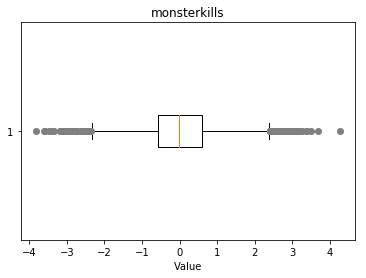

-------------------- 
Outlier detection:
 --------------------
List of outliers: {3.15, 3.4, 3.11, 3.02, 3.24, 3.49, 3.13, 3.08, 3.07, 3.37, 4.27, -3.57, -3.47, -3.82, 3.69, -3.62, 3.18, -3.19, -3.1, -3.33, -3.42, -3.05}


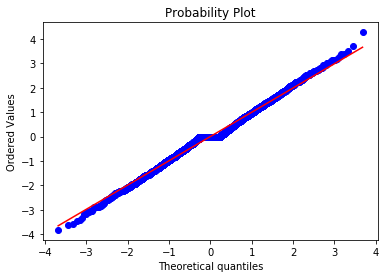

-------------------- 
Check for normal distribution:
 --------------------
Skewedness: 0.0157
Kurtosis: 0.4932
Overview of variable:  monsterkillsownjungle 


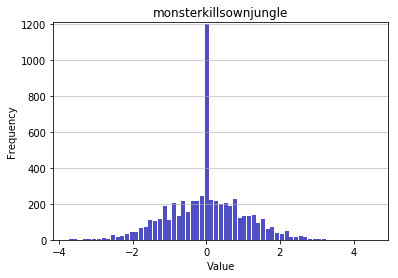

-------------------- 
Summary statistics:
 --------------------
Minimum value: -3.747662505126108
Mean: -0.0
Standard deviation: 1.0001
Median: -0.0115
Maximal value: 4.538711616820009


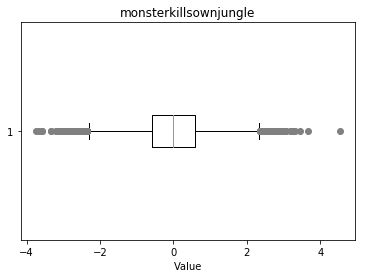

-------------------- 
Outlier detection:
 --------------------
List of outliers: {3.08, 3.04, 3.32, 3.68, 3.26, 3.17, 3.44, 4.54, 3.23, -3.11, -3.19, -3.66, -3.34, -3.58, -3.75, -3.04}


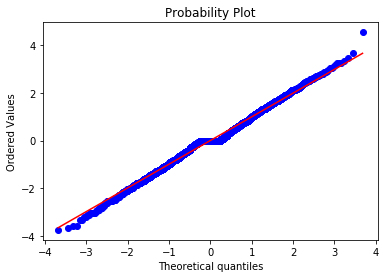

-------------------- 
Check for normal distribution:
 --------------------
Skewedness: 0.0156
Kurtosis: 0.4792
Overview of variable:  monsterkillsenemyjungle 


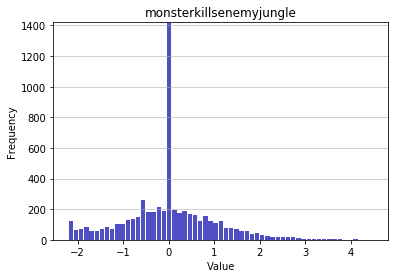

-------------------- 
Summary statistics:
 --------------------
Minimum value: -2.2046211284160093
Mean: -0.0
Standard deviation: 1.0001
Median: -0.0196
Maximal value: 4.4986960790285595


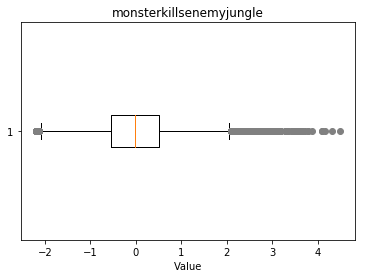

-------------------- 
Outlier detection:
 --------------------
List of outliers: {3.42, 3.17, 4.09, 3.72, 3.46, 3.31, 3.13, 3.09, 3.35, 3.2, 4.17, 3.5, 4.5, 3.68, 3.02, 3.61, 3.28, 3.05, 3.87, 3.8, 3.54, 4.31, 3.65, 3.57}


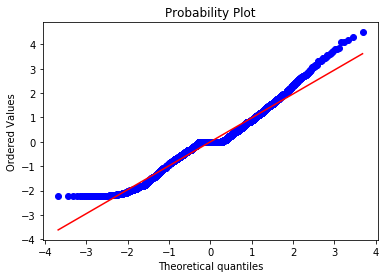

-------------------- 
Check for normal distribution:
 --------------------
Skewedness: 0.3599
Kurtosis: 0.9564
Overview of variable:  cspm 


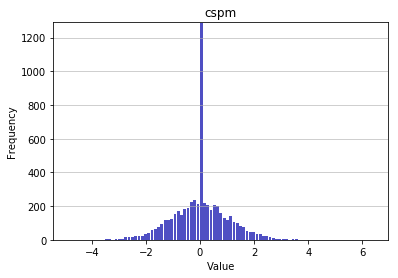

-------------------- 
Summary statistics:
 --------------------
Minimum value: -4.861541401277161
Mean: -0.0
Standard deviation: 1.0001
Median: -0.0038
Maximal value: 6.404322025288758


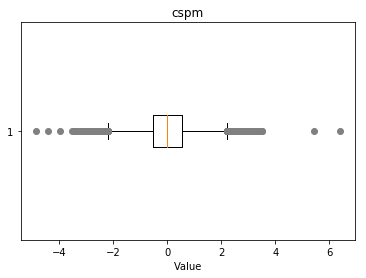

-------------------- 
Outlier detection:
 --------------------
List of outliers: {3.3, 3.06, 5.44, 6.4, 3.11, 3.14, 3.4, 3.08, 3.12, 3.16, 3.5, -3.98, -3.07, -3.14, 3.51, 3.19, -3.2, -3.12, -3.29, -3.45, 3.21, -3.1, -3.52, -3.36, -4.4, -3.16, -3.41, -4.86, -3.02}


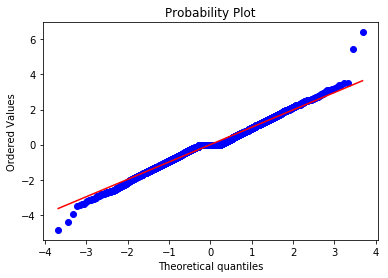

-------------------- 
Check for normal distribution:
 --------------------
Skewedness: 0.019
Kurtosis: 1.1292
Overview of variable:  goldat10 


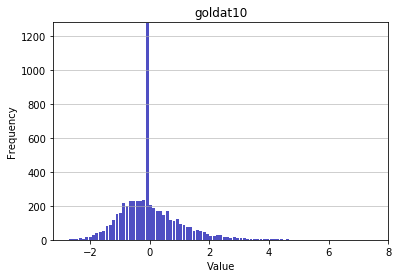

-------------------- 
Summary statistics:
 --------------------
Minimum value: -2.729710929861622
Mean: 0.0
Standard deviation: 1.0001
Median: -0.135
Maximal value: 7.493883632706944


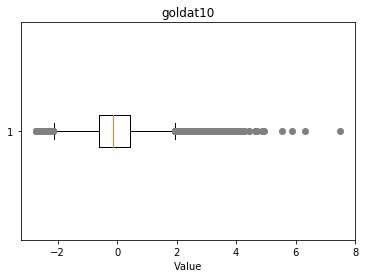

-------------------- 
Outlier detection:
 --------------------
List of outliers: {3.02, 3.39, 3.12, 6.31, 3.62, 3.08, 4.88, 3.48, 3.16, 3.13, 4.71, 5.53, 3.37, 3.24, 3.01, 3.09, 3.99, 3.33, 4.42, 4.68, 4.26, 3.84, 3.67, 4.0, 4.07, 3.66, 3.25, 3.59, 7.49, 3.45, 3.17, 3.42, 3.52, 3.35, 3.44, 3.85, 3.69, 3.19, 3.18, 3.74, 3.49, 3.46, 3.71, 3.63, 3.29, 3.21, 3.3, 4.13, 4.95, 4.62, 4.22, 3.2, 4.04, 5.86, 3.04, 3.87, 3.81, 3.06, 3.57, 3.15, 3.4, 3.32}


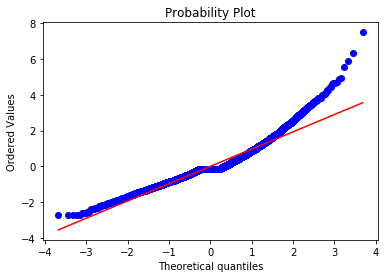

-------------------- 
Check for normal distribution:
 --------------------
Skewedness: 1.1174
Kurtosis: 2.9897
Overview of variable:  gdat10 


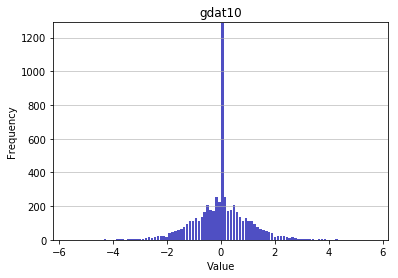

-------------------- 
Summary statistics:
 --------------------
Minimum value: -5.64930696122865
Mean: 0.0
Standard deviation: 1.0001
Median: 0.0
Maximal value: 5.64930696122865


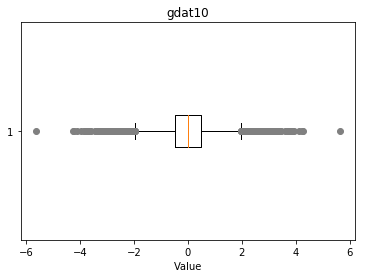

-------------------- 
Outlier detection:
 --------------------
List of outliers: {3.35, 3.02, 5.65, 3.95, 3.14, 3.01, 3.34, 3.27, 3.84, 3.2, 4.12, 3.73, 3.08, -3.14, -3.23, 3.41, 3.25, 3.59, 4.26, 3.26, 3.33, 3.66, -3.81, -3.47, 4.24, 3.81, 3.28, -3.95, -3.2, -3.05, -3.21, -3.0, -3.75, 3.86, 3.47, 3.05, -3.27, -3.02, -3.28, 3.0, 3.75, 3.21, -3.86, -4.26, -4.24, 3.23, -3.01, -3.34, -3.84, -3.08, -3.41, -3.25, -3.59, -3.26, -3.33, -3.66, -5.65, -4.12, -3.35, -3.73}


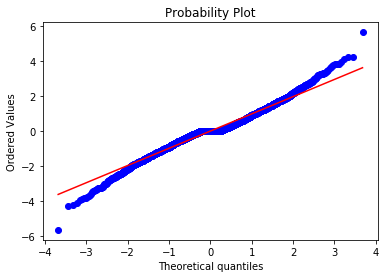

-------------------- 
Check for normal distribution:
 --------------------
Skewedness: 0.0
Kurtosis: 1.7594
Overview of variable:  goldat15 


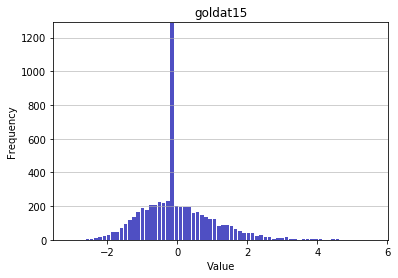

-------------------- 
Summary statistics:
 --------------------
Minimum value: -3.109602163902435
Mean: 0.0
Standard deviation: 1.0001
Median: -0.1021
Maximal value: 5.603621292556513


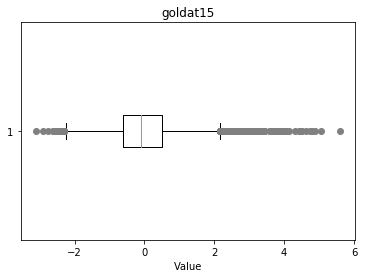

-------------------- 
Outlier detection:
 --------------------
List of outliers: {3.79, 4.52, 4.14, 5.05, 4.43, 4.31, 3.59, 3.68, 3.15, 3.41, 5.6, 3.01, 3.26, 3.08, 3.17, 3.92, 4.75, 4.07, 3.09, 3.78, 3.1, 3.86, 3.02, 3.19, 3.6, 3.05, 3.21, 3.2, 3.13, 3.96, 4.8, 4.03, 4.89, 4.63, 4.47, 3.47, 3.82, 3.22, 3.06, 3.31, 3.4, 3.39, 3.65, 3.14, 3.07, -3.11}


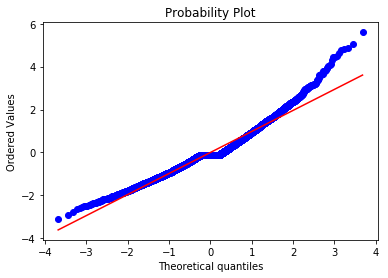

-------------------- 
Check for normal distribution:
 --------------------
Skewedness: 0.7453
Kurtosis: 1.5037
Overview of variable:  gdat15 


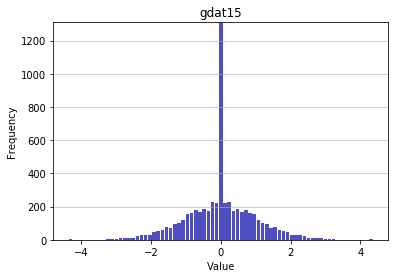

-------------------- 
Summary statistics:
 --------------------
Minimum value: -4.372446415998657
Mean: 0.0
Standard deviation: 1.0001
Median: 0.0
Maximal value: 4.372446415998657


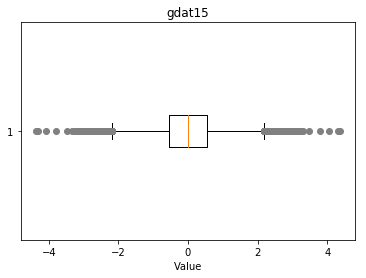

-------------------- 
Outlier detection:
 --------------------
List of outliers: {3.04, 4.32, 3.06, 3.48, 3.21, 3.2, 4.37, 4.07, 3.16, 3.1, 3.01, -3.48, -3.23, -3.06, -3.32, 3.25, 3.02, -3.21, -3.2, -3.79, -3.13, 3.18, 3.79, -3.1, 3.13, -3.02, -3.18, -4.07, -4.32, 3.23, -3.16, 3.32, -3.01, -3.25, -4.37, -3.04}


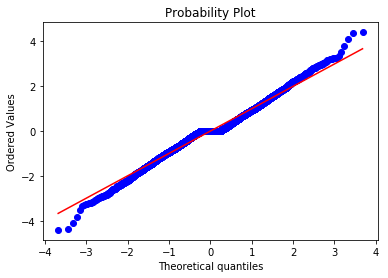

-------------------- 
Check for normal distribution:
 --------------------
Skewedness: 0.0
Kurtosis: 0.9613
Overview of variable:  xpat10 


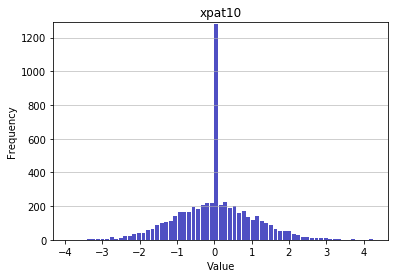

-------------------- 
Summary statistics:
 --------------------
Minimum value: -3.9141117263471
Mean: -0.0
Standard deviation: 1.0001
Median: -0.0045
Maximal value: 4.263991653975674


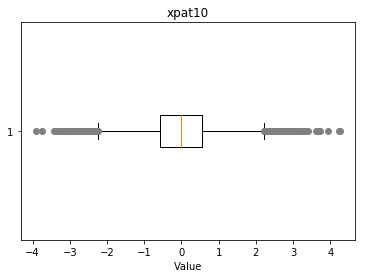

-------------------- 
Outlier detection:
 --------------------
List of outliers: {3.27, 3.02, 3.04, 3.32, 3.11, 3.08, 3.95, 3.39, 4.26, 4.23, 3.67, -3.15, -3.14, -3.32, 3.17, -3.38, -3.04, -3.13, 3.62, -3.44, 3.12, 3.71, -3.75, -3.91, -3.09, -3.41, -3.27}


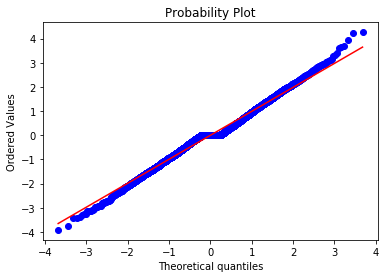

-------------------- 
Check for normal distribution:
 --------------------
Skewedness: 0.0382
Kurtosis: 0.7001
Overview of variable:  xpdat10 


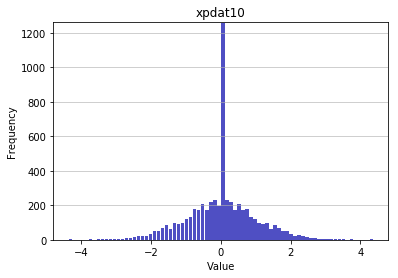

-------------------- 
Summary statistics:
 --------------------
Minimum value: -4.371656495045183
Mean: 0.0
Standard deviation: 1.0001
Median: 0.0
Maximal value: 4.371656495045183


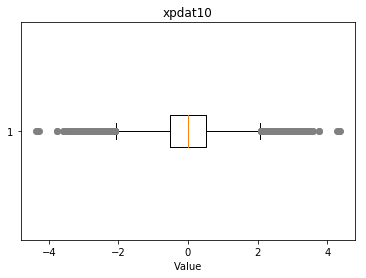

-------------------- 
Outlier detection:
 --------------------
List of outliers: {3.07, 3.27, 4.29, 3.76, 3.19, 3.18, 3.28, 3.51, 3.5, 3.31, 4.37, 3.08, -3.31, -3.07, -3.32, -3.14, 3.17, 3.58, -3.4, 4.35, 3.0, -4.37, 3.03, 3.11, 3.44, 3.1, -3.19, -3.18, -3.28, -3.03, -3.11, -3.44, -3.1, -4.35, 3.32, -3.76, -3.51, -3.5, -3.08, 3.14, -3.17, -3.58, 3.4, -3.0, -4.29, -3.27}


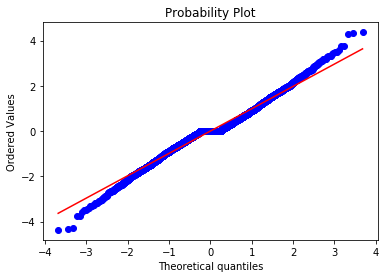

-------------------- 
Check for normal distribution:
 --------------------
Skewedness: 0.0
Kurtosis: 1.1711
Overview of variable:  csat10 


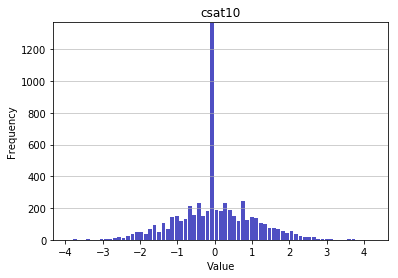

-------------------- 
Summary statistics:
 --------------------
Minimum value: -3.923444644691499
Mean: -0.0
Standard deviation: 1.0001
Median: -0.0283
Maximal value: 4.252075301186782


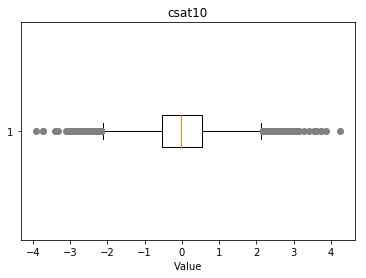

-------------------- 
Outlier detection:
 --------------------
List of outliers: {3.28, 3.16, 3.54, 3.03, 3.73, 3.09, 3.41, 3.86, 3.6, 4.25, -3.37, -3.34, -3.04, -3.41, -3.01, -3.08, -3.12, -3.92, -3.72}


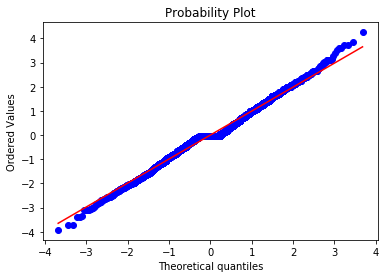

-------------------- 
Check for normal distribution:
 --------------------
Skewedness: 0.0283
Kurtosis: 0.5934
Overview of variable:  csdat10 


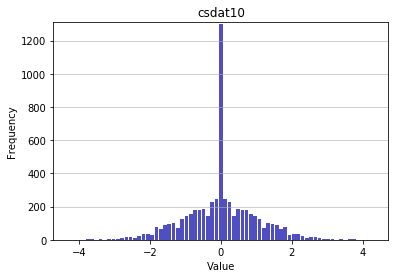

-------------------- 
Summary statistics:
 --------------------
Minimum value: -4.3001824342450705
Mean: 0.0
Standard deviation: 1.0001
Median: 0.0
Maximal value: 4.3001824342450705


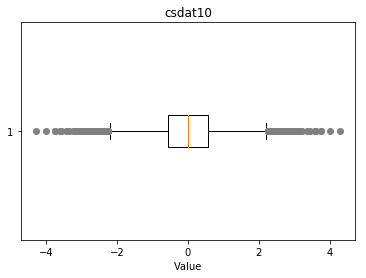

-------------------- 
Outlier detection:
 --------------------
List of outliers: {3.75, 3.02, 4.3, 3.15, 3.07, 3.62, 3.58, 3.19, 3.24, 3.45, 4.0, -3.15, -3.07, -4.3, 3.11, -3.62, -3.45, 3.36, -3.19, -3.02, -3.11, -3.36, -3.58, -3.24, -4.0, -3.75}


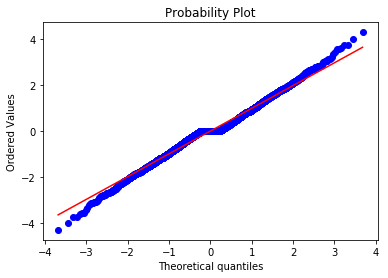

-------------------- 
Check for normal distribution:
 --------------------
Skewedness: 0.0
Kurtosis: 0.8037
Overview of variable:  csat15 


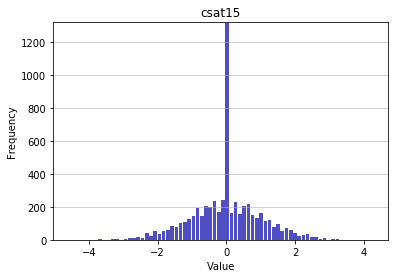

-------------------- 
Summary statistics:
 --------------------
Minimum value: -4.60147902681231
Mean: 0.0
Standard deviation: 1.0001
Median: -0.0218
Maximal value: 4.27769916654056


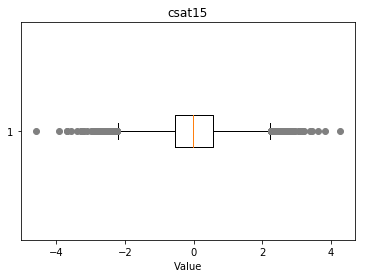

-------------------- 
Outlier detection:
 --------------------
List of outliers: {3.83, 3.15, 3.47, 3.04, 4.28, 3.19, 3.39, 3.23, 3.63, 3.12, -3.4, -3.3, -3.21, -3.69, -3.27, -3.11, -3.19, -3.24, -3.59, -4.6, -3.92}


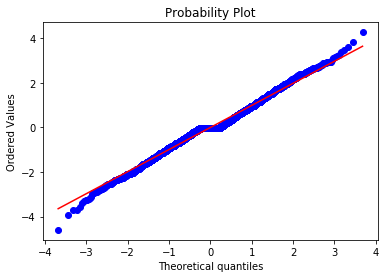

-------------------- 
Check for normal distribution:
 --------------------
Skewedness: 0.027
Kurtosis: 0.658
Overview of variable:  csdat15 


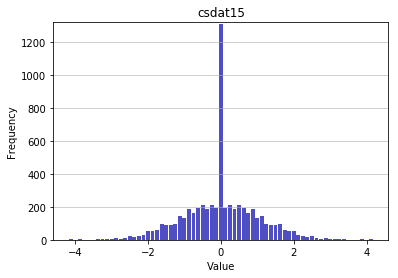

-------------------- 
Summary statistics:
 --------------------
Minimum value: -4.181398659187744
Mean: 0.0
Standard deviation: 1.0001
Median: 0.0
Maximal value: 4.181398659187744


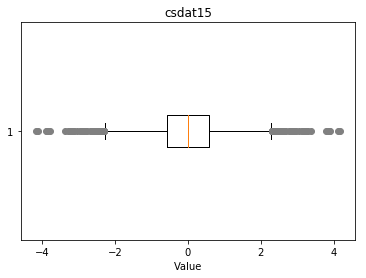

-------------------- 
Outlier detection:
 --------------------
List of outliers: {3.31, 3.13, 4.18, 3.85, 4.12, 3.16, 3.25, 3.91, 3.37, 3.22, -3.22, 3.19, -3.37, -3.13, -3.88, -3.79, -3.04, 3.88, -3.85, 3.79, -3.19, 3.04, -4.18, -3.16, -3.25, -3.91, -4.12, -3.31}


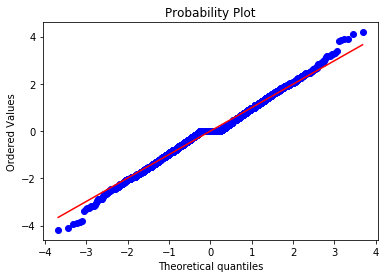

-------------------- 
Check for normal distribution:
 --------------------
Skewedness: 0.0
Kurtosis: 0.7082
Overview of variable:  datediff 


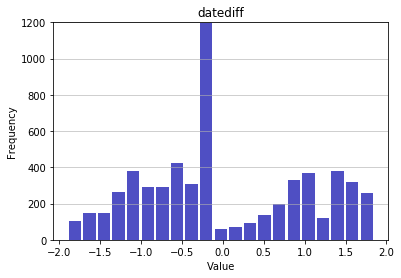

-------------------- 
Summary statistics:
 --------------------
Minimum value: -1.8949621106371146
Mean: -0.0
Standard deviation: 1.0001
Median: -0.2858
Maximal value: 1.849536395197465


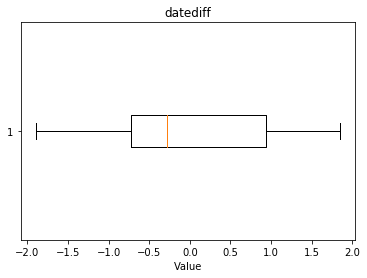

-------------------- 
Outlier detection:
 --------------------
List of outliers: set()


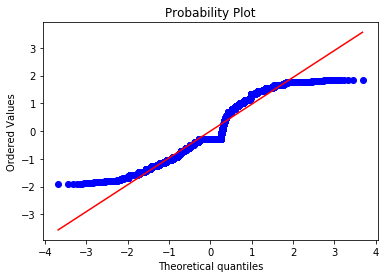

-------------------- 
Check for normal distribution:
 --------------------
Skewedness: 0.2566
Kurtosis: -1.0924
Overview of variable:  Encoded_league 


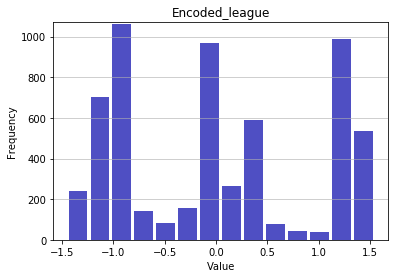

-------------------- 
Summary statistics:
 --------------------
Minimum value: -1.4496186587808317
Mean: -0.0
Standard deviation: 1.0001
Median: -0.0684
Maximal value: 1.543094500419246


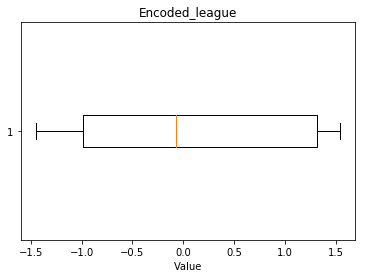

-------------------- 
Outlier detection:
 --------------------
List of outliers: set()


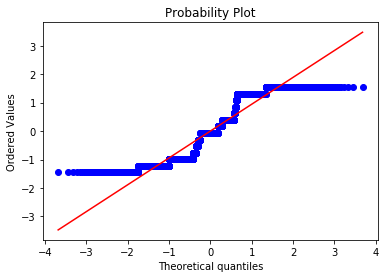

-------------------- 
Check for normal distribution:
 --------------------
Skewedness: 0.2066
Kurtosis: -1.3453
Overview of variable:  Encoded_game 


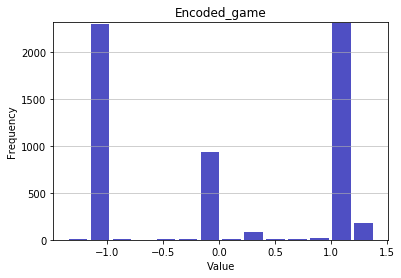

-------------------- 
Summary statistics:
 --------------------
Minimum value: -1.3608488900450533
Mean: 0.0
Standard deviation: 1.0001
Median: -0.0987
Maximal value: 1.3929752791522365


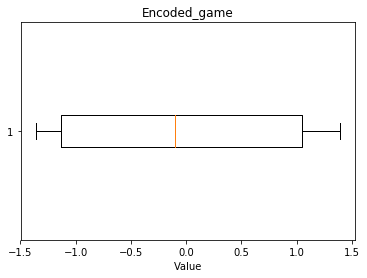

-------------------- 
Outlier detection:
 --------------------
List of outliers: set()


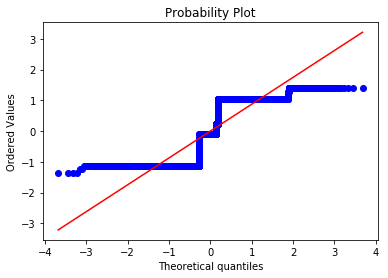

-------------------- 
Check for normal distribution:
 --------------------
Skewedness: -0.0322
Kurtosis: -1.7651
Overview of variable:  Encoded_side 


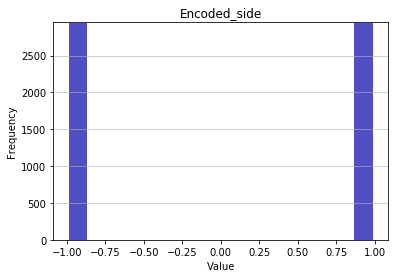

-------------------- 
Summary statistics:
 --------------------
Minimum value: -1.0
Mean: 0.0
Standard deviation: 1.0001
Median: 0.0
Maximal value: 1.0


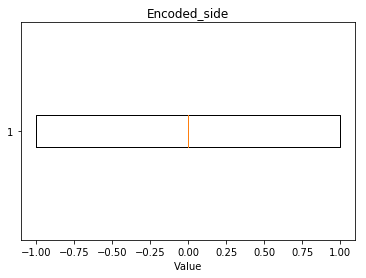

-------------------- 
Outlier detection:
 --------------------
List of outliers: set()


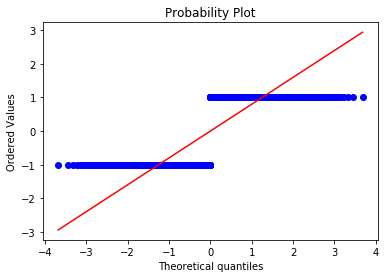

-------------------- 
Check for normal distribution:
 --------------------
Skewedness: 0.0
Kurtosis: -2.0
Overview of variable:  Encoded_ban1 


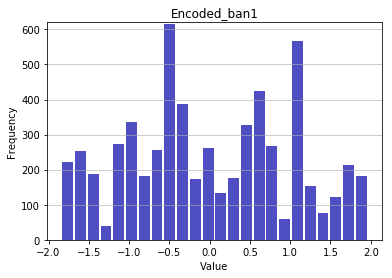

-------------------- 
Summary statistics:
 --------------------
Minimum value: -1.840742557867949
Mean: -0.0
Standard deviation: 1.0001
Median: -0.0721
Maximal value: 1.9617750506339582


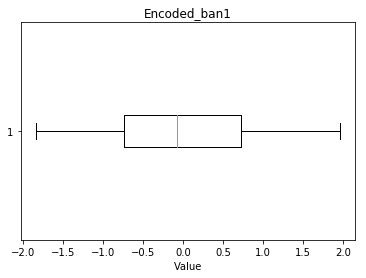

-------------------- 
Outlier detection:
 --------------------
List of outliers: set()


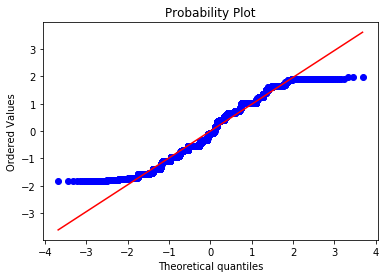

-------------------- 
Check for normal distribution:
 --------------------
Skewedness: 0.0824
Kurtosis: -1.0004
Overview of variable:  Encoded_ban2 


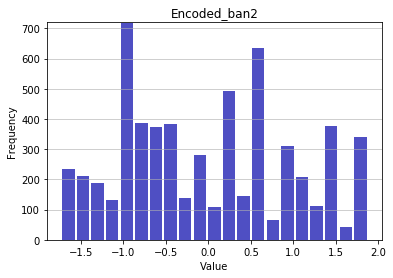

-------------------- 
Summary statistics:
 --------------------
Minimum value: -1.733445411355685
Mean: -0.0
Standard deviation: 1.0001
Median: -0.1417
Maximal value: 1.8771027482784188


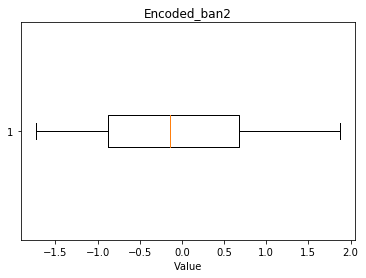

-------------------- 
Outlier detection:
 --------------------
List of outliers: set()


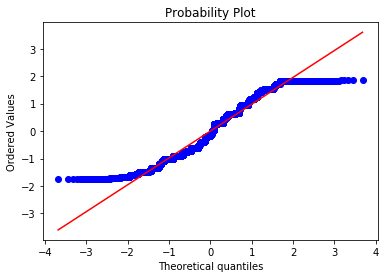

-------------------- 
Check for normal distribution:
 --------------------
Skewedness: 0.1837
Kurtosis: -1.0747
Overview of variable:  Encoded_ban3 


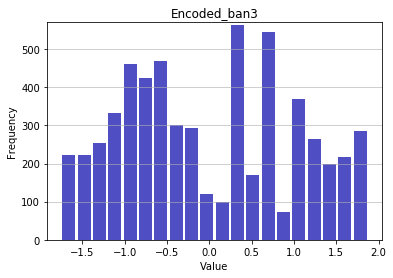

-------------------- 
Summary statistics:
 --------------------
Minimum value: -1.7488260279091623
Mean: -0.0
Standard deviation: 1.0001
Median: -0.1432
Maximal value: 1.8730611308026472


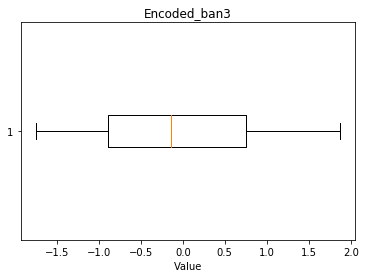

-------------------- 
Outlier detection:
 --------------------
List of outliers: set()


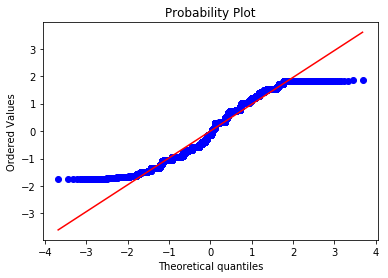

-------------------- 
Check for normal distribution:
 --------------------
Skewedness: 0.151
Kurtosis: -1.126
Overview of variable:  Encoded_ban4 


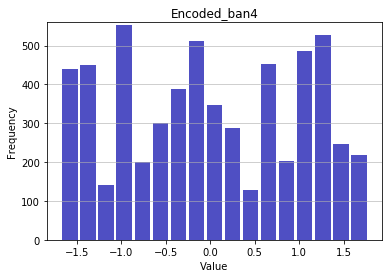

-------------------- 
Summary statistics:
 --------------------
Minimum value: -1.67758586607786
Mean: -0.0
Standard deviation: 1.0001
Median: -0.0941
Maximal value: 1.7743250709838725


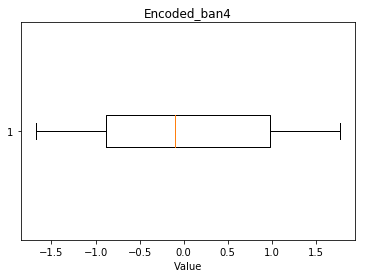

-------------------- 
Outlier detection:
 --------------------
List of outliers: set()


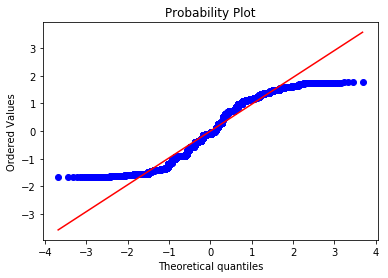

-------------------- 
Check for normal distribution:
 --------------------
Skewedness: -0.0085
Kurtosis: -1.2306
Overview of variable:  Encoded_ban5 


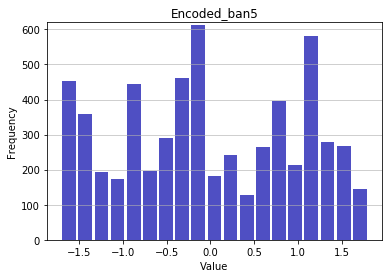

-------------------- 
Summary statistics:
 --------------------
Minimum value: -1.7069555492217965
Mean: -0.0
Standard deviation: 1.0001
Median: -0.1067
Maximal value: 1.8012961089196589


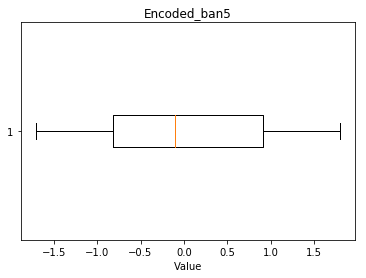

-------------------- 
Outlier detection:
 --------------------
List of outliers: set()


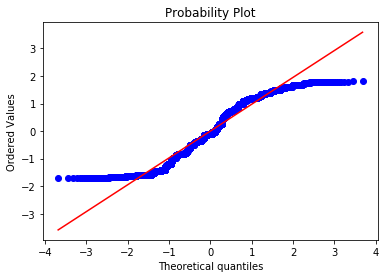

-------------------- 
Check for normal distribution:
 --------------------
Skewedness: -0.0277
Kurtosis: -1.1751
Overview of variable:  Encoded_result 


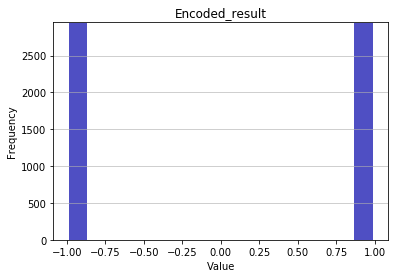

-------------------- 
Summary statistics:
 --------------------
Minimum value: -1.0
Mean: 0.0
Standard deviation: 1.0001
Median: 0.0
Maximal value: 1.0


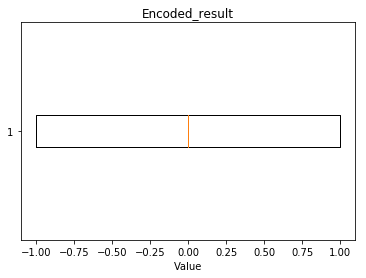

-------------------- 
Outlier detection:
 --------------------
List of outliers: set()


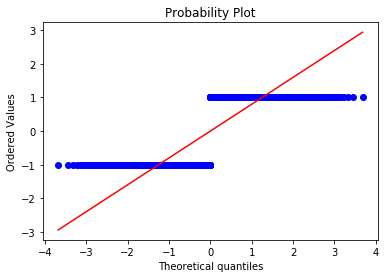

-------------------- 
Check for normal distribution:
 --------------------
Skewedness: 0.0
Kurtosis: -2.0
Overview of variable:  Encoded_fb 


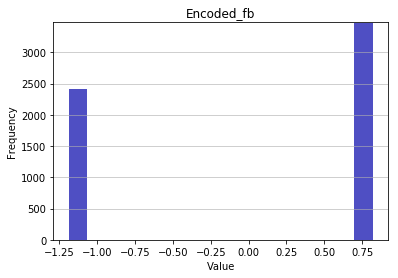

-------------------- 
Summary statistics:
 --------------------
Minimum value: -1.2001243716643233
Mean: -0.0
Standard deviation: 1.0001
Median: 0.8332
Maximal value: 0.8332469730726388


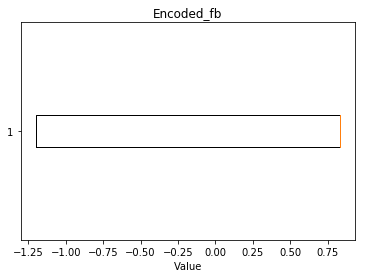

-------------------- 
Outlier detection:
 --------------------
List of outliers: set()


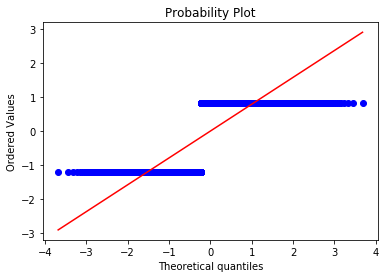

-------------------- 
Check for normal distribution:
 --------------------
Skewedness: -0.3669
Kurtosis: -1.8654
Overview of variable:  Encoded_fbassist 


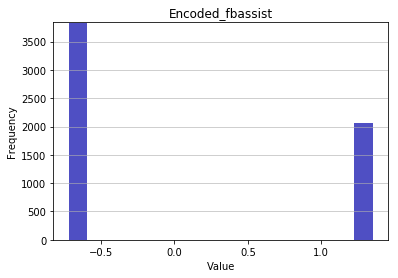

-------------------- 
Summary statistics:
 --------------------
Minimum value: -0.7326763415109852
Mean: 0.0
Standard deviation: 1.0001
Median: -0.7327
Maximal value: 1.3648591381260085


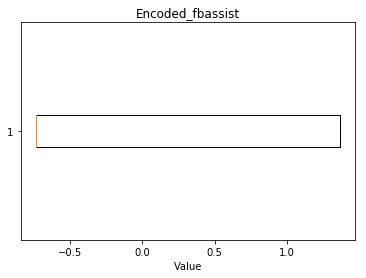

-------------------- 
Outlier detection:
 --------------------
List of outliers: set()


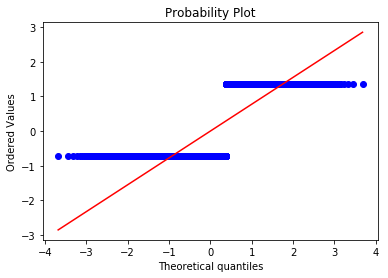

-------------------- 
Check for normal distribution:
 --------------------
Skewedness: 0.6322
Kurtosis: -1.6003
Overview of variable:  Encoded_fbvictim 


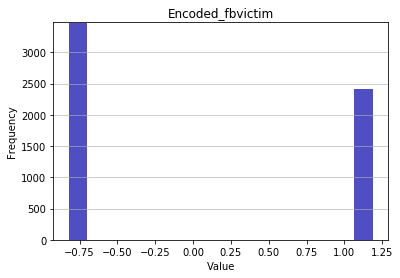

-------------------- 
Summary statistics:
 --------------------
Minimum value: -0.8332469730726391
Mean: -0.0
Standard deviation: 1.0001
Median: -0.8332
Maximal value: 1.2001243716643233


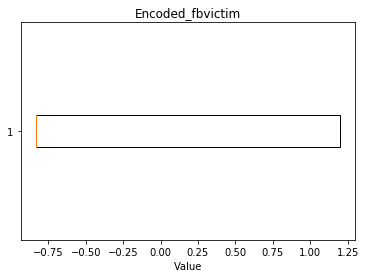

-------------------- 
Outlier detection:
 --------------------
List of outliers: set()


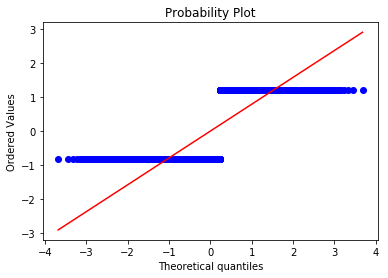

-------------------- 
Check for normal distribution:
 --------------------
Skewedness: 0.3669
Kurtosis: -1.8654
Overview of variable:  Encoded_fd 


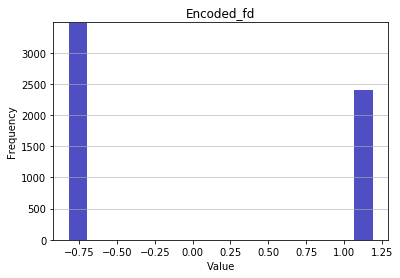

-------------------- 
Summary statistics:
 --------------------
Minimum value: -0.8309078237701986
Mean: -0.0
Standard deviation: 1.0001
Median: -0.8309
Maximal value: 1.2035029294375337


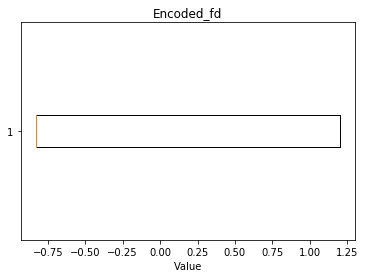

-------------------- 
Outlier detection:
 --------------------
List of outliers: set()


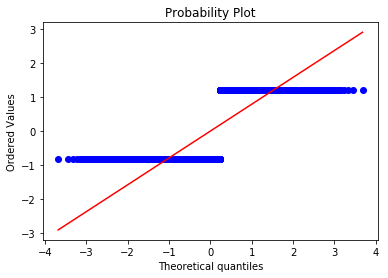

-------------------- 
Check for normal distribution:
 --------------------
Skewedness: 0.3726
Kurtosis: -1.8612
Overview of variable:  Encoded_ft 


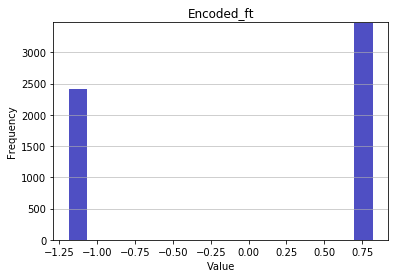

-------------------- 
Summary statistics:
 --------------------
Minimum value: -1.2001243716643233
Mean: -0.0
Standard deviation: 1.0001
Median: 0.8332
Maximal value: 0.8332469730726388


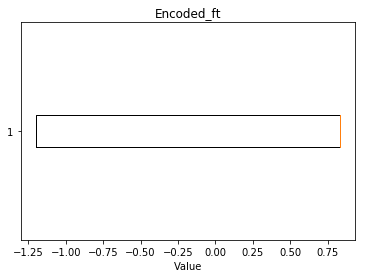

-------------------- 
Outlier detection:
 --------------------
List of outliers: set()


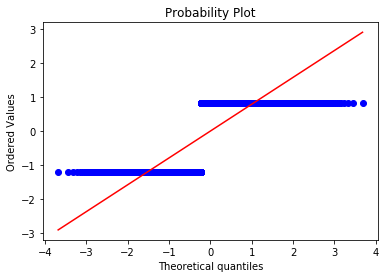

-------------------- 
Check for normal distribution:
 --------------------
Skewedness: -0.3669
Kurtosis: -1.8654
Overview of variable:  Encoded_firstmidouter 


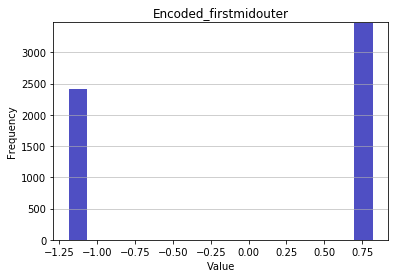

-------------------- 
Summary statistics:
 --------------------
Minimum value: -1.2001243716643233
Mean: -0.0
Standard deviation: 1.0001
Median: 0.8332
Maximal value: 0.8332469730726388


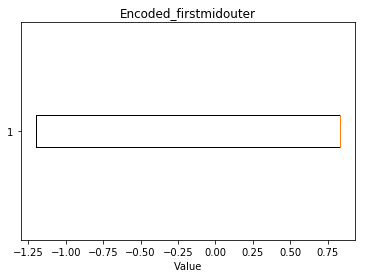

-------------------- 
Outlier detection:
 --------------------
List of outliers: set()


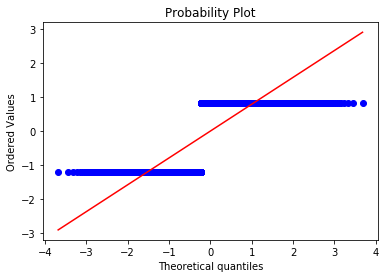

-------------------- 
Check for normal distribution:
 --------------------
Skewedness: -0.3669
Kurtosis: -1.8654
Overview of variable:  Encoded_firsttothreetowers 


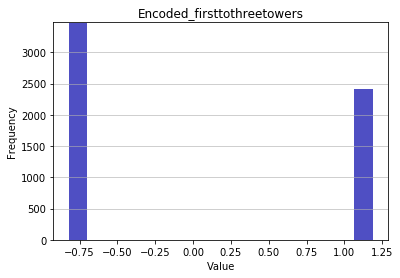

-------------------- 
Summary statistics:
 --------------------
Minimum value: -0.8332469730726391
Mean: -0.0
Standard deviation: 1.0001
Median: -0.8332
Maximal value: 1.2001243716643233


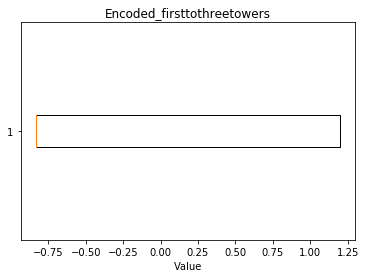

-------------------- 
Outlier detection:
 --------------------
List of outliers: set()


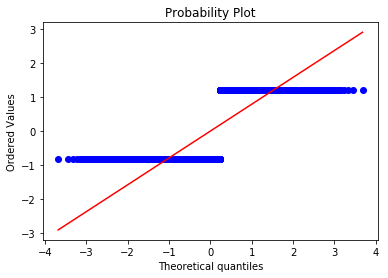

-------------------- 
Check for normal distribution:
 --------------------
Skewedness: 0.3669
Kurtosis: -1.8654
Overview of variable:  Encoded_fbaron 


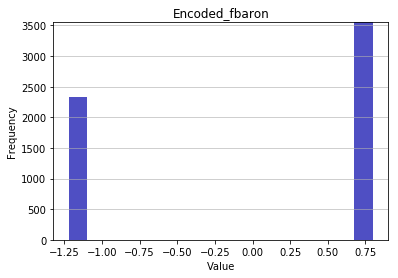

-------------------- 
Summary statistics:
 --------------------
Minimum value: -1.2323204157964371
Mean: -0.0
Standard deviation: 1.0001
Median: 0.8115
Maximal value: 0.8114772645016267


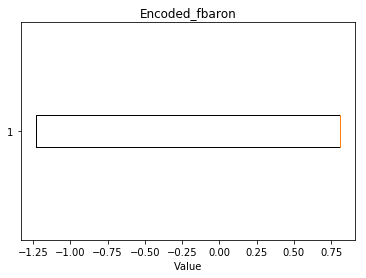

-------------------- 
Outlier detection:
 --------------------
List of outliers: set()


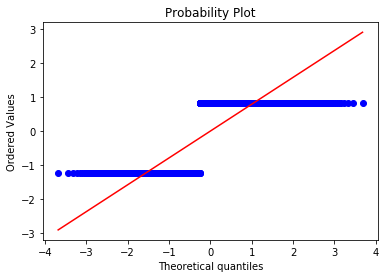

-------------------- 
Check for normal distribution:
 --------------------
Skewedness: -0.4208
Kurtosis: -1.8229
Overview of variable:  Encoded_Year 


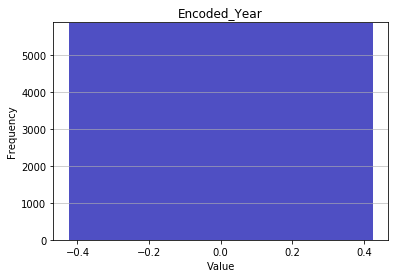

-------------------- 
Summary statistics:
 --------------------
Minimum value: 0.0
Mean: 0.0
Standard deviation: 0.0
Median: 0.0
Maximal value: 0.0


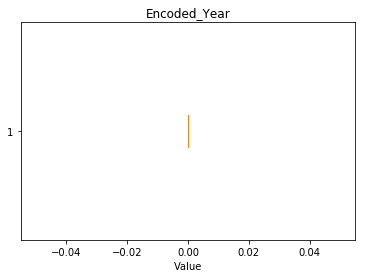

-------------------- 
Outlier detection:
 --------------------
List of outliers: set()


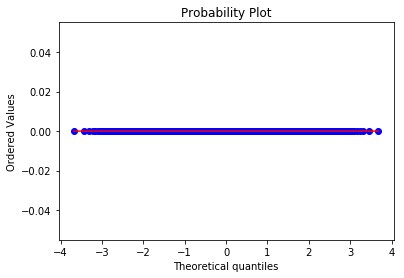

-------------------- 
Check for normal distribution:
 --------------------
Skewedness: 0.0
Kurtosis: -3.0
Overview of variable:  Encoded_culture 


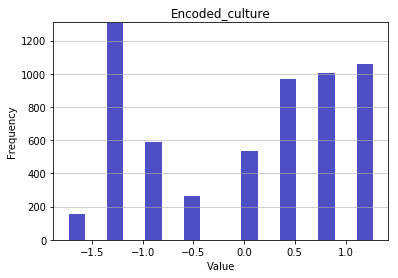

-------------------- 
Summary statistics:
 --------------------
Minimum value: -1.74425586519714
Mean: -0.0
Standard deviation: 1.0001
Median: 0.4199
Maximal value: 1.285543045336273


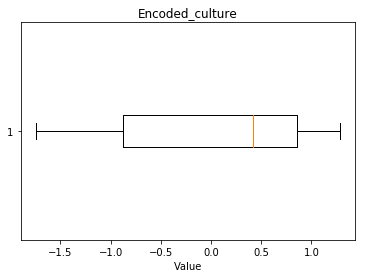

-------------------- 
Outlier detection:
 --------------------
List of outliers: set()


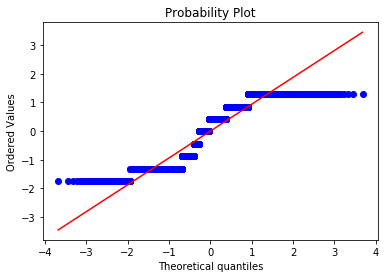

-------------------- 
Check for normal distribution:
 --------------------
Skewedness: -0.2116
Kurtosis: -1.4486


<Figure size 432x288 with 0 Axes>

In [23]:
# Loop through all numerical variables and visualize data
for num_variable in numerical_variables:
    SummaryNumericVar(transformed_data_df[num_variable], num_variable)

### 2.3 Conclusion univariate analysis

In [24]:
# Check whether all features in the dataset are numeric
set(transformed_data_df.dtypes)

{dtype('float64'), dtype('O')}

In [25]:
# Short intermediate summary
print("The transformed dataset captures information from", len(transformed_data_df.columns), "features.")
print("In total, there are", len(transformed_data_df), "observations present in the dataframe, capturing the information from",
      int(len(transformed_data_df)/2), "games.")
print("\nThe following features are captured by the dataset:\n\n", list(transformed_data_df.columns))

The transformed dataset captures information from 72 features.
In total, there are 5886 observations present in the dataframe, capturing the information from 2943 games.

The following features are captured by the dataset:

 ['split', 'patchno', 'gamelength', 'k', 'd', 'a', 'teamkills', 'fbtime', 'kpm', 'ckpm', 'fdtime', 'teamdragkills', 'elementals', 'firedrakes', 'waterdrakes', 'earthdrakes', 'airdrakes', 'elders', 'fttime', 'teamtowerkills', 'fbarontime', 'teambaronkills', 'dmgtochamps', 'dmgtochampsperminute', 'wards', 'wpm', 'wardkills', 'wcpm', 'visionwards', 'visionwardbuys', 'visiblewardclearrate', 'invisiblewardclearrate', 'totalgold', 'earnedgpm', 'goldspent', 'gspd', 'minionkills', 'monsterkills', 'monsterkillsownjungle', 'monsterkillsenemyjungle', 'cspm', 'goldat10', 'gdat10', 'goldat15', 'gdat15', 'xpat10', 'xpdat10', 'csat10', 'csdat10', 'csat15', 'csdat15', 'datediff', 'Encoded_league', 'Encoded_game', 'Encoded_side', 'Encoded_ban1', 'Encoded_ban2', 'Encoded_ban3', 'Enco

---------------------------------------------------------------------------------------------------- 
Overview of variable:  result 
 ----------------------------------------------------------------------------------------------------
Total categories: 2 



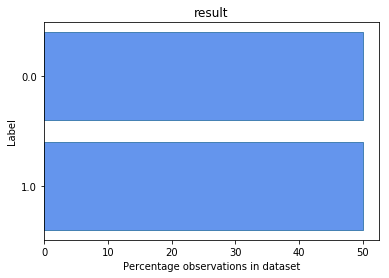

<Figure size 432x288 with 0 Axes>

In [26]:
# Refactoring encoding of target feature
transformed_data_df['result'] = [x if x > 0 else 0 for x in transformed_data_df['Encoded_result']]
transformed_data_df = transformed_data_df.drop(['Encoded_result'], axis = 1)

# Visualization properties target
SummaryCategoricalVar(transformed_data_df['result'], 'result')

In [27]:
# Save the transformed data
with open('/home/je32910/MasterThesis_ComputationalStatistics/pickles/' + saved_filename + '.pickle', 'wb') as f:
    pickle.dump(transformed_data_df, f)

In [28]:
# Save the file containing the column name and matching box-cox
with open('/home/je32910/MasterThesis_ComputationalStatistics/pickles/' + saved_filename + '_optimizers.pickle', 'wb') as f:
    pickle.dump(optimiser_dict, f)

## 3. Multivariate analysis
* Correlation plot (remove variables that are highly correlated)
* Boxplot/ scatterpot/ wrapped plot to visualize important relationships between variables
* t-test to assess difference between categories

### 3.1 Collinearity exploration

##### Investigate correlation between features

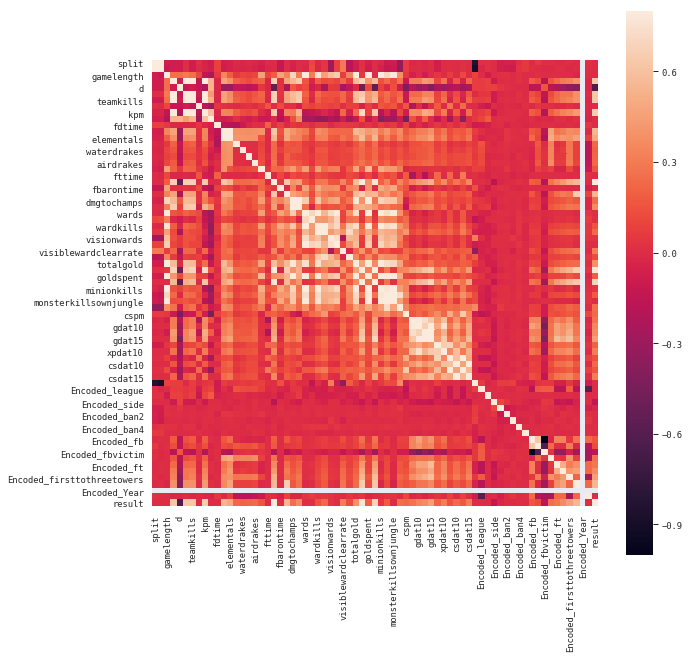

In [29]:
# Create corrplot
sns.set(context = "paper", font = "monospace")
corrmat = transformed_data_df.corr()
f, ax = plt.subplots(figsize = (10, 10))
sns.heatmap(corrmat, vmax = .8, square = True) 
plt.show()

In [30]:
# Print list with highest correlated features
corrmap_abs = transformed_data_df.corr().abs()
corrmap_abs_sorted = corrmap_abs.unstack().sort_values(kind = "quicksort", ascending = False)
corrmap_abs_sorted.iloc[(len(transformed_data_df.columns) + 3):(len(transformed_data_df.columns) + 1) + 20,]

a            teamkills      0.930827
k            a              0.930827
teamkills    a              0.930827
patchno      split          0.924460
split        patchno        0.924460
goldspent    minionkills    0.905135
minionkills  goldspent      0.905135
kpm          k              0.902131
             teamkills      0.902131
teamkills    kpm            0.902131
k            kpm            0.902131
patchno      datediff       0.894855
datediff     patchno        0.894855
gspd         earnedgpm      0.893827
earnedgpm    gspd           0.893827
totalgold    gamelength     0.885747
gamelength   totalgold      0.885747
wcpm         wardkills      0.884032
dtype: float64

In [31]:
# Short intermediate summary
print("The percentage of correlations (autocorrelations excluded) higher than 0.5 in absolute value: ",
      str(sum([x for x in list(corrmap_abs_sorted) if x >= 0.5])/len(corrmap_abs_sorted)*100))

The percentage of correlations (autocorrelations excluded) higher than 0.5 in absolute value:  6.201065801917765


##### Calculate variance inflation factor
This is purely out of interest, although we expect penelized regression methods to be able to cope with collinearity between the features.

In [32]:
# Extract dataset containing only the numeric features
transformed_data_numeric_df = transformed_data_df.copy()
transformed_data_numeric_df = transformed_data_numeric_df.drop(labels = ['team'], axis=1)

In [33]:
# Calculate the variance inflation factor for the different features
X = add_constant(transformed_data_numeric_df)
vif_columns = pd.Series([variance_inflation_factor(X.values, i) for i in range(X.shape[1])], index = X.columns)

In [34]:
# Print the top 20 features with the highest VIF
vif_columns_sorted = vif_columns.sort_values(kind = "quicksort", ascending = False)
vif_columns_sorted[:20]

k                              inf
Encoded_fbvictim               inf
teamkills                      inf
Encoded_fb                     inf
wardkills               328.822881
wards                   251.342766
dmgtochamps             247.732182
wcpm                    135.445085
dmgtochampsperminute    116.240132
totalgold               110.473138
minionkills              98.560664
gamelength               87.904013
kpm                      55.442998
goldspent                52.678484
wpm                      50.921294
ckpm                     29.316866
d                        21.781601
elementals               20.862238
monsterkills             20.179866
earnedgpm                19.729542
dtype: float64

### 3.2 Some visualizations

In [35]:
data_preparation.columns

Index(['gameid', 'league', 'split', 'game', 'patchno', 'side', 'ban1', 'ban2',
       'ban3', 'ban4', 'ban5', 'gamelength', 'result', 'k', 'd', 'a',
       'teamkills', 'fb', 'fbassist', 'fbvictim', 'fbtime', 'kpm', 'ckpm',
       'fd', 'fdtime', 'teamdragkills', 'elementals', 'firedrakes',
       'waterdrakes', 'earthdrakes', 'airdrakes', 'elders', 'ft', 'fttime',
       'firstmidouter', 'firsttothreetowers', 'teamtowerkills', 'fbaron',
       'fbarontime', 'teambaronkills', 'dmgtochamps', 'dmgtochampsperminute',
       'wards', 'wpm', 'wardshare', 'wardkills', 'wcpm', 'visionwards',
       'visionwardbuys', 'visiblewardclearrate', 'invisiblewardclearrate',
       'totalgold', 'earnedgpm', 'goldspent', 'gspd', 'minionkills',
       'monsterkills', 'monsterkillsownjungle', 'monsterkillsenemyjungle',
       'cspm', 'goldat10', 'gdat10', 'goldat15', 'gdat15', 'xpat10', 'xpdat10',
       'csat10', 'csdat10', 'csat15', 'csdat15', 'Year', 'team', 'culture',
       'datediff'],
      dtype='

NameError: name 'dog' is not defined

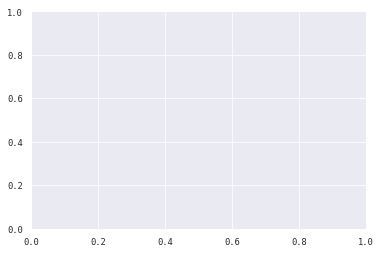

In [36]:
fig, ax = plt.subplots()
ax.plot(data_preparation.league, dog, label="dog")
ax.plot(data_preparation.league, cat, label="cat")
ax.legend()

In [ ]:
# Visualize a summarization of the accuracy metrics for the different ML methods
fig, ax = plt.subplots()
ax.plot(list(data_preparation.index), model_summary_table.sensitivity, '--', label="sensitivity", color='lightskyblue')
ax.plot(list(data_preparation.index), model_summary_table.specificity, '--', label="specificity", color='lightblue')
ax.plot(list(model_summary_table.index), model_summary_table.accuracy, label="accuracy", color='royalblue')
plt.title("Sensitivity, specificity and accuracy regularization models")
ax.legend(loc ="best", fontsize = 8)